In [10]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pickle, glob, yaml, string
from matplotlib import cm

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.stats import binned_statistic_2d

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site
import beamcals.reduce_ccclass as rc

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'
polbeamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles_polar/'

In [11]:
def get_flightinfo(fly):
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    elif whstat=='mednoabs':
        stat = np.nanmedian(diff_flat)
    return stat

def get_slice_xy(xes,yes,val,ax='x'):
    tol = 1.5
    if ax=='x':
        col = np.where((xes < val+tol) & (xes > val-tol))[0]
    if ax=='y':
        col = np.where((yes < val+tol) & (yes > val-tol))[0]
    return col

def get_concatlist(flights):
    #for i, fly in enumerate(flights):
    pickle_directory='/hirax/GBO_Analysis_Outputs/flight_pickles/'
    concytest=[glob.glob(pickle_directory+'*'+fly+'*')[0] for fly in flights]
    return concytest

def convert_to_angle(d):
    h = 177.0 # meters
    aa = np.arctan(d/h)
    return np.degrees(aa)

def convert_sig_to_FWHM(sig):
    return 2.355*sig


def m_to_FWHM(d):
    angle = convert_to_angle(d)
    return convert_sig_to_FWHM(angle)

def FWHM_to_m(angle):
    sig = fwhm/2.355
    h = 177.0 # meters
    return h*np.tan(np.radians(sig))


In [12]:
# What should I use for the FWHM of a diffraction limited telescope?

## Use 1.03 for diffraction limit for FWHM, from 
# https://www.telescope-optics.net/telescope_resolution.htm

def get_diffrac(fs):
    D = 6.0
    lam = 3E8 / (fs*1E6) # lambda in meters
    return np.degrees(np.arcsin(1.03 * lam / D)) 

In [13]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False
ccm = cm.magma

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

# after looking through the slices and being very picky
good_freqs =  [538, 553, 554,
       556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 568, 569,
       571, 572, 575, 576, 577, 578, 579, 580, 581, 584, 630, 631, 632,
       633, 636, 639, 645, 676, 691, 692, 695, 696, 697, 698, 699, 700,
       702, 703, 705, 706, 707, 719, 720, 768, 799, 801, 802, 803,
       805, 807, 808, 810, 811, 814, 845, 846, 847, 848, 849, 851, 852,
       853, 854, 855, 856, 857, 858, 860, 861, 862, 863, 864, 865, 866,
       867, 869, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881,
       883, 884, 885, 887, 888, 890, 891, 892, 895, 896, 899, 900, 902,
       903, 904, 905, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916,
       917, 918, 919, 921, 922, 923, 924, 925, 926, 928, 929, 930, 931,
       932, 933, 935, 936, 937, 938, 939]

['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FLY536_Corrected_amplitudes.pkl'
 'FLY618_Corrected_amplitudes.pkl' 'FLY619_Corrected_amplitudes.pkl'
 'FLY620_Corrected_amplitudes.pkl' 'FLY623_Corrected_amplitudes.pkl'
 'FLY625

In [14]:
## 1. Do the dumb thing, compare FWHMss (code to generate at end of nb)
## This one is in cartesian

In [15]:
###### LEAST SQUARES FITTING #####
###### Only need to run this once!!!! ####
##
##
##print(good_freqs)
#pG=np.array([1.0,0.0,6.0,0.0,6.0,1E-4])
#fittingParamsWErrors = np.zeros([16, 1024,6,2])
#restr = 39 # 50 was default
##
### set which pol:
#copoldir = 'N'
#pols = N_pols
##
#for f,find in enumerate(good_freqs):#
#
#    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
#    with open(picklefile, 'rb') as inp:
#        ptest = pickle.load(inp)#
#
#    for j, chind in enumerate(pols): 
#        
#        mbx = ptest.x_centers_grid[:,:,chind].flatten()
#        mby = ptest.y_centers_grid[:,:,chind].flatten()
#        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()#
#
#        gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
#        gi = np.where(np.isfinite(mbV))[0]
#        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
#        G_popt = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data)
#        fitParams = G_popt.x
#        param_errors = np.sqrt(np.diag(G_popt.jac.T @G_popt.jac))
#        fittingParamsWErrors[chind, find, :, 0] = fitParams
#        fittingParamsWErrors[chind, find, :, 1] = param_errors
#
#copoldir = 'E'
#pols = E_pols
#
#for f,find in enumerate(good_freqs):#
#
#    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
#    with open(picklefile, 'rb') as inp:
#        ptest = pickle.load(inp)#
#
#    for j, chind in enumerate(pols): 
#        mbx = ptest.x_centers_grid[:,:,chind].flatten()
#        mby = ptest.y_centers_grid[:,:,chind].flatten()
#        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()
#
#        gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
##        gi = np.where(np.isfinite(mbV))[0]
#        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
#        G_popt = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data)
#        fitParams = G_popt.x
#        param_errors = np.sqrt(np.diag(G_popt.jac.T @G_popt.jac))
#        fittingParamsWErrors[chind, find, :, 0] = fitParams
#        fittingParamsWErrors[chind, find, :, 1] = param_errors
        
#tmpfitpath='/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_and_Airy_Param_2023_12_17_wlim.npz'
#np.savez(tmpfitpath,G_popt = fittingParamsWErrors)

# Lets try a careful check of the gridding, in case that is doing something unexpected to the data

In [16]:
# Input 3 was the next worst one between the mean and the coadded data, check that

# Let's get the raw data from flight 625, and the gridded data from it, and compare FWHMs

618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl'>
[ 6.81327192e-08 -1.37446919e+01  7.13198868e+00 -5.36789520e+00
  8.49691497e+00  1.71738226e-10  0.00000000e+00]
height:  174.65628137173243


<ipython-input-17-b7b0111061ac>:38: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[i,0].scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm(),vmin=1E-4,vmax=1)


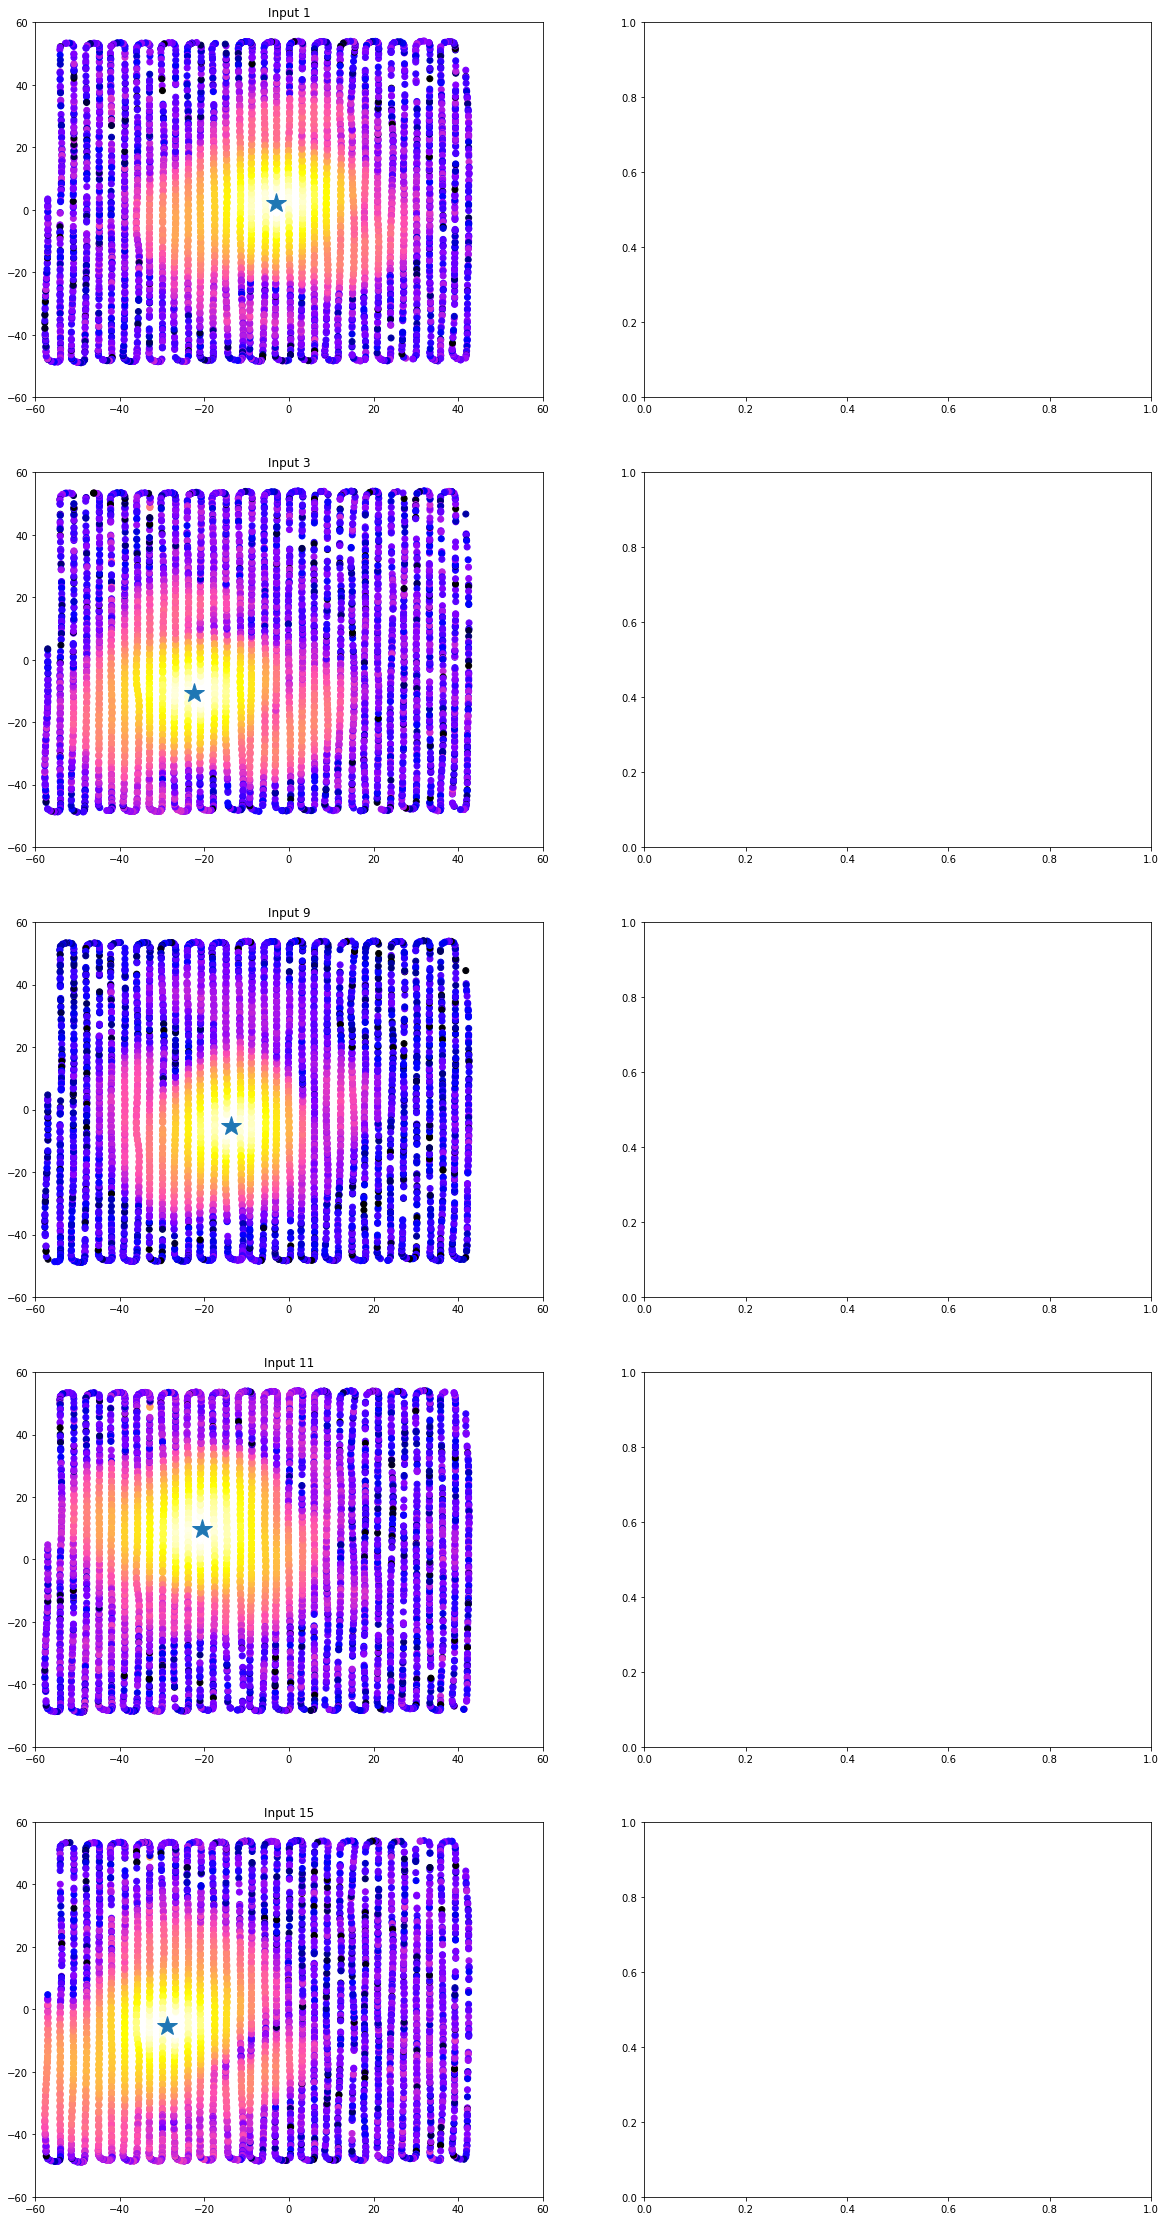

In [17]:
# Read in Flight 
fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# initial settings
find = good_freqs[0]#900
chind=9

# Choose which dish here

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    fl625=pickle.load(pfile)
t_cut_625=fl625.inds_on  

# Plot the 2D data and see if its bascially sensible


print(fl625.G_popt[chind,find,:])

x = fl625.drone_xyz_LC_interp[t_cut_625,0]
y = fl625.drone_xyz_LC_interp[t_cut_625,1]
z = fl625.V_bgsub[t_cut_625,find,chind] 

print('height: ', np.nanmedian(fl625.drone_xyz_per_dish_interp[chind,t_cut_625,2]))
colorz=pu.cm_to_discrete(ccm, 16)
fig,axs = plt.subplots(5,2,figsize=(20,40))
for i, chind in enumerate(pols):


    x = fl625.drone_xyz_LC_interp[t_cut_625,0]  
    y = fl625.drone_xyz_LC_interp[t_cut_625,1]
    z = fl625.V_bgsub[t_cut_625,find,chind]/ fl625.G_popt[chind,find,0]


    # plot scatter plot and beam map
    axs[i,0].scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm(),vmin=1E-4,vmax=1)
    axs[i,0].plot(fl625.G_popt[chind,find,1],fl625.G_popt[chind,find,3],marker='*',markersize=20)
    axs[i,0].set_ylim(-60,60)
    axs[i,0].set_xlim(-60,60)
    axs[i,0].set_title('Input '+str(chind))
plt.show()



618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl'>
[ 6.81327192e-08 -1.37446919e+01  7.13198868e+00 -5.36789520e+00
  8.49691497e+00  1.71738226e-10  0.00000000e+00]
height:  174.65628137173243


<ipython-input-18-d267f3214c34>:38: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[i,0].scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm(),vmin=1E-4,vmax=1)


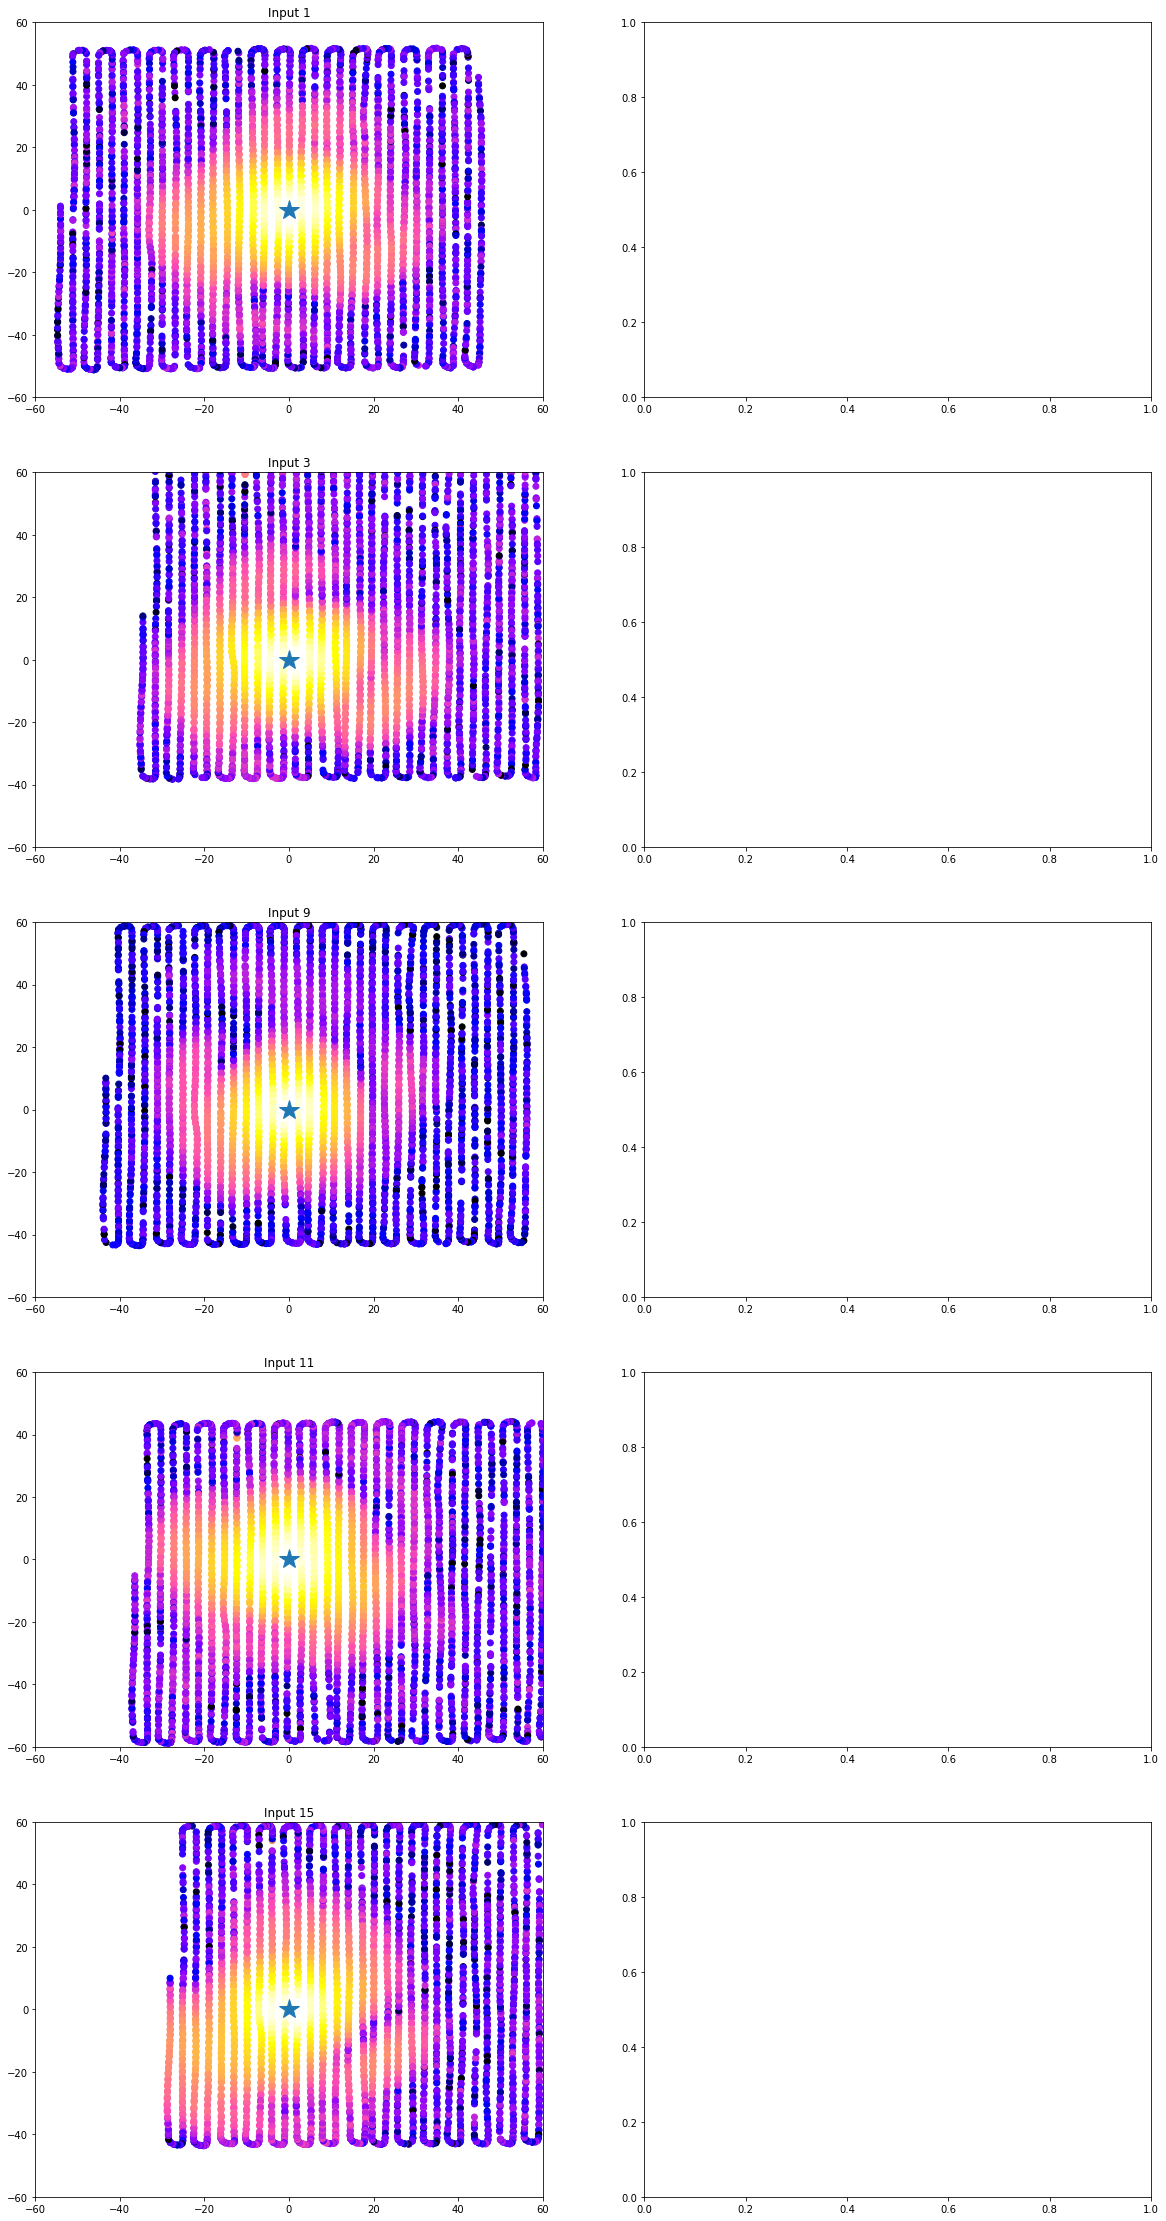

In [18]:
# Read in Flight 
fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# initial settings
find = good_freqs[0]#900
chind=9

# Choose which dish here

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    fl625=pickle.load(pfile)
t_cut_625=fl625.inds_on  

# Plot the 2D data and see if its bascially sensible


print(fl625.G_popt[chind,find,:])

x = fl625.drone_xyz_LC_interp[t_cut_625,0]
y = fl625.drone_xyz_LC_interp[t_cut_625,1]
z = fl625.V_bgsub[t_cut_625,find,chind] 

print('height: ', np.nanmedian(fl625.drone_xyz_per_dish_interp[chind,t_cut_625,2]))
colorz=pu.cm_to_discrete(ccm, 16)
fig,axs = plt.subplots(5,2,figsize=(20,40))
for i, chind in enumerate(pols):


    x = fl625.drone_xyz_LC_interp[t_cut_625,0] - fl625.G_popt[chind,find,1]
    y = fl625.drone_xyz_LC_interp[t_cut_625,1] - fl625.G_popt[chind,find,3]
    z = fl625.V_bgsub[t_cut_625,find,chind]/ fl625.G_popt[chind,find,0]


    # plot scatter plot and beam map
    axs[i,0].scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm(),vmin=1E-4,vmax=1)
    axs[i,0].plot(0,0,marker='*',markersize=20)
    axs[i,0].set_ylim(-60,60)
    axs[i,0].set_xlim(-60,60)
    axs[i,0].set_title('Input '+str(chind))
plt.show()



618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl'>
[ 6.81327192e-08 -1.37446919e+01  7.13198868e+00 -5.36789520e+00
  8.49691497e+00  1.71738226e-10  0.00000000e+00]
height:  174.65628137173243


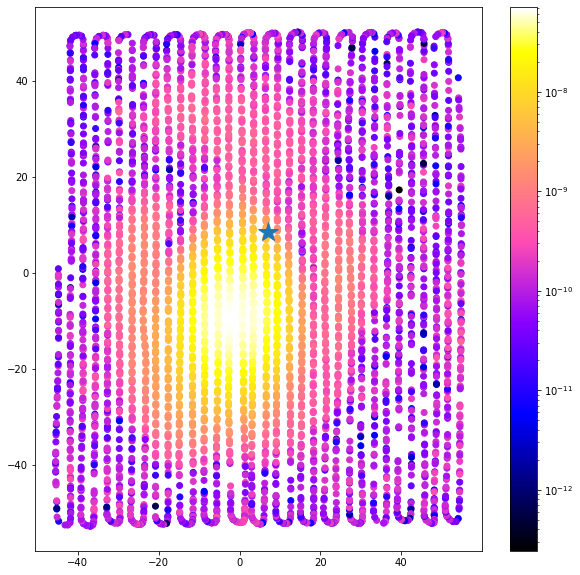

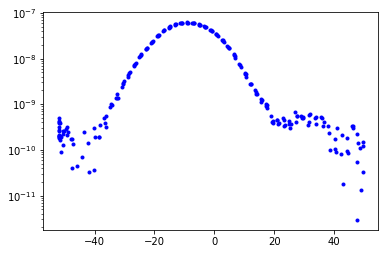

<ipython-input-41-f3afa5f921a6>:55: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[i,0].scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm(),vmin=1E-4,vmax=1)
<ipython-input-41-f3afa5f921a6>:55: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[i,0].scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm(),vmin=1E-4,vmax=1)
<ipython-input-41-f3afa5f921a6>:55: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[i,0].scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm(),vmin=1E-4,vmax=1)
<ipy

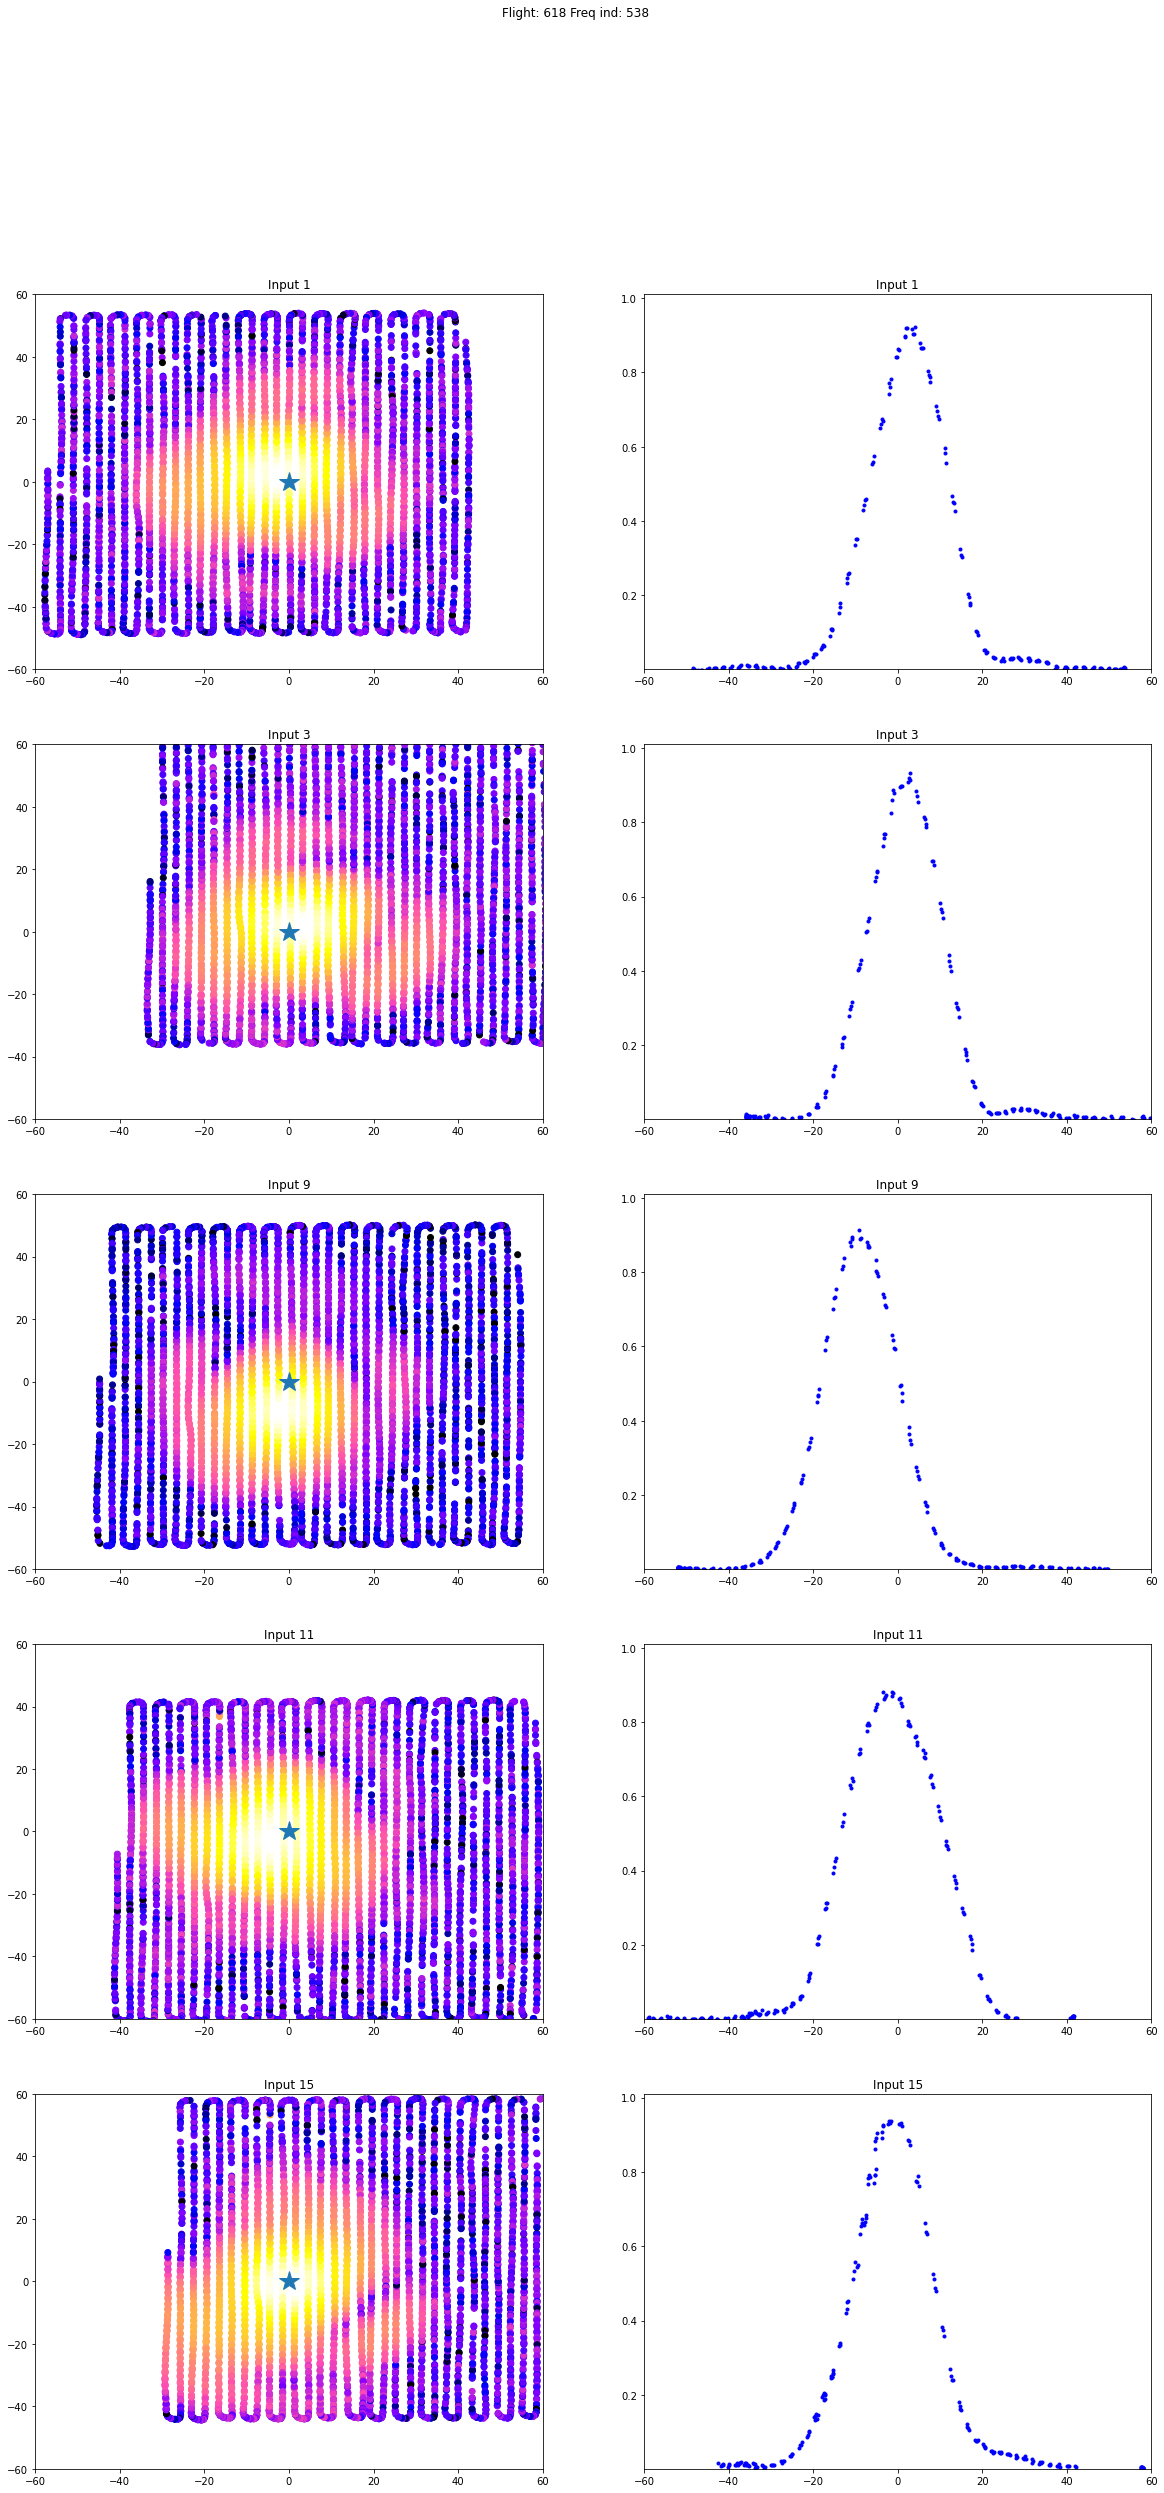

In [41]:
# Read in Flight 
fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# initial settings
find = good_freqs[0]#900
chind=9

# Choose which dish here

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    fl625=pickle.load(pfile)
t_cut_625=fl625.inds_on  

# Plot the 2D data and see if its bascially sensible


print(fl625.G_popt[chind,find,:])

x = fl625.drone_xyz_per_dish_interp[chind,t_cut_625,0]
y = fl625.drone_xyz_per_dish_interp[chind,t_cut_625,1]
z = fl625.V_bgsub[t_cut_625,find,chind] 

print('height: ', np.nanmedian(fl625.drone_xyz_per_dish_interp[chind,t_cut_625,2]))


# plot scatter plot and beam map
plt.figure(1,figsize=(10,10))
plt.scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm())
plt.plot(fl625.G_popt[chind,find,2],fl625.G_popt[chind,find,4],marker='*',markersize=20)
plt.colorbar()
plt.show()

# grab a slice and plot it

ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
plt.semilogy(y[ixd],z[ixd],'b.',label='copol')
plt.show()


colorz=pu.cm_to_discrete(ccm, 16)
fig,axs = plt.subplots(5,2,figsize=(20,40))

for i, chind in enumerate(pols):


    x = fl625.drone_xyz_per_dish_interp[chind,t_cut_625,0]
    y = fl625.drone_xyz_per_dish_interp[chind,t_cut_625,1]
    z = fl625.V_bgsub[t_cut_625,find,chind]/ fl625.G_popt[chind,find,0]


    # plot scatter plot and beam map
    axs[i,0].scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm(),vmin=1E-4,vmax=1)
    axs[i,0].plot(0,0,marker='*',markersize=20)
    axs[i,0].plot(0,0,marker='*',markersize=20)
    axs[i,0].set_ylim(-60,60)
    axs[i,0].set_xlim(-60,60)
    axs[i,0].set_title('Input '+str(chind))

    # grab a slice and plot it
    ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
    axs[i,1].plot(y[ixd],z[ixd],'b.',label='copol')
    axs[i,1].set_xlim(-60,60)
    axs[i,1].set_ylim(1E-3,1.01)
    axs[i,1].set_title('Input '+str(chind))
fig.suptitle('Flight: '+fly+' Freq ind: '+str(find))   
plt.show()

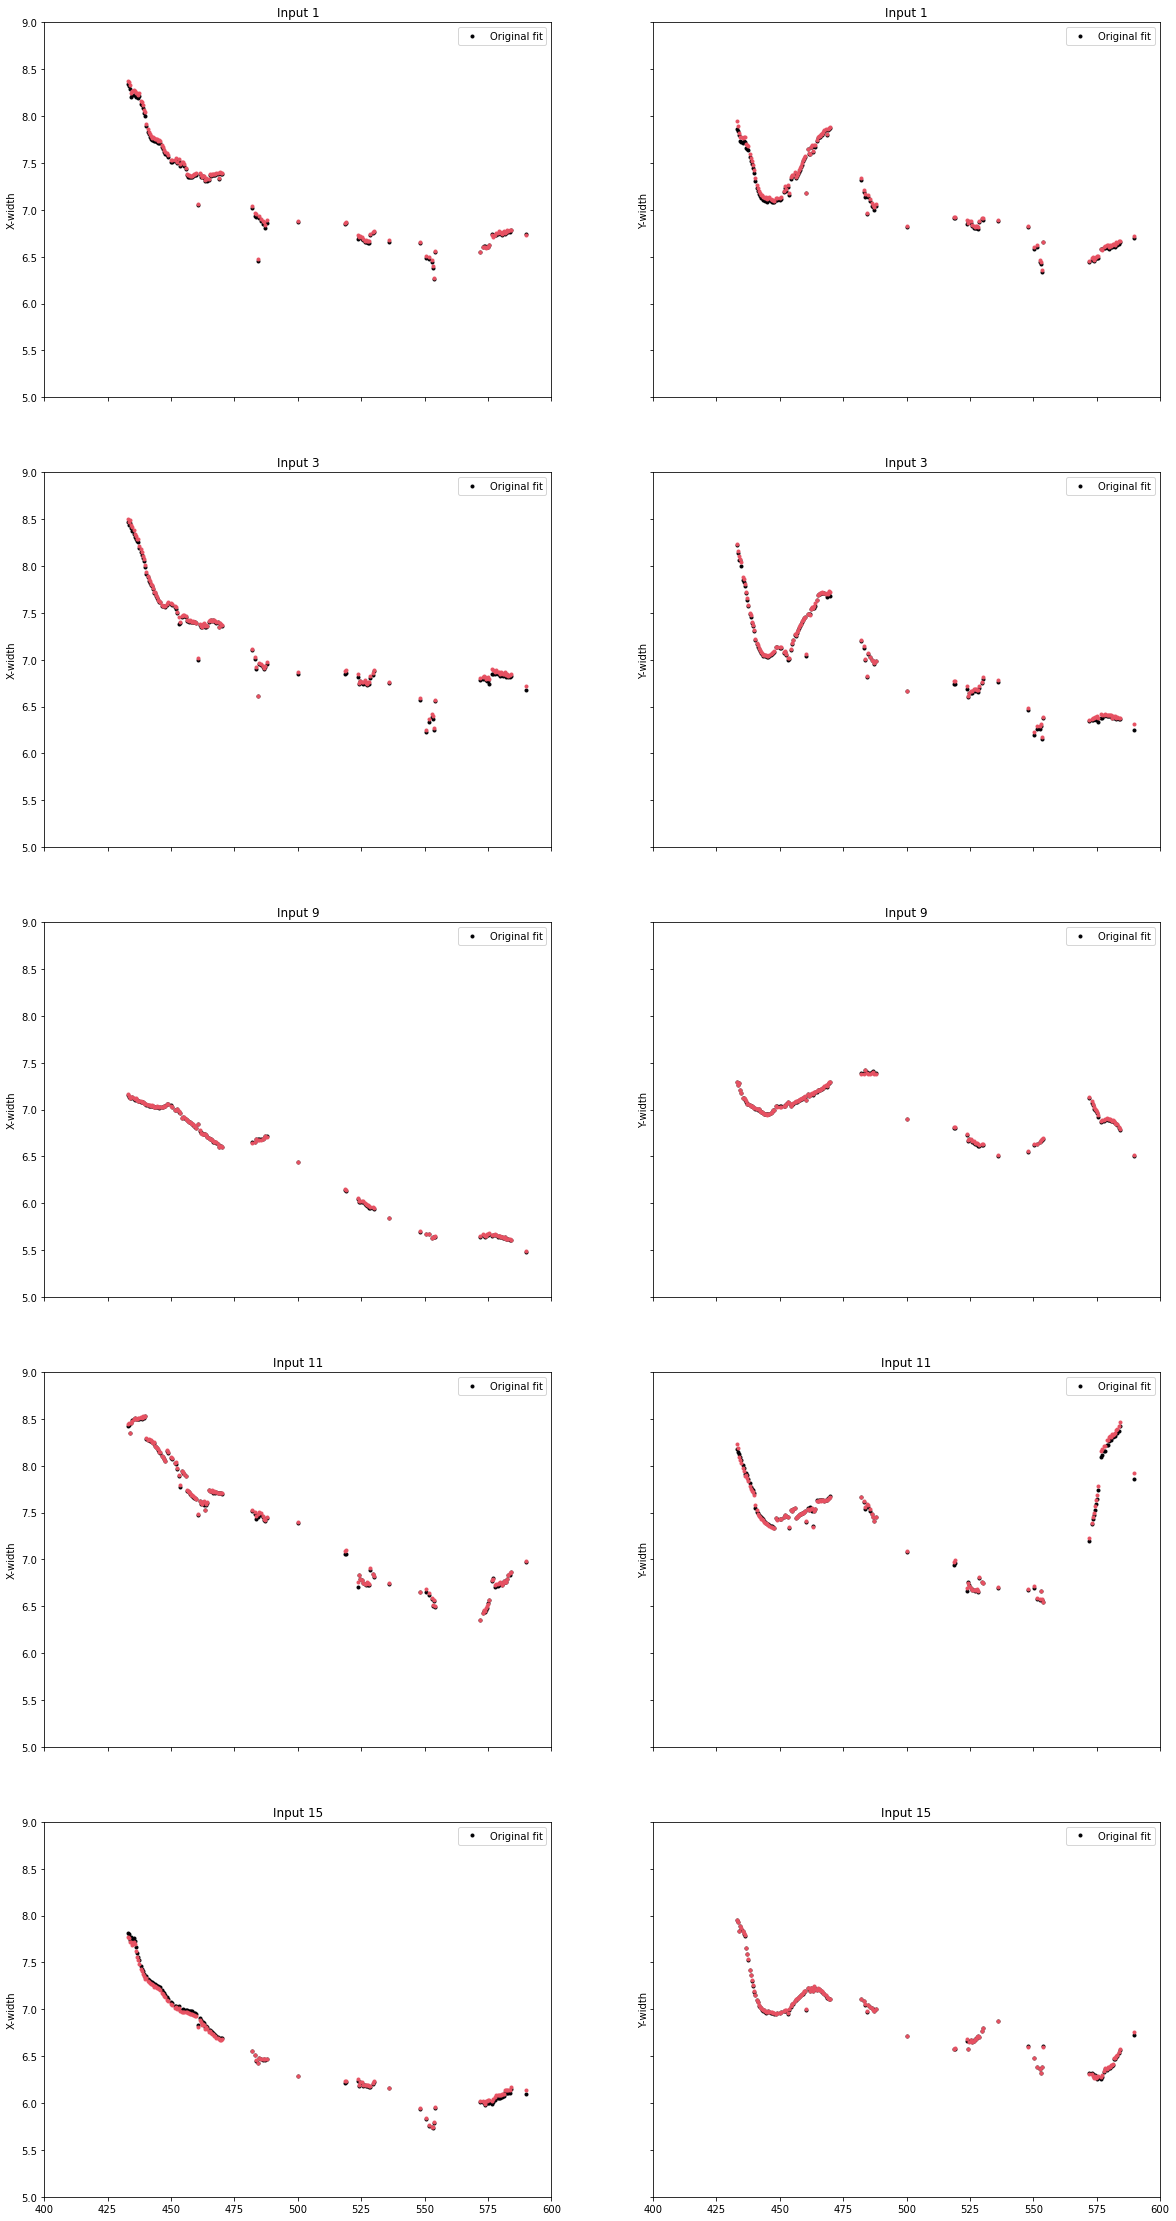

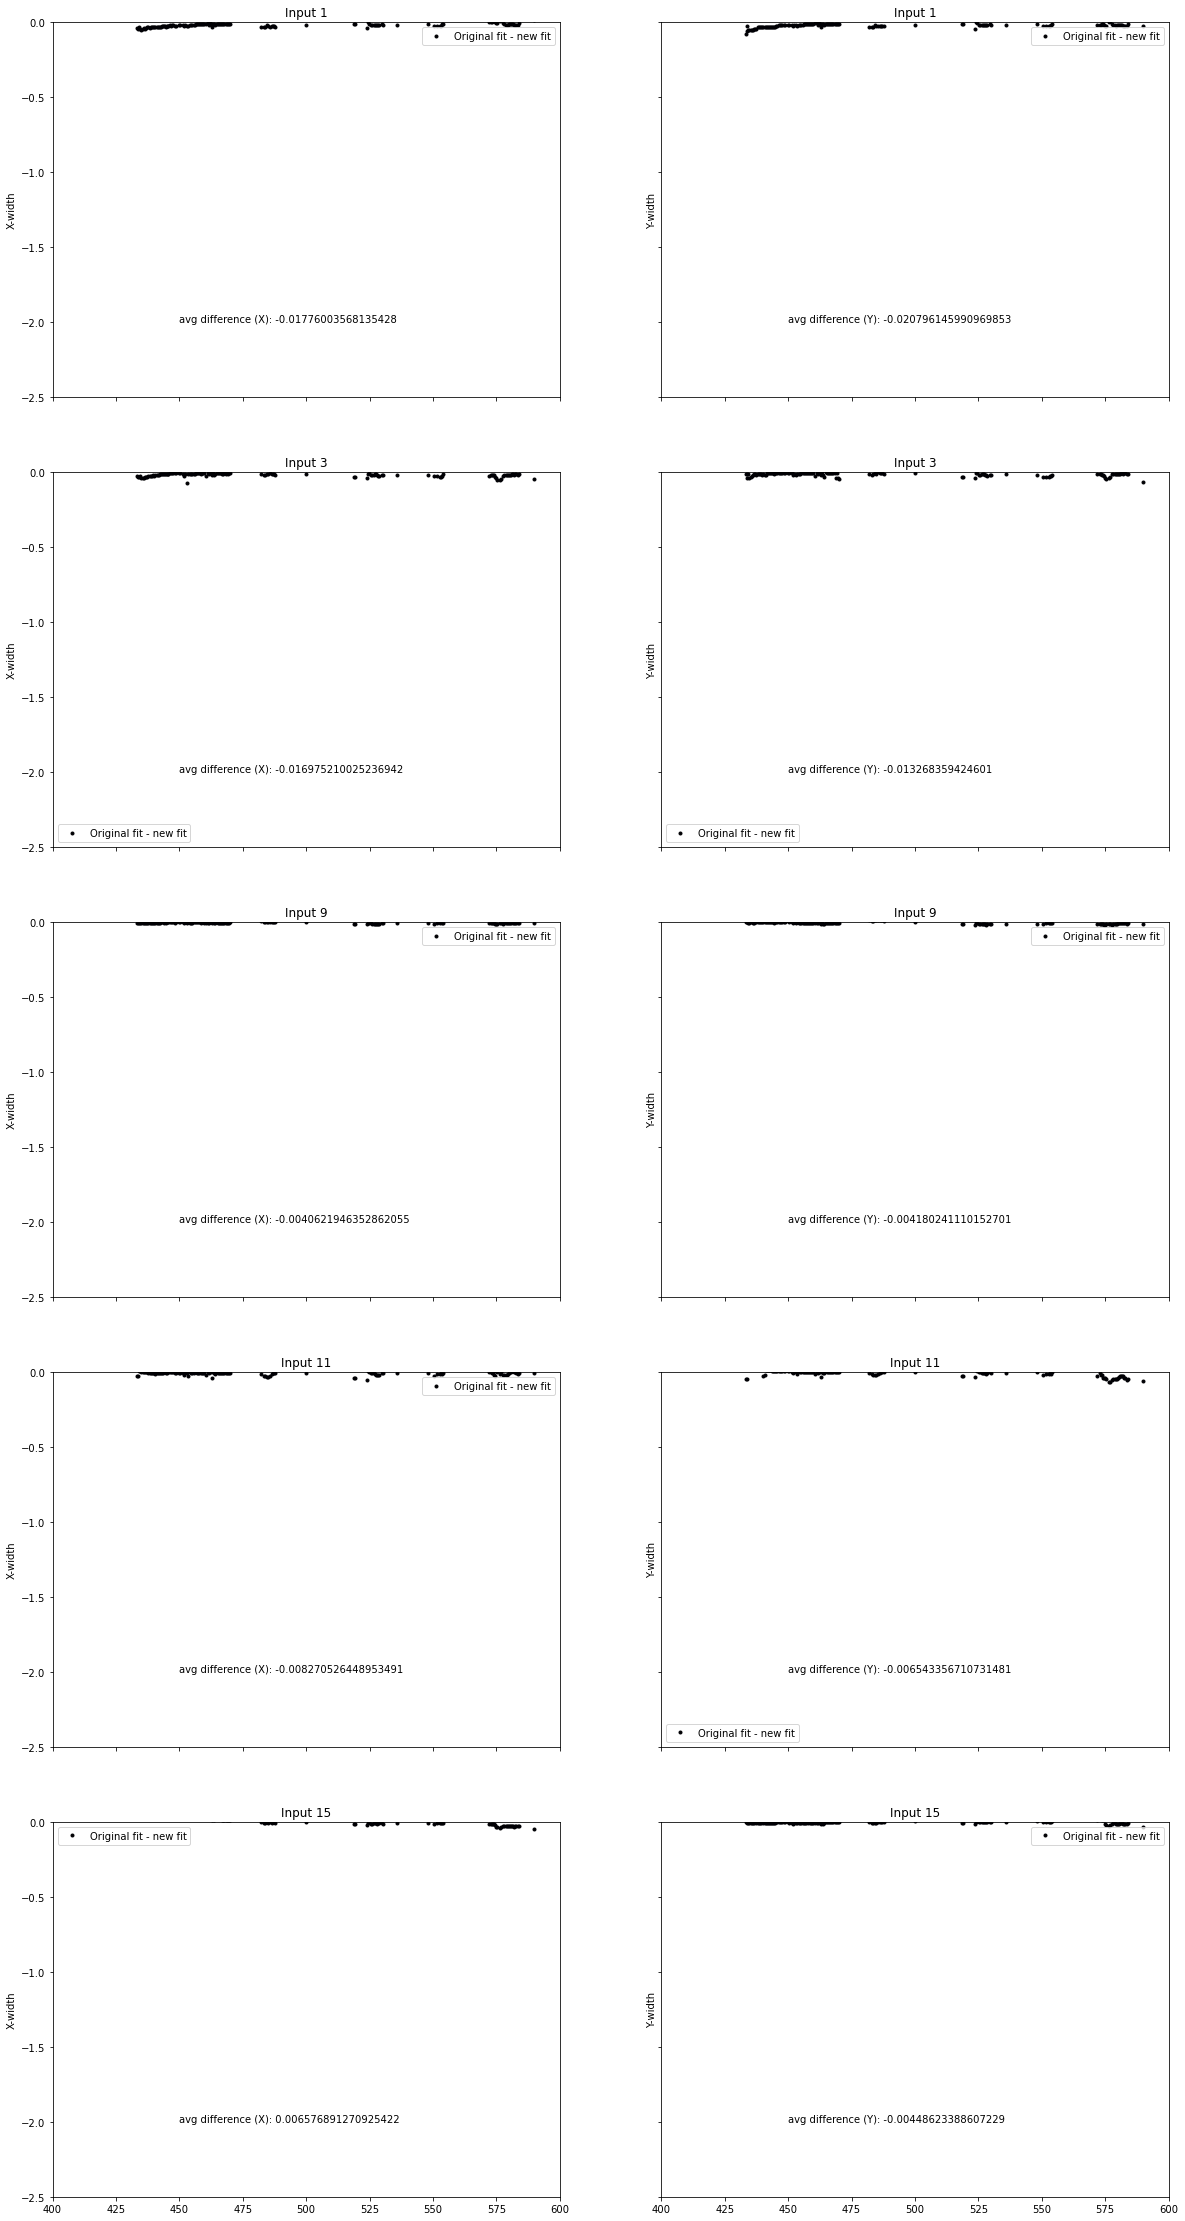

In [9]:
colorz=pu.cm_to_discrete(ccm, 16)
fig,axs = plt.subplots(5,2, sharex=True,sharey=True,figsize=(20,40))
Gpopt_new = np.zeros([16,1024,6])

for i,chind in enumerate(N_pols):
    x = fl625.drone_xyz_per_dish_interp[chind,t_cut_625,0]
    y = fl625.drone_xyz_per_dish_interp[chind,t_cut_625,1]
    axs[i,0].plot(freqs[good_freqs],m_to_FWHM(fl625.G_popt[chind,good_freqs,2]),color=colorz[0],
                  marker='.',linestyle='None',label='Original fit')
    axs[i,1].plot(freqs[good_freqs],m_to_FWHM(fl625.G_popt[chind,good_freqs,4]),color=colorz[0],
                  marker='.',linestyle='None',label='Original fit')
    
    for find in good_freqs:
        z = fl625.V_bgsub[t_cut_625,find,chind]

        mbx = x
        mby = y
        mbV = z

        gi = np.where((np.isfinite(mbV)))[0]
        #restr = 10
        #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        #pG = fl625.G_popt[chind,find,0:6]
        pG = [1E-8,0.0, 8.0, 0.0, 8.0, 1E-11]
        #print('old ',pG)

        Gpopt_new[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
        axs[i,0].plot(freqs[find],m_to_FWHM(abs(Gpopt_new[chind,find,2])),color=colorz[10],marker='.',linestyle='None')        
        axs[i,1].plot(freqs[find],m_to_FWHM(abs(Gpopt_new[chind,find,4])),color=colorz[10],marker='.',linestyle='None')
        #print(i, chind, find, len(gi),Pnew)
    
    axs[i,0].legend()
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X-width')
    axs[i,0].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
    axs[i,1].legend()
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('Y-width')
    axs[i,1].set_ylim(5,9)
    axs[i,1].set_xlim(400,600)
plt.show()


fig,axs = plt.subplots(5,2, sharex=True,sharey=True,figsize=(20,40))

for i,chind in enumerate(N_pols):
    
    axs[i,0].plot(freqs[good_freqs],
                  m_to_FWHM(fl625.G_popt[chind,good_freqs,2])-m_to_FWHM(abs(Gpopt_new[chind,good_freqs,2])),
                  color=colorz[0],marker='.',linestyle='None',label='Original fit - new fit')
    axs[i,1].plot(freqs[good_freqs],
                  m_to_FWHM(fl625.G_popt[chind,good_freqs,4])-m_to_FWHM(abs(Gpopt_new[chind,good_freqs,4])),
                  color=colorz[0],marker='.',linestyle='None',label='Original fit - new fit')
    
    axs[i,0].legend()
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X-width')
    axs[i,0].set_ylim(-2.5,0)
    axs[i,0].set_xlim(400,600)
    axs[i,1].legend()
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('Y-width')
    axs[i,1].set_ylim(-2.5,0)
    axs[i,1].set_xlim(400,600)
    axs[i,0].text(450,-2,'avg difference (X): '+str(np.average(
        m_to_FWHM(fl625.G_popt[chind,good_freqs,2])-m_to_FWHM(abs(Gpopt_new[chind,good_freqs,2])))))
    axs[i,1].text(450,-2,'avg difference (Y): '+str(np.average(
        m_to_FWHM(fl625.G_popt[chind,good_freqs,4])-m_to_FWHM(abs(Gpopt_new[chind,good_freqs,4])))))
plt.show()

In [10]:
# Now, grid the data and re-fit FWHM

In [11]:
for find in good_freqs[110:111]:
    print('Working on Frequency: ',find,freqs[find])

    flights = ['619']
    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in flights]

    beam=ba.Beammap_forautoprocessing(concatlist=concytest,
                 normalization='Gauss_wcorr',operation='coadd',mask=True,Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find,find+1,1])
    #beam=ba.Beammap_polar(concatlist=concytest,
    #            coordsys='polar',
    #            d0args=[-delt_the/2.0,(60*delt_the)-(delt_the/2.0),delt_the],
    #            d1args=[0,np.radians(36),delt_phi],
    #            normalization='Gauss_wcorr',operation='std',Fargs=[find,find+1,1],
    #            f_index=find,vplot=False,mask=True)

    


Working on Frequency:  908 445.3125
start of big ass loop is: 2024-02-01 09:30:46.825461
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:30:50.615545   


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beam_autoprocessing.py:174: RuntimeWarning: invalid value encountered in true_divide
  self.V_LC_operation = np.nansum(self.V_LC_sum,axis=4)/self.V_LC_operation_count


<ipython-input-12-6b6623eab1e0>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],
<ipython-input-12-6b6623eab1e0>:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],


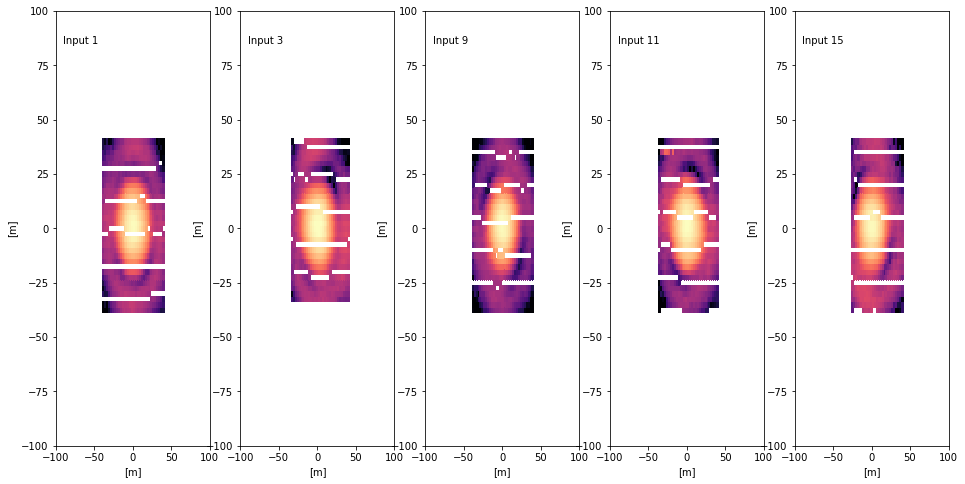

In [12]:
# check it looks sane

fig = plt.figure(figsize=(16,8))

# Npol flights
for p,chind in enumerate(pols):
    plt.subplot(1,5,p+1)
    plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],
               np.abs(beam.V_LC_operation[:,:,0,chind]),cmap=cm.magma,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-100,100)
    plt.ylim(-100,100)
    plt.text(-90,85,'Input '+str(chind))
    plt.xlabel('[m]')
    plt.ylabel('[m]')

plt.show()

In [13]:
#### LEAST SQUARES FITTING #####


#restr = 18
# read in all N pol co-adds

#print(good_freqs)
G_new_coadd = np.zeros([16,1024,6])
pG=np.array([1.0,0.0,8.0,0.0,8.0,1E-8])

# set which pol:
copoldir = 'N'
pols = N_pols


for j, chind in enumerate(pols): 
    mbx = beam.x_centers_grid[:,:,chind].flatten()
    mby = beam.y_centers_grid[:,:,chind].flatten()
    mbV = beam.V_LC_operation[:,:,0,chind].flatten()

    #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
    gi = np.where(np.isfinite(mbV))[0]
    input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
    G_new_coadd[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
    print(chind, m_to_FWHM(G_new_coadd[chind,find,2]),m_to_FWHM(G_new_coadd[chind,find,4]))


1 7.679223335006678 7.06668016746041
3 7.587727869464097 7.0583055783932505
9 6.972813852599914 6.784665801464937
11 8.043134677665527 7.266769431889723
15 7.166216357713661 6.849095299841568


In [14]:
G_new_coadd = np.zeros([16,1024,6])
pG=np.array([1.0,0.0,8.0,0.0,8.0,1E-8])
copoldir = 'N'
pols = N_pols

for find in good_freqs:
    print('Working on Frequency: ',find,freqs[find])

    flights = ['619']
    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in flights]

    beam=ba.Beammap_forautoprocessing(concatlist=concytest,
                 normalization='Gauss_wcorr',operation='coadd',mask=True,Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find,find+1,1])

    for j, chind in enumerate(pols): 
        mbx = beam.x_centers_grid[:,:,chind].flatten()
        mby = beam.y_centers_grid[:,:,chind].flatten()
        mbV = beam.V_LC_operation[:,:,0,chind].flatten()

        #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
        gi = np.where(np.isfinite(mbV))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        G_new_coadd[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
        #print(find, chind, m_to_FWHM(G_new_coadd[chind,find,2]),m_to_FWHM(G_new_coadd[chind,find,4]))

Working on Frequency:  538 589.84375
start of big ass loop is: 2024-02-01 09:30:55.053284
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:30:58.837907   
Working on Frequency:  553 583.984375
start of big ass loop is: 2024-02-01 09:31:02.833639
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:31:06.610182   
Working on Frequency:  554 583.59375
start of big ass loop is: 2024-02-01 09:31:10.444377
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:31:14.332800   
Working on Frequency:  556 582.8125
start of big ass loop is: 2024-02-01 09:31:18.178644
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:31:22.075893   
Working on Frequency:  557 582.4

Working on Frequency:  691 530.078125
start of big ass loop is: 2024-02-01 09:35:17.021942
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:35:20.820148   
Working on Frequency:  692 529.6875
start of big ass loop is: 2024-02-01 09:35:24.810066
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:35:28.598831   
Working on Frequency:  695 528.515625
start of big ass loop is: 2024-02-01 09:35:32.571916
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:35:36.362124   
Working on Frequency:  696 528.125
start of big ass loop is: 2024-02-01 09:35:40.178032
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:35:44.110520   
Working on Frequency:  697 527.73

Working on Frequency:  854 466.40625
start of big ass loop is: 2024-02-01 09:39:27.342238
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:39:29.985019   
Working on Frequency:  855 466.015625
start of big ass loop is: 2024-02-01 09:39:32.585794
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:39:35.109914   
Working on Frequency:  856 465.625
start of big ass loop is: 2024-02-01 09:39:37.827409
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:39:40.373233   
Working on Frequency:  857 465.234375
start of big ass loop is: 2024-02-01 09:39:43.026696
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:39:45.552760   
Working on Frequency:  858 464.8

Working on Frequency:  896 450.0
start of big ass loop is: 2024-02-01 09:42:26.936633
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:42:29.593882   
Working on Frequency:  899 448.828125
start of big ass loop is: 2024-02-01 09:42:32.136933
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:42:34.732158   
Working on Frequency:  900 448.4375
start of big ass loop is: 2024-02-01 09:42:37.237515
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:42:39.750008   
Working on Frequency:  902 447.65625
start of big ass loop is: 2024-02-01 09:42:42.333241
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:42:44.830171   
Working on Frequency:  903 447.26562

Working on Frequency:  937 433.984375
start of big ass loop is: 2024-02-01 09:45:22.211805
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:45:24.741403   
Working on Frequency:  938 433.59375
start of big ass loop is: 2024-02-01 09:45:27.342070
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:45:29.985254   
Working on Frequency:  939 433.203125
start of big ass loop is: 2024-02-01 09:45:32.575557
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-01 09:45:35.210470   


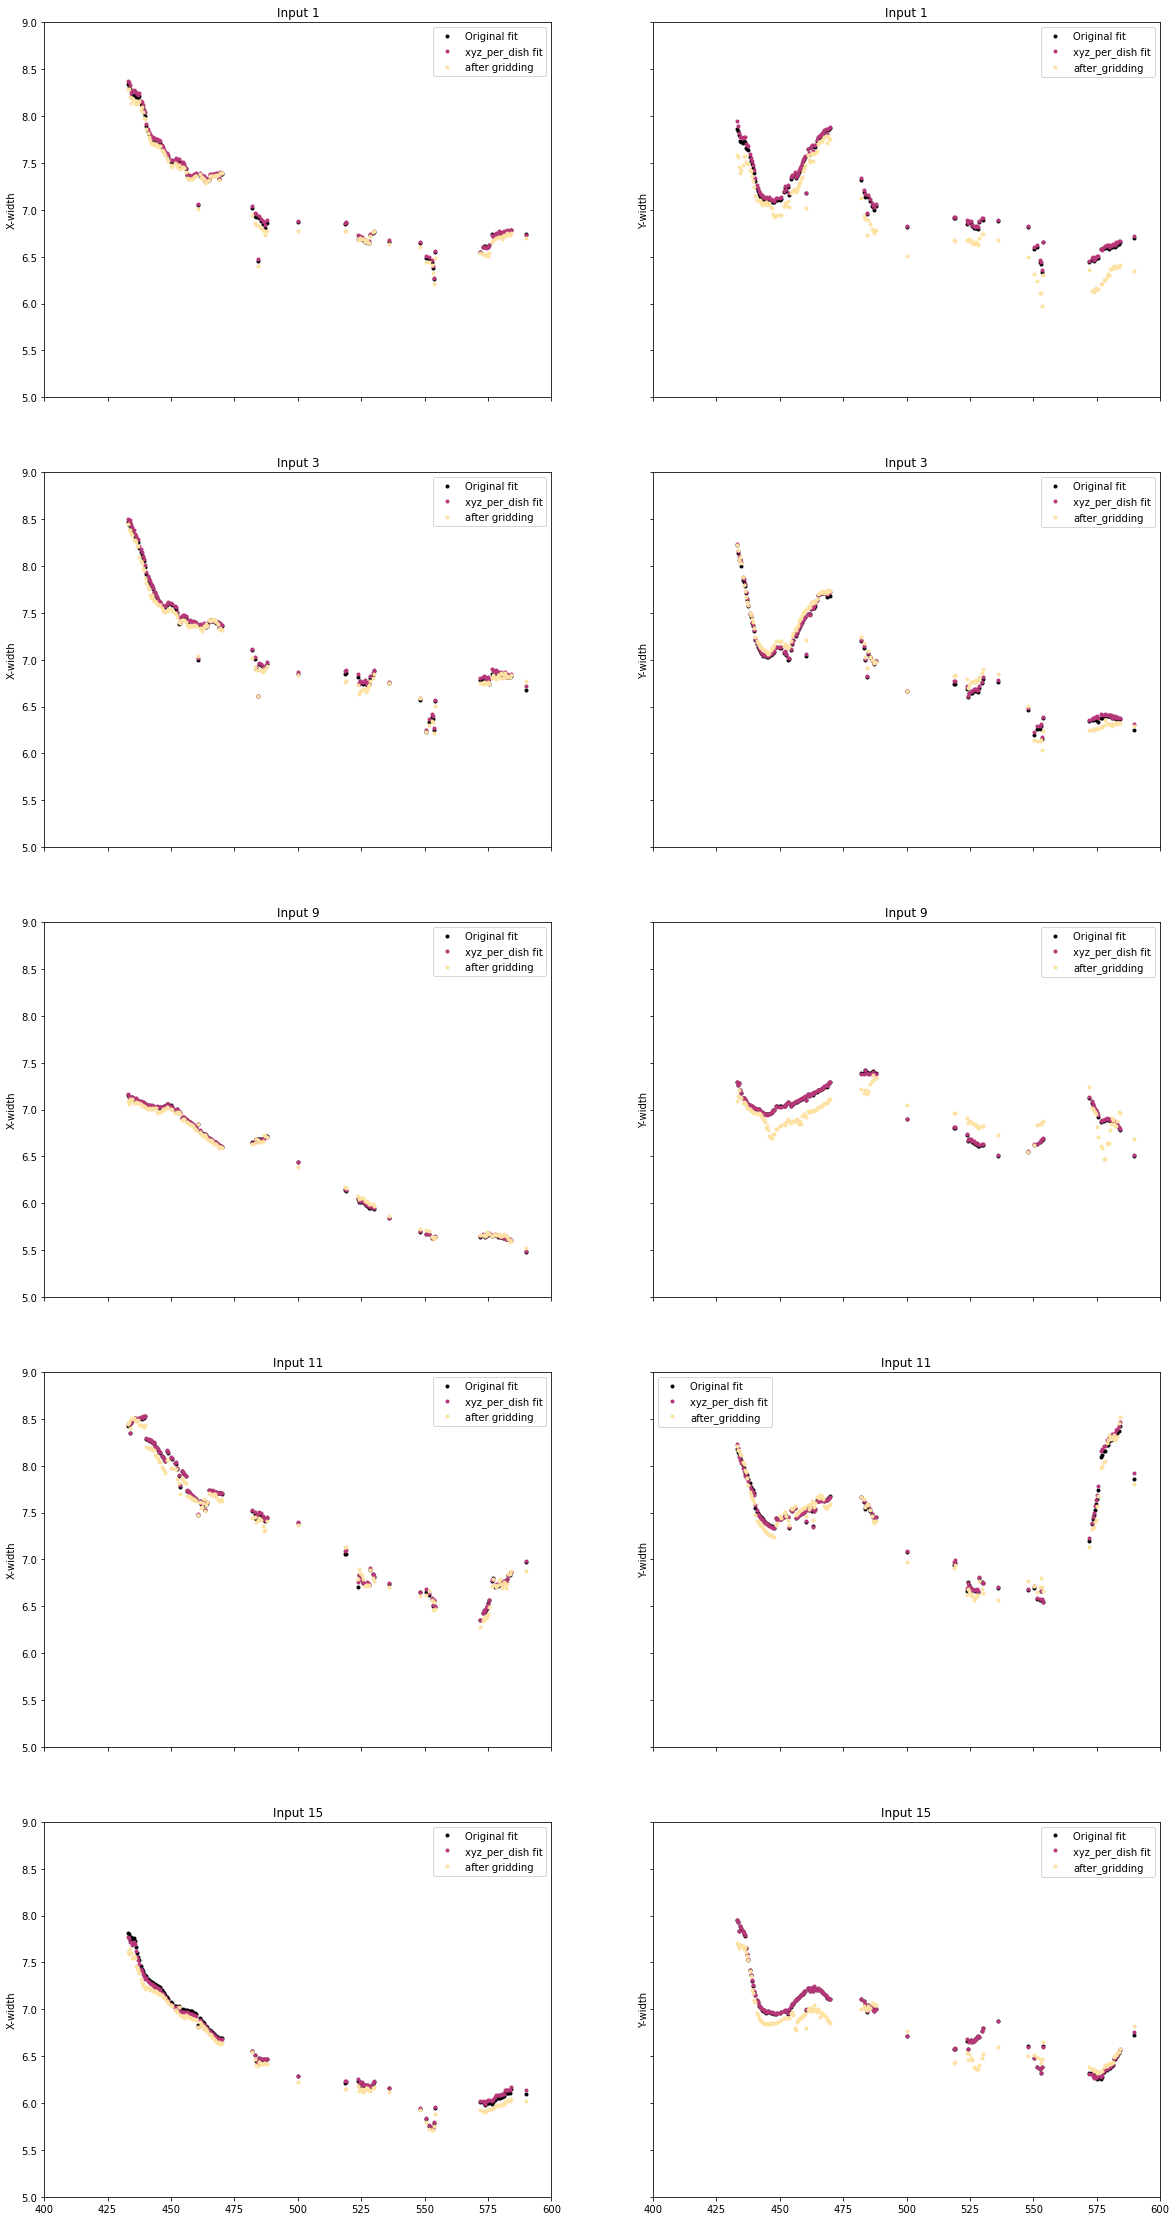

In [15]:
fig,axs = plt.subplots(5,2, sharex=True,sharey=True,figsize=(20,40))

for i,chind in enumerate(N_pols):
    axs[i,0].plot(freqs[good_freqs],m_to_FWHM(fl625.G_popt[chind,good_freqs,2]),color=colorz[0],
                  marker='.',linestyle='None',label='Original fit')
    axs[i,1].plot(freqs[good_freqs],m_to_FWHM(fl625.G_popt[chind,good_freqs,4]),color=colorz[0],
                  marker='.',linestyle='None',label='Original fit')
    
    
    axs[i,0].plot(freqs[good_freqs],m_to_FWHM(abs(Gpopt_new[chind,good_freqs,2])),color=colorz[8],
                  marker='.',linestyle='None',label='xyz_per_dish fit')        
    axs[i,1].plot(freqs[good_freqs],m_to_FWHM(abs(Gpopt_new[chind,good_freqs,4])),color=colorz[8],
                  marker='.',linestyle='None',label='xyz_per_dish fit')
    
    axs[i,0].plot(freqs[good_freqs],m_to_FWHM(G_new_coadd[chind,good_freqs,2]),color=colorz[15],
                  marker='.',linestyle='None',label='after gridding')        
    axs[i,1].plot(freqs[good_freqs],m_to_FWHM(G_new_coadd[chind,good_freqs,4]),color=colorz[15],
                  marker='.',linestyle='None',label='after_gridding')
    
    axs[i,0].legend()
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X-width')
    axs[i,0].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
    axs[i,1].legend()
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('Y-width')
    axs[i,1].set_ylim(5,9)
    axs[i,1].set_xlim(400,600)
plt.show()




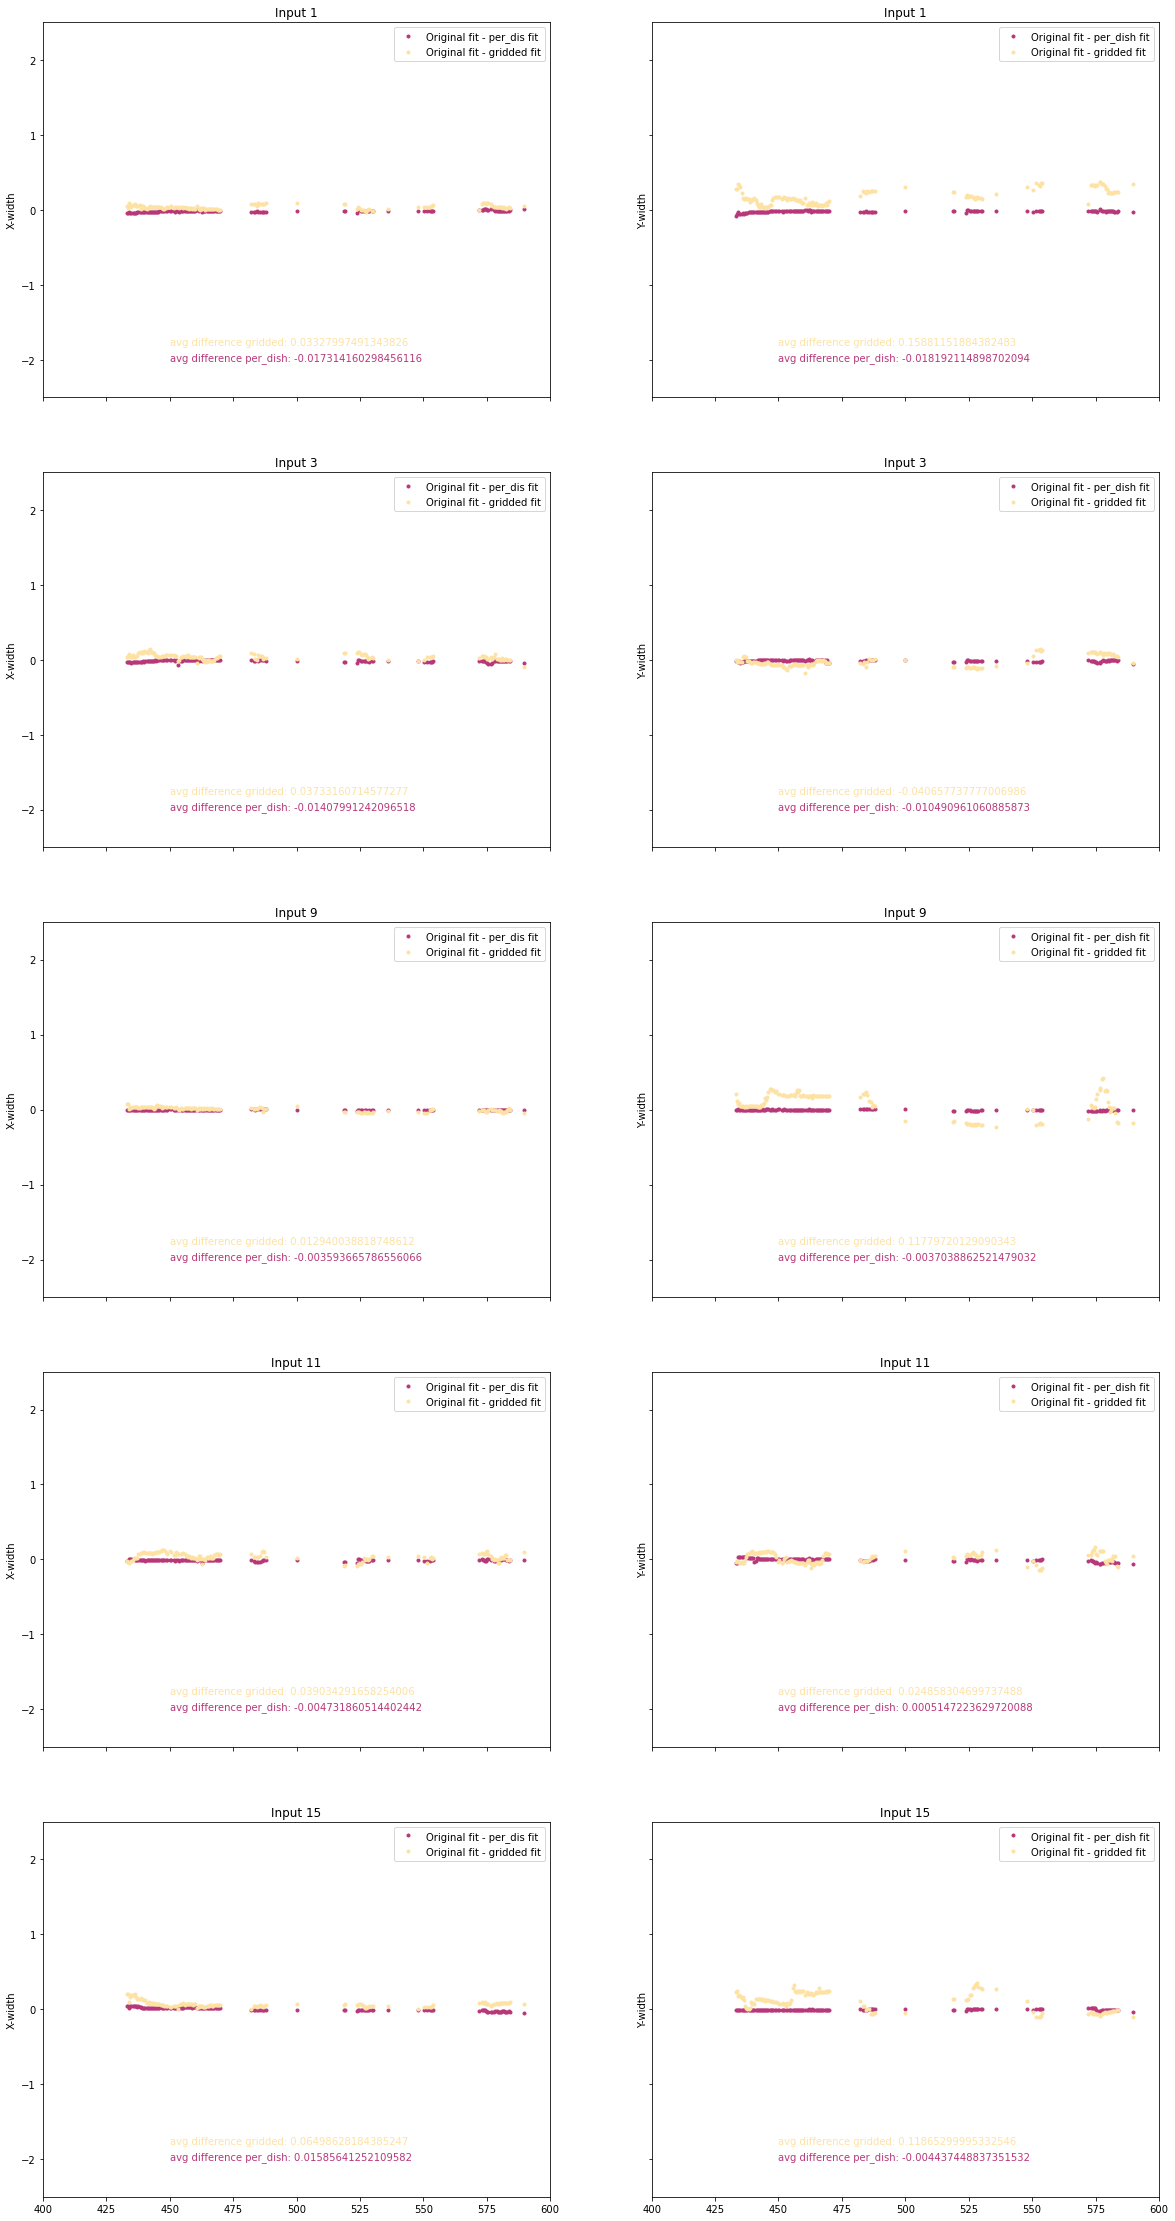

In [16]:
fig,axs = plt.subplots(5,2, sharex=True,sharey=True,figsize=(20,40))

for i,chind in enumerate(N_pols):
    
    axs[i,0].plot(freqs[good_freqs],
                  m_to_FWHM(fl625.G_popt[chind,good_freqs,2])-m_to_FWHM(abs(Gpopt_new[chind,good_freqs,2])),
                  color=colorz[8],marker='.',linestyle='None',label='Original fit - per_dis fit')
    axs[i,1].plot(freqs[good_freqs],
                  m_to_FWHM(fl625.G_popt[chind,good_freqs,4])-m_to_FWHM(abs(Gpopt_new[chind,good_freqs,4])),
                  color=colorz[8],marker='.',linestyle='None',label='Original fit - per_dish fit')
    axs[i,0].plot(freqs[good_freqs],
                  m_to_FWHM(fl625.G_popt[chind,good_freqs,2])-m_to_FWHM(abs(G_new_coadd[chind,good_freqs,2])),
                  color=colorz[15],marker='.',linestyle='None',label='Original fit - gridded fit')
    axs[i,1].plot(freqs[good_freqs],
                  m_to_FWHM(fl625.G_popt[chind,good_freqs,4])-m_to_FWHM(abs(G_new_coadd[chind,good_freqs,4])),
                  color=colorz[15],marker='.',linestyle='None',label='Original fit - gridded fit')
    
    axs[i,0].legend()
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X-width')
    axs[i,0].set_ylim(-2.5,2.5)
    axs[i,0].set_xlim(400,600)
    axs[i,1].legend()
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('Y-width')
    axs[i,1].set_ylim(-2.5,2.5)
    axs[i,1].set_xlim(400,600)
    axs[i,0].text(450,-2,'avg difference per_dish: '+str(np.median(
        m_to_FWHM(fl625.G_popt[chind,good_freqs,2])-m_to_FWHM(abs(Gpopt_new[chind,good_freqs,2])))),
                 color=colorz[8])
    axs[i,1].text(450,-2,'avg difference per_dish: '+str(np.median(
        m_to_FWHM(fl625.G_popt[chind,good_freqs,4])-m_to_FWHM(abs(Gpopt_new[chind,good_freqs,4])))),
                 color=colorz[8])
    axs[i,0].text(450,-1.8,'avg difference gridded: '+str(np.median(
        m_to_FWHM(fl625.G_popt[chind,good_freqs,2])-m_to_FWHM(abs(G_new_coadd[chind,good_freqs,2])))),
                 color=colorz[15])
    axs[i,1].text(450,-1.8,'avg difference gridded: '+str(np.median(
        m_to_FWHM(fl625.G_popt[chind,good_freqs,4])-m_to_FWHM(abs(G_new_coadd[chind,good_freqs,4])))),
                 color=colorz[15])
plt.show()

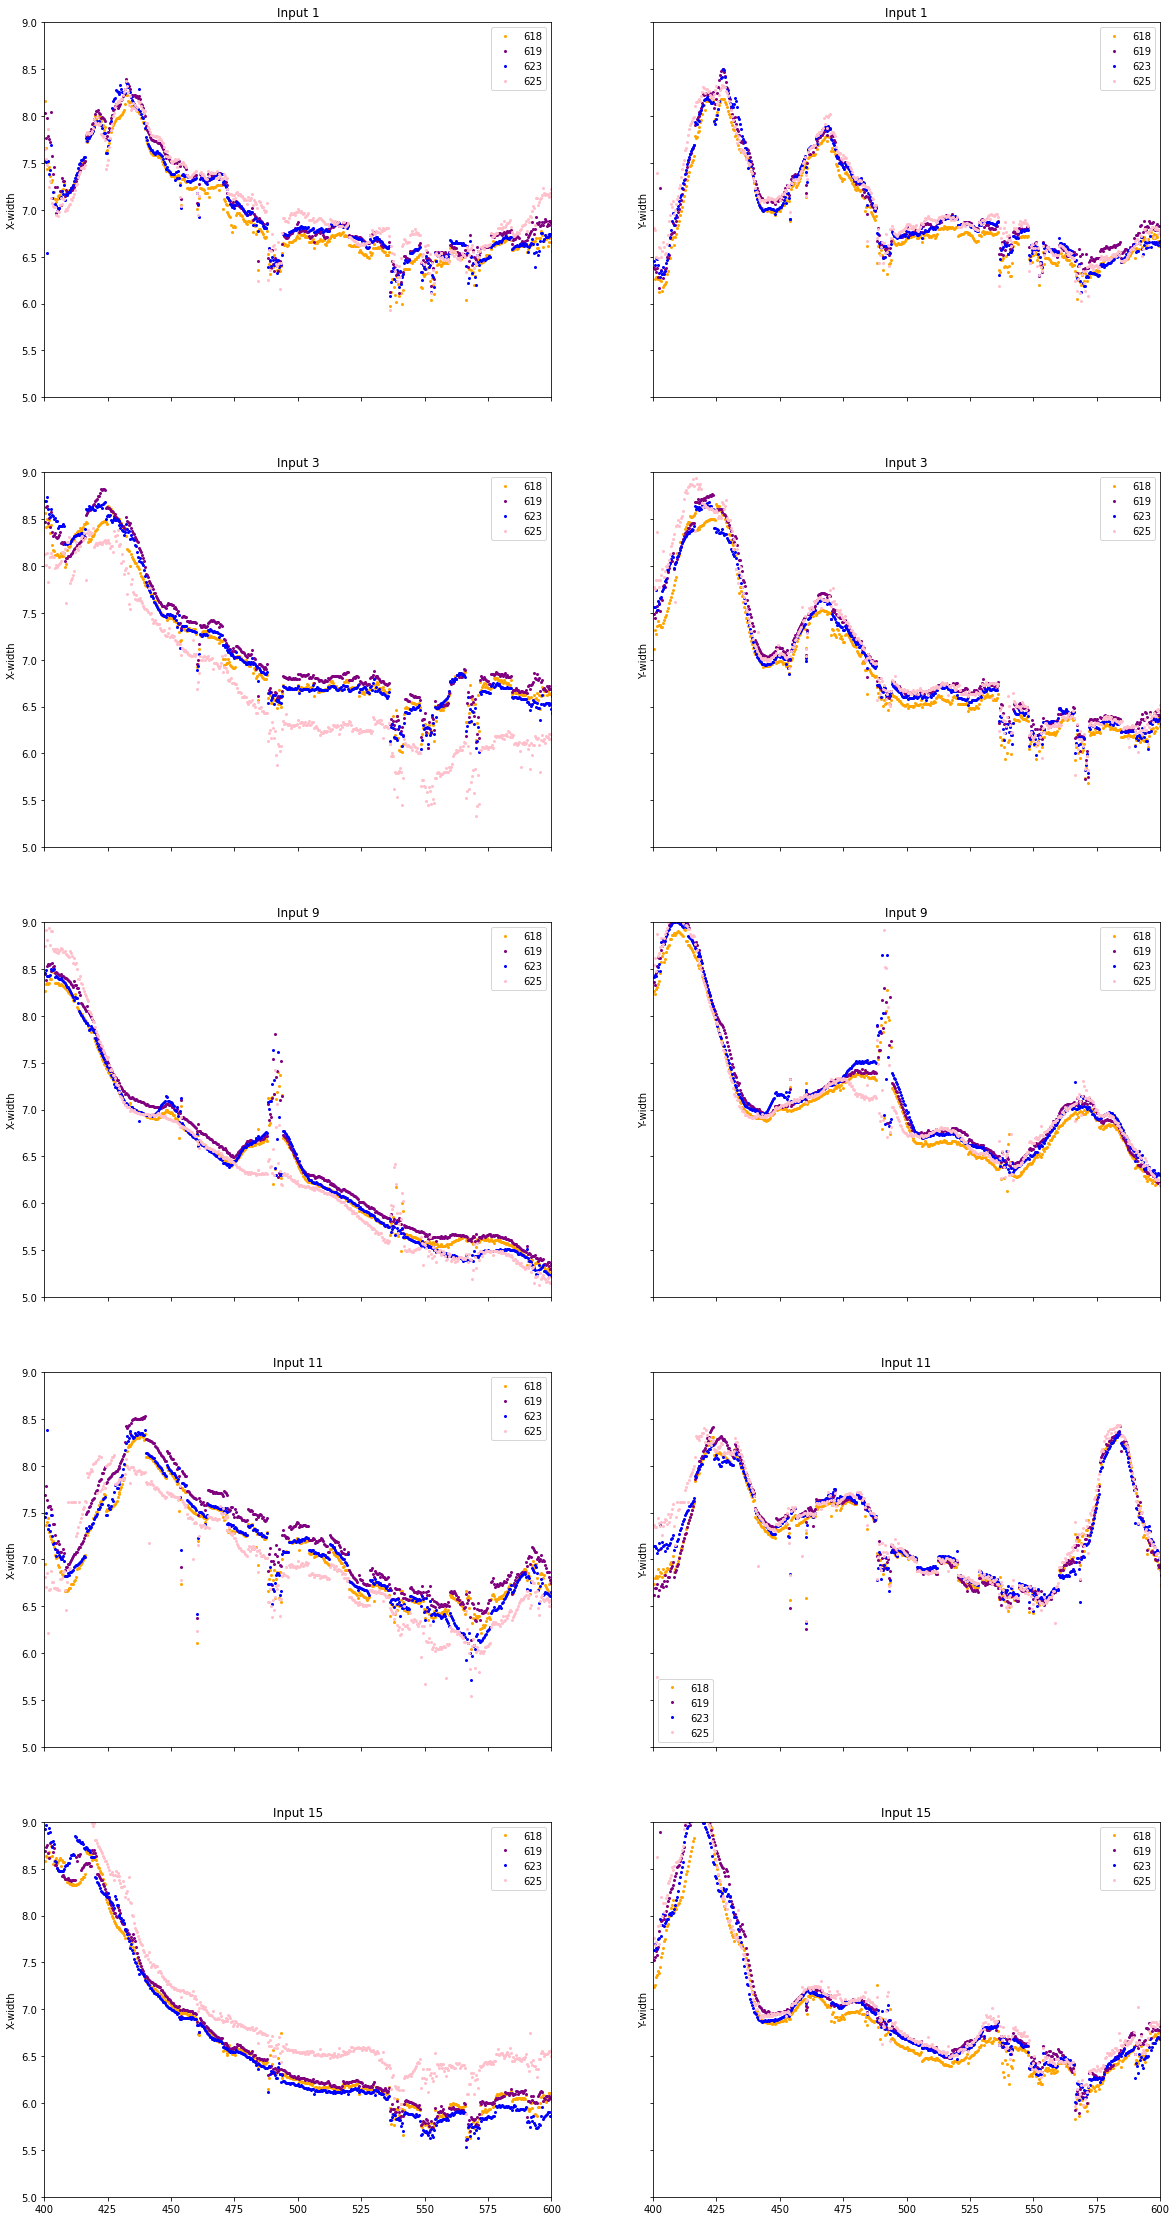

In [20]:
colorz=pu.cm_to_discrete(ccm, 16)
colorf=['orange','purple','blue','pink']
fig,axs = plt.subplots(5,2, sharex=True,sharey=True,figsize=(20,40))

for i,chind in enumerate(N_pols):
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,0].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,2])),
                 markersize=4,marker='.',color=colorf[f],linestyle='None',label=fly)
    axs[i,0].legend()
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X-width')
    axs[i,0].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
    #plt.show()
for i,chind in enumerate(N_pols):
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,1].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,4])),
                 markersize=4,marker='.',color=colorf[f],linestyle='None',label=fly)
    axs[i,1].legend()
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('Y-width')
    axs[i,1].set_ylim(5,9)
    axs[i,1].set_xlim(400,600)
    #plt.show()

In [ ]:
colorz=pu.cm_to_discrete(ccm, 16)
colorf=['orange','purple','blue','pink']
fig,axs = plt.subplots(5,2, sharex=True,sharey=True,figsize=(20,40))

for i,chind in enumerate(N_pols):
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,0].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,2])),
                 markersize=4,marker='.',color=colorf[f],linestyle='None',label=fly)
    axs[i,0].legend()
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X-width')
    axs[i,0].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
    #plt.show()
for i,chind in enumerate(N_pols):
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,1].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,4])),
                 markersize=4,marker='.',color=colorf[f],linestyle='None',label=fly)
    axs[i,1].legend()
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('Y-width')
    axs[i,1].set_ylim(5,9)
    axs[i,1].set_xlim(400,600)
    #plt.show()

# Compare emcee fits with averages and coadds

In [ ]:
coadded_orig = np.load('/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_and_Airy_Param_2023_12_14.npz')
coadded = np.load('/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_and_Airy_Param_2023_12_17_wlim.npz')
list(coadded.keys())
print(coadded['G_popt'][1,900,:,0]) # ch,fr,param

avg = np.load('/hirax/GBO_Analysis_Outputs/Averaged_2dGauss_and_Airy_Param.npz')

with open('/hirax/GBO_Analysis_Outputs/emcee_fits.pkl', 'rb') as inp:
    emcfile = pickle.load(inp)

[ 1.01230336 -0.05468336  9.58880537 -0.08684378  9.02605378  0.01601914]


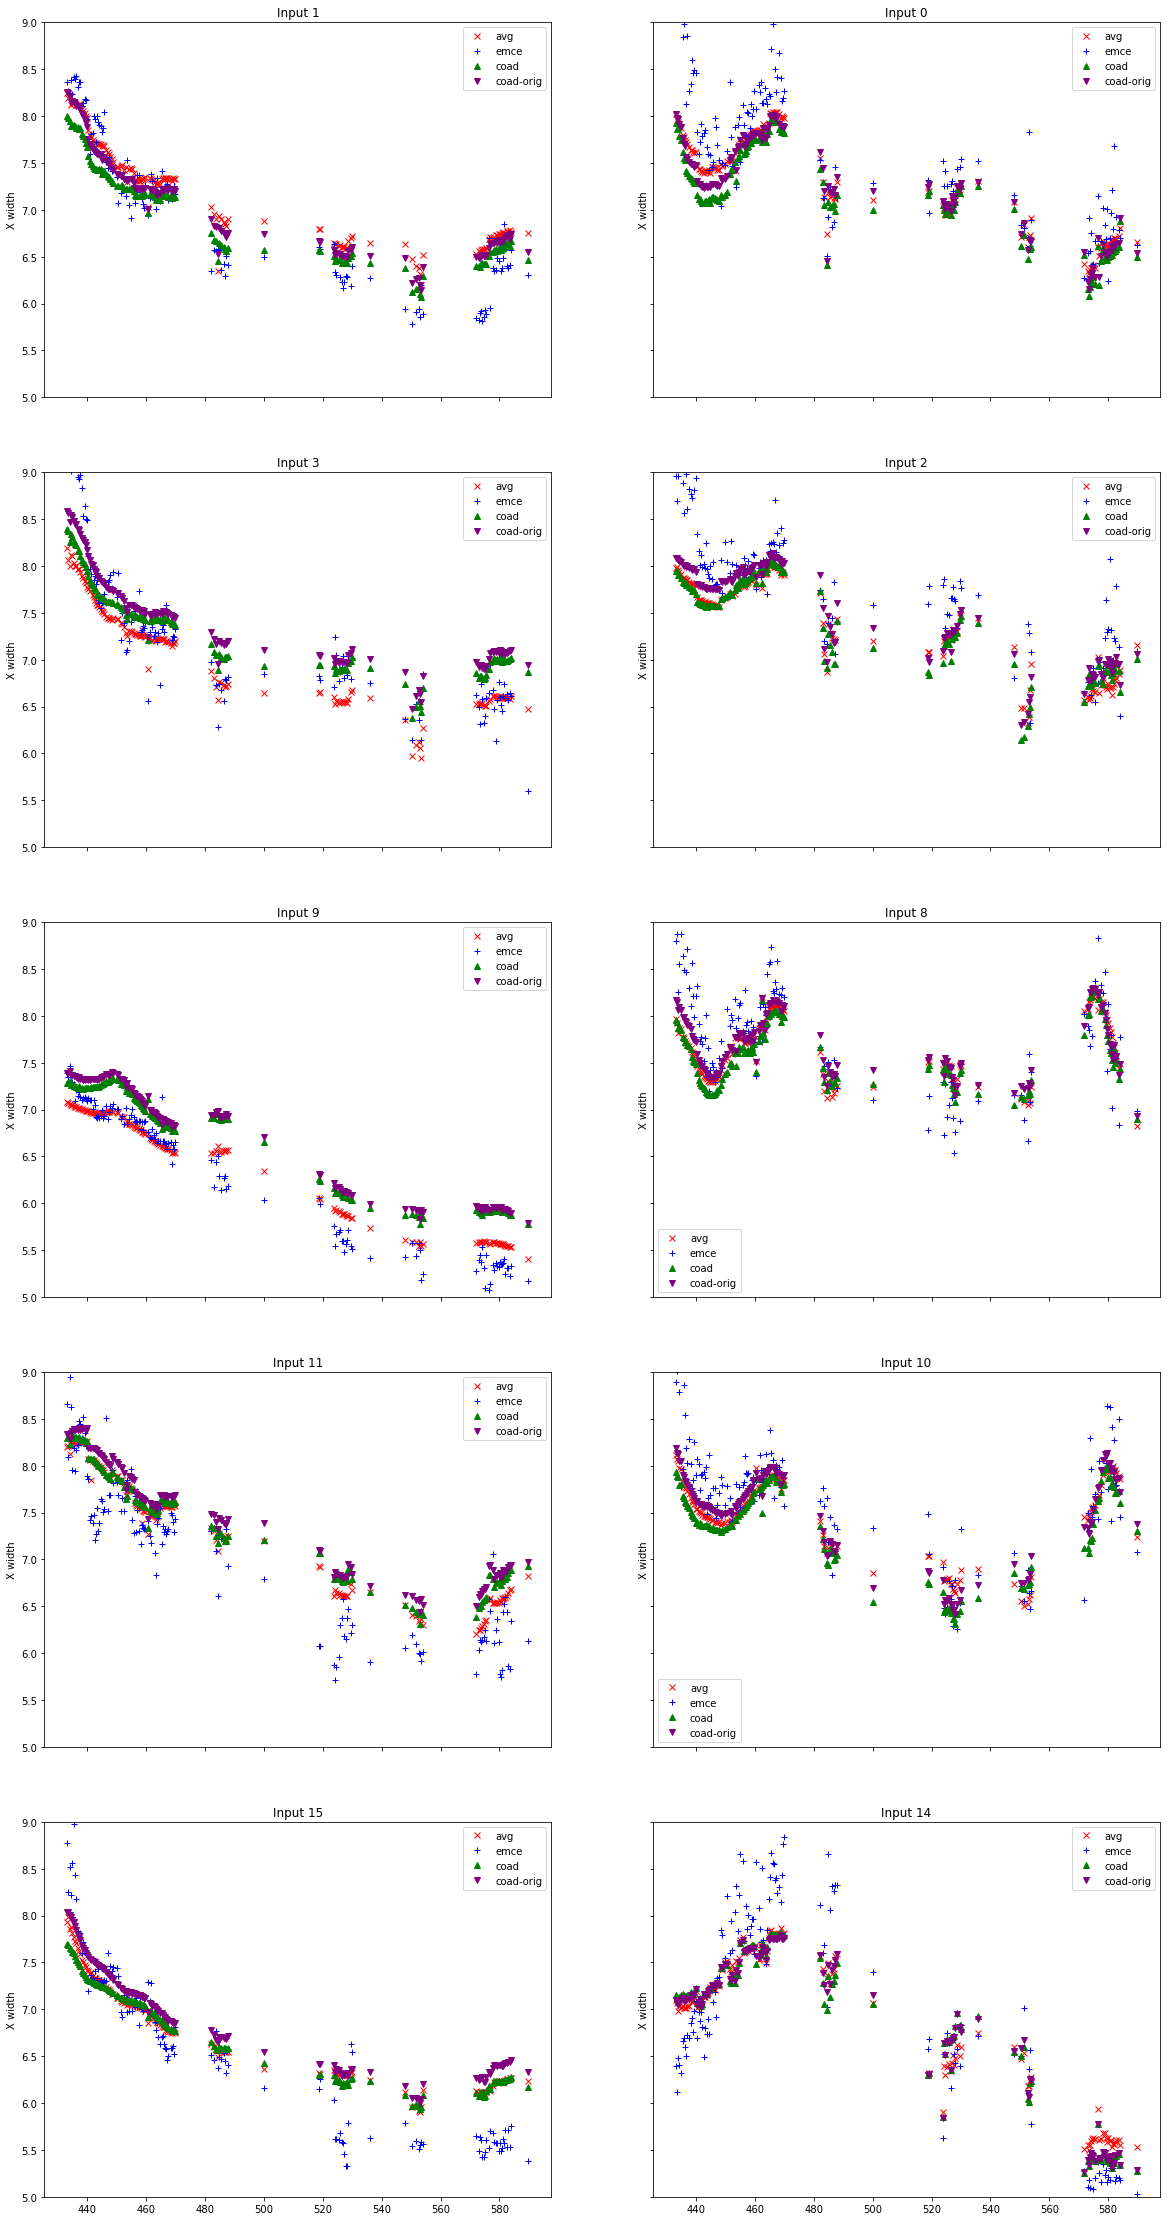

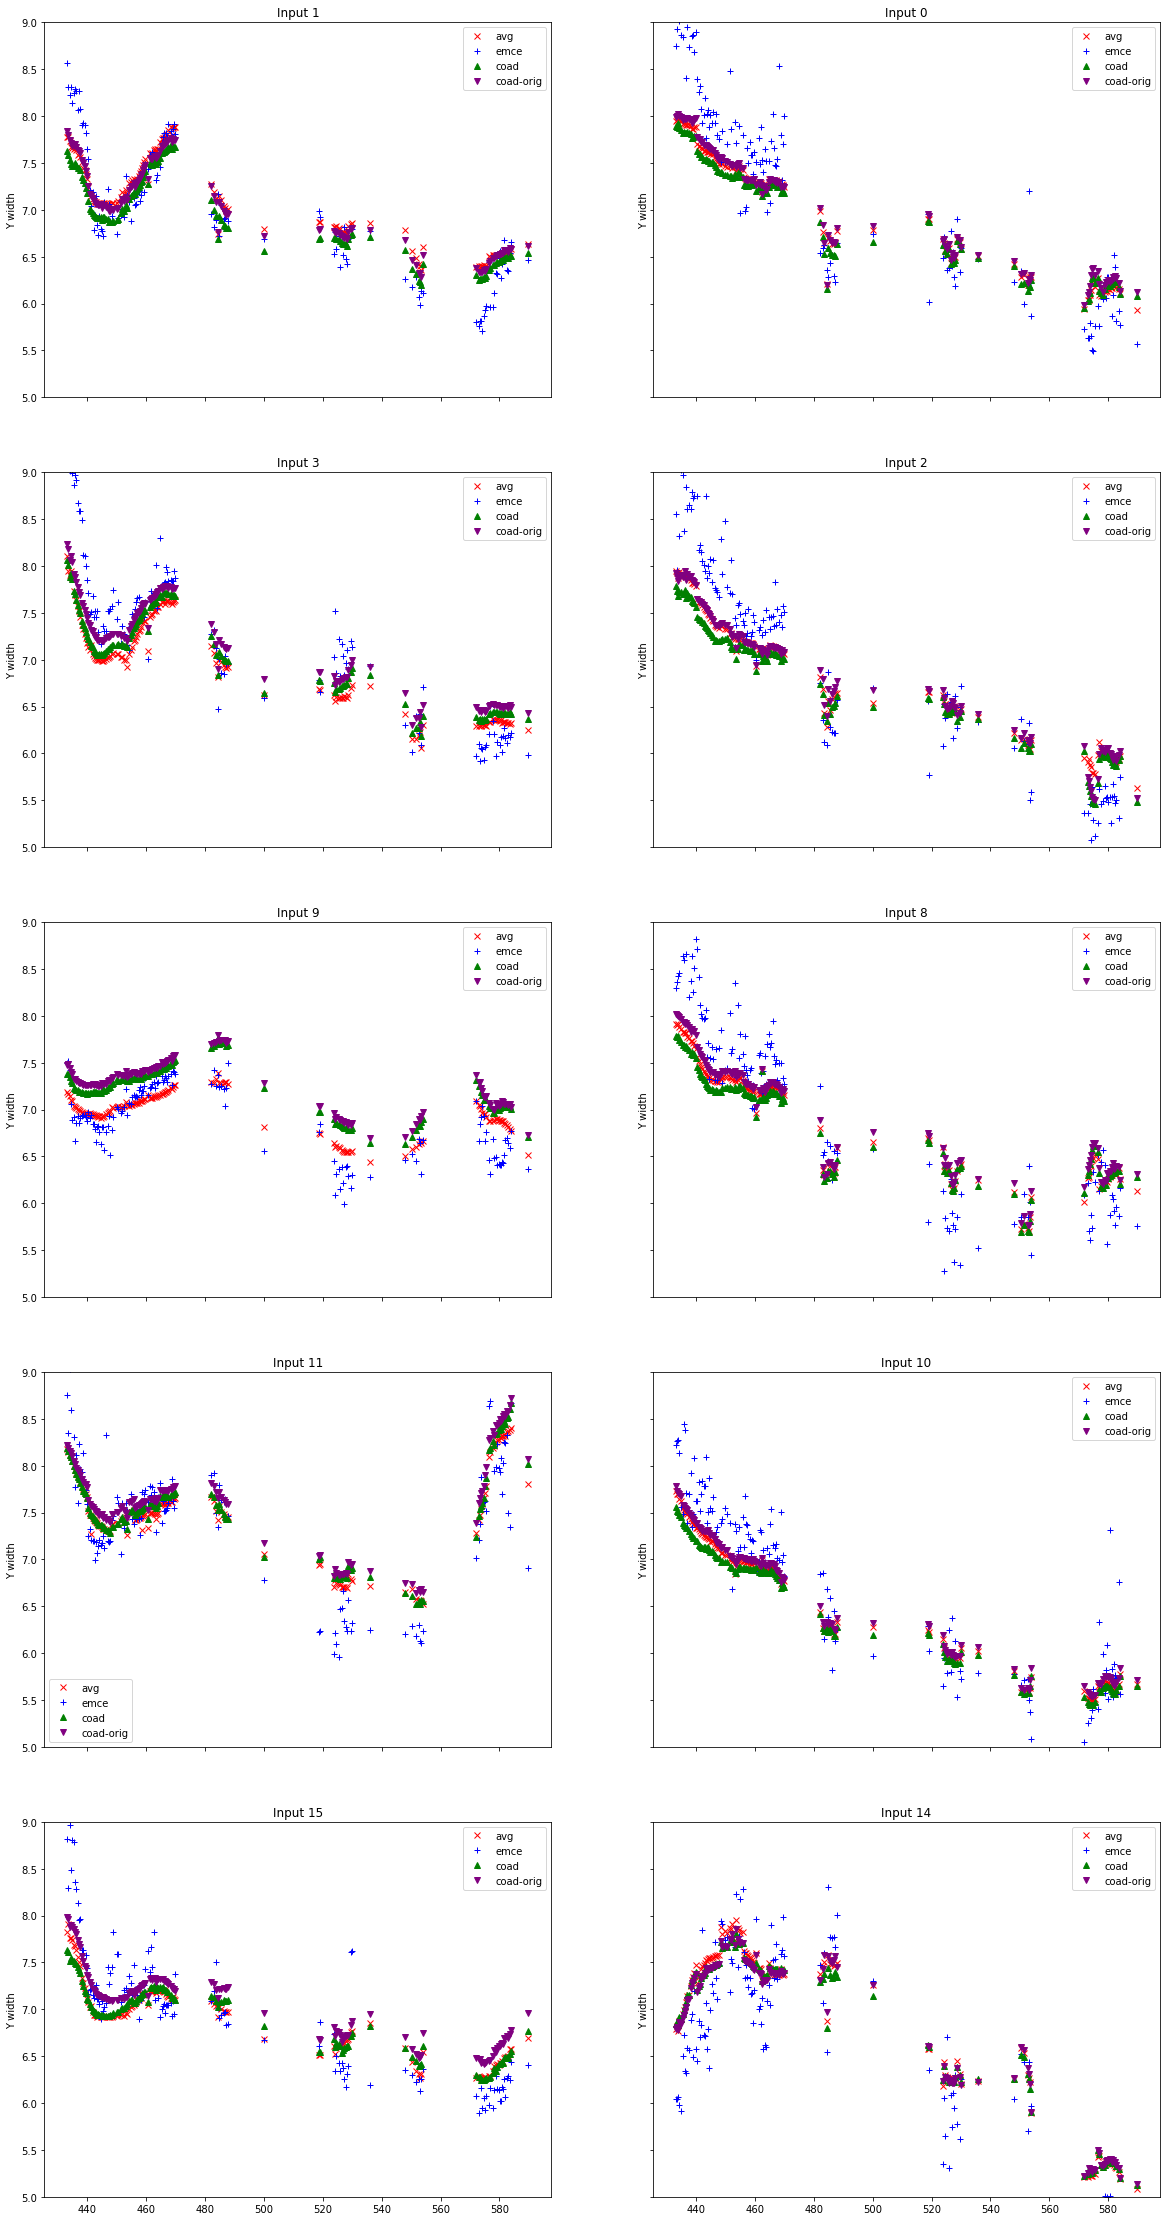

In [39]:
colorz=pu.cm_to_discrete(ccm, 16)
fig,axs = plt.subplots(5,2, sharex=True,sharey=True,figsize=(20,40))
for i,chind in enumerate(N_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][chind,good_freqs,2,0])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,chind,2,0]))
    yc = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][chind,good_freqs,2,0])))
    oc = convert_sig_to_FWHM((convert_to_angle(coadded_orig['G_popt'][chind,good_freqs,2,0])))
    axs[i,0].plot(freqs[good_freqs],ys,marker='x',linestyle='None',color='red',label='avg')
    axs[i,0].plot(freqs[good_freqs],mcs,marker='+',linestyle='None',color='blue',label='emce')
    axs[i,0].plot(freqs[good_freqs],yc,marker='^',linestyle='None',color='green',label='coad')
    axs[i,0].plot(freqs[good_freqs],oc,marker='v',linestyle='None',color='purple',label='coad-orig')
    axs[i,0].legend()
    axs[i,0].legend()
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylim(5,9)
    axs[i,0].set_ylabel('X width')
    #plt.show()
    
for i,chind in enumerate(E_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][chind,good_freqs,2,0])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,chind,2,0]))
    yc = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][chind,good_freqs,2,0])))
    oc = convert_sig_to_FWHM((convert_to_angle(coadded_orig['G_popt'][chind,good_freqs,2,0])))
    axs[i,1].plot(freqs[good_freqs],ys,marker='x',linestyle='None',color='red',label='avg')
    axs[i,1].plot(freqs[good_freqs],mcs,marker='+',linestyle='None',color='blue',label='emce')
    axs[i,1].plot(freqs[good_freqs],yc,marker='^',linestyle='None',color='green',label='coad')
    axs[i,1].plot(freqs[good_freqs],oc,marker='v',linestyle='None',color='purple',label='coad-orig')
    axs[i,1].legend()
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylim(5,9)
    axs[i,1].set_ylabel('X width')
plt.show()


colorz=pu.cm_to_discrete(ccm, 16)
fig,axs = plt.subplots(5,2, sharex=True,sharey=True,figsize=(20,40))
for i,chind in enumerate(N_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][chind,good_freqs,4,0])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,chind,4,0]))
    yc = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][chind,good_freqs,4,0])))
    oc = convert_sig_to_FWHM((convert_to_angle(coadded_orig['G_popt'][chind,good_freqs,4,0])))
    axs[i,0].plot(freqs[good_freqs],ys,marker='x',linestyle='None',color='red',label='avg')
    axs[i,0].plot(freqs[good_freqs],mcs,marker='+',linestyle='None',color='blue',label='emce')
    axs[i,0].plot(freqs[good_freqs],yc,marker='^',linestyle='None',color='green',label='coad')
    axs[i,0].plot(freqs[good_freqs],oc,marker='v',linestyle='None',color='purple',label='coad-orig')
    axs[i,0].legend()
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylim(5,9)
    axs[i,0].set_ylabel('Y width')
    #plt.show()
    
for i,chind in enumerate(E_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][chind,good_freqs,4,0])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,chind,4,0]))
    yc = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][chind,good_freqs,4,0])))
    oc = convert_sig_to_FWHM((convert_to_angle(coadded_orig['G_popt'][chind,good_freqs,4,0])))
    axs[i,1].plot(freqs[good_freqs],ys,marker='x',linestyle='None',color='red',label='avg')
    axs[i,1].plot(freqs[good_freqs],mcs,marker='+',linestyle='None',color='blue',label='emce')
    axs[i,1].plot(freqs[good_freqs],yc,marker='^',linestyle='None',color='green',label='coad')
    axs[i,1].plot(freqs[good_freqs],oc,marker='v',linestyle='None',color='purple',label='coad-orig')
    axs[i,1].legend()
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylim(5,9)
    axs[i,1].set_ylabel('Y width')
plt.show()

## Lets plot each flight to compare to average/co-add

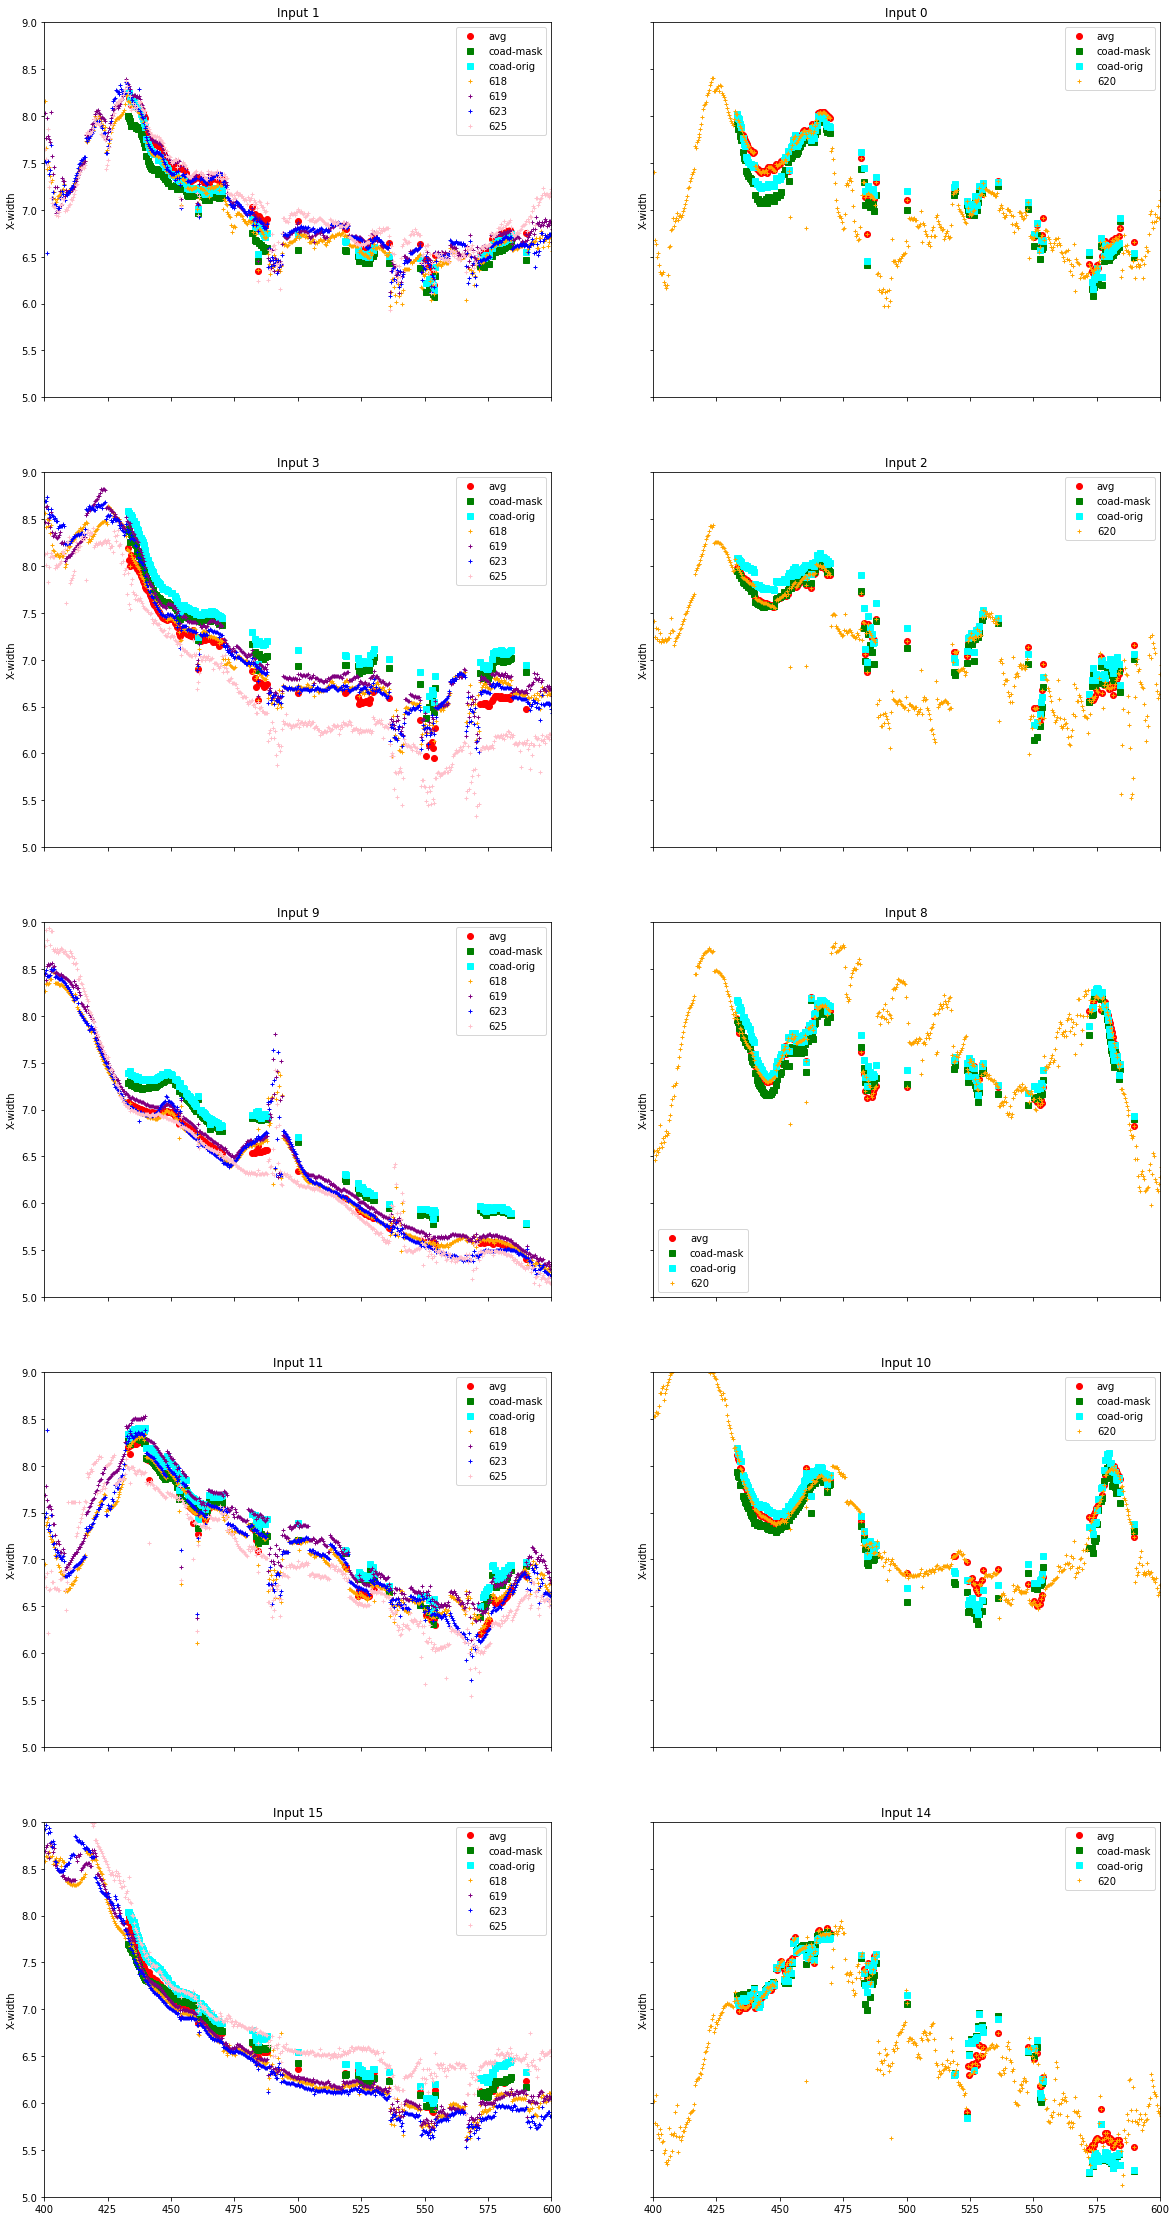

In [40]:
colorz=pu.cm_to_discrete(ccm, 16)
colorf=['orange','purple','blue','pink']
fig,axs = plt.subplots(5,2, sharex=True,sharey=True,figsize=(20,40))

for i,chind in enumerate(N_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][chind,good_freqs,2,0])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,chind,2,0]))
    yc = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][chind,good_freqs,2,0])))
    oc = convert_sig_to_FWHM((convert_to_angle(coadded_orig['G_popt'][chind,good_freqs,2,0])))
    axs[i,0].plot(freqs[good_freqs],ys,marker='o',linestyle='None',color='red',label='avg')
    #plt.plot(freqs[good_freqs],mcs,marker='+',linestyle='None',color='blue',label='emce')
    axs[i,0].plot(freqs[good_freqs],yc,marker='s',linestyle='None',color='green',label='coad-mask')
    axs[i,0].plot(freqs[good_freqs],oc,marker='s',linestyle='None',color='cyan',label='coad-orig')
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,0].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,2])),
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,0].legend()
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X-width')
    axs[i,0].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
    #plt.show()
    
for i,chind in enumerate(E_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][chind,good_freqs,2,0])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,chind,2,0]))
    yc = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][chind,good_freqs,2,0])))
    oc = convert_sig_to_FWHM((convert_to_angle(coadded_orig['G_popt'][chind,good_freqs,2,0])))
    axs[i,1].plot(freqs[good_freqs],ys,marker='o',linestyle='None',color='red',label='avg')
    #plt.plot(freqs[good_freqs],mcs,marker='+',linestyle='None',color='blue',label='emce')
    axs[i,1].plot(freqs[good_freqs],yc,marker='s',linestyle='None',color='green',label='coad-mask')
    axs[i,1].plot(freqs[good_freqs],oc,marker='s',linestyle='None',color='cyan',label='coad-orig')
    for f,fly in enumerate(['620']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,1].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,2])),
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,1].legend()
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('X-width')
    axs[i,1].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
plt.show()

# Compare with Pranav and Sims -- EW transit, should match X width

(2, 970)
(970,)
448.4375 448.4375


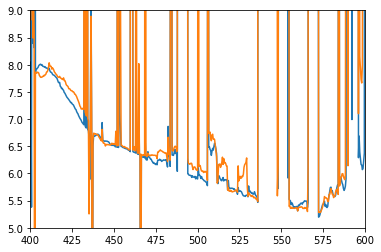

In [34]:
fwhm_pra = np.load('/hirax/GBO_Analysis_Outputs/fwhm_pranav.npz') # fwhm, freq
print(fwhm_pra['fwhm'].shape)
print(fwhm_pra['freq'].shape)
print(fwhm_pra['freq'][846],freqs[900])

plt.plot(fwhm_pra['freq'],fwhm_pra['fwhm'][0,:])
plt.plot(fwhm_pra['freq'],fwhm_pra['fwhm'][1,:])
plt.ylim(5,9)
plt.xlim(400,600)
plt.show()

In [35]:
fwhm_freq = [400,450,500,550,600]
fwhm_sim_h_phi90 = [8.9,7.9,6.7,6.1,5.5]
fwhm_sim_h_phi0 = [7.7, 6.9, 6.3, 5.8, 5.3]

NameError: name 'colorf' is not defined

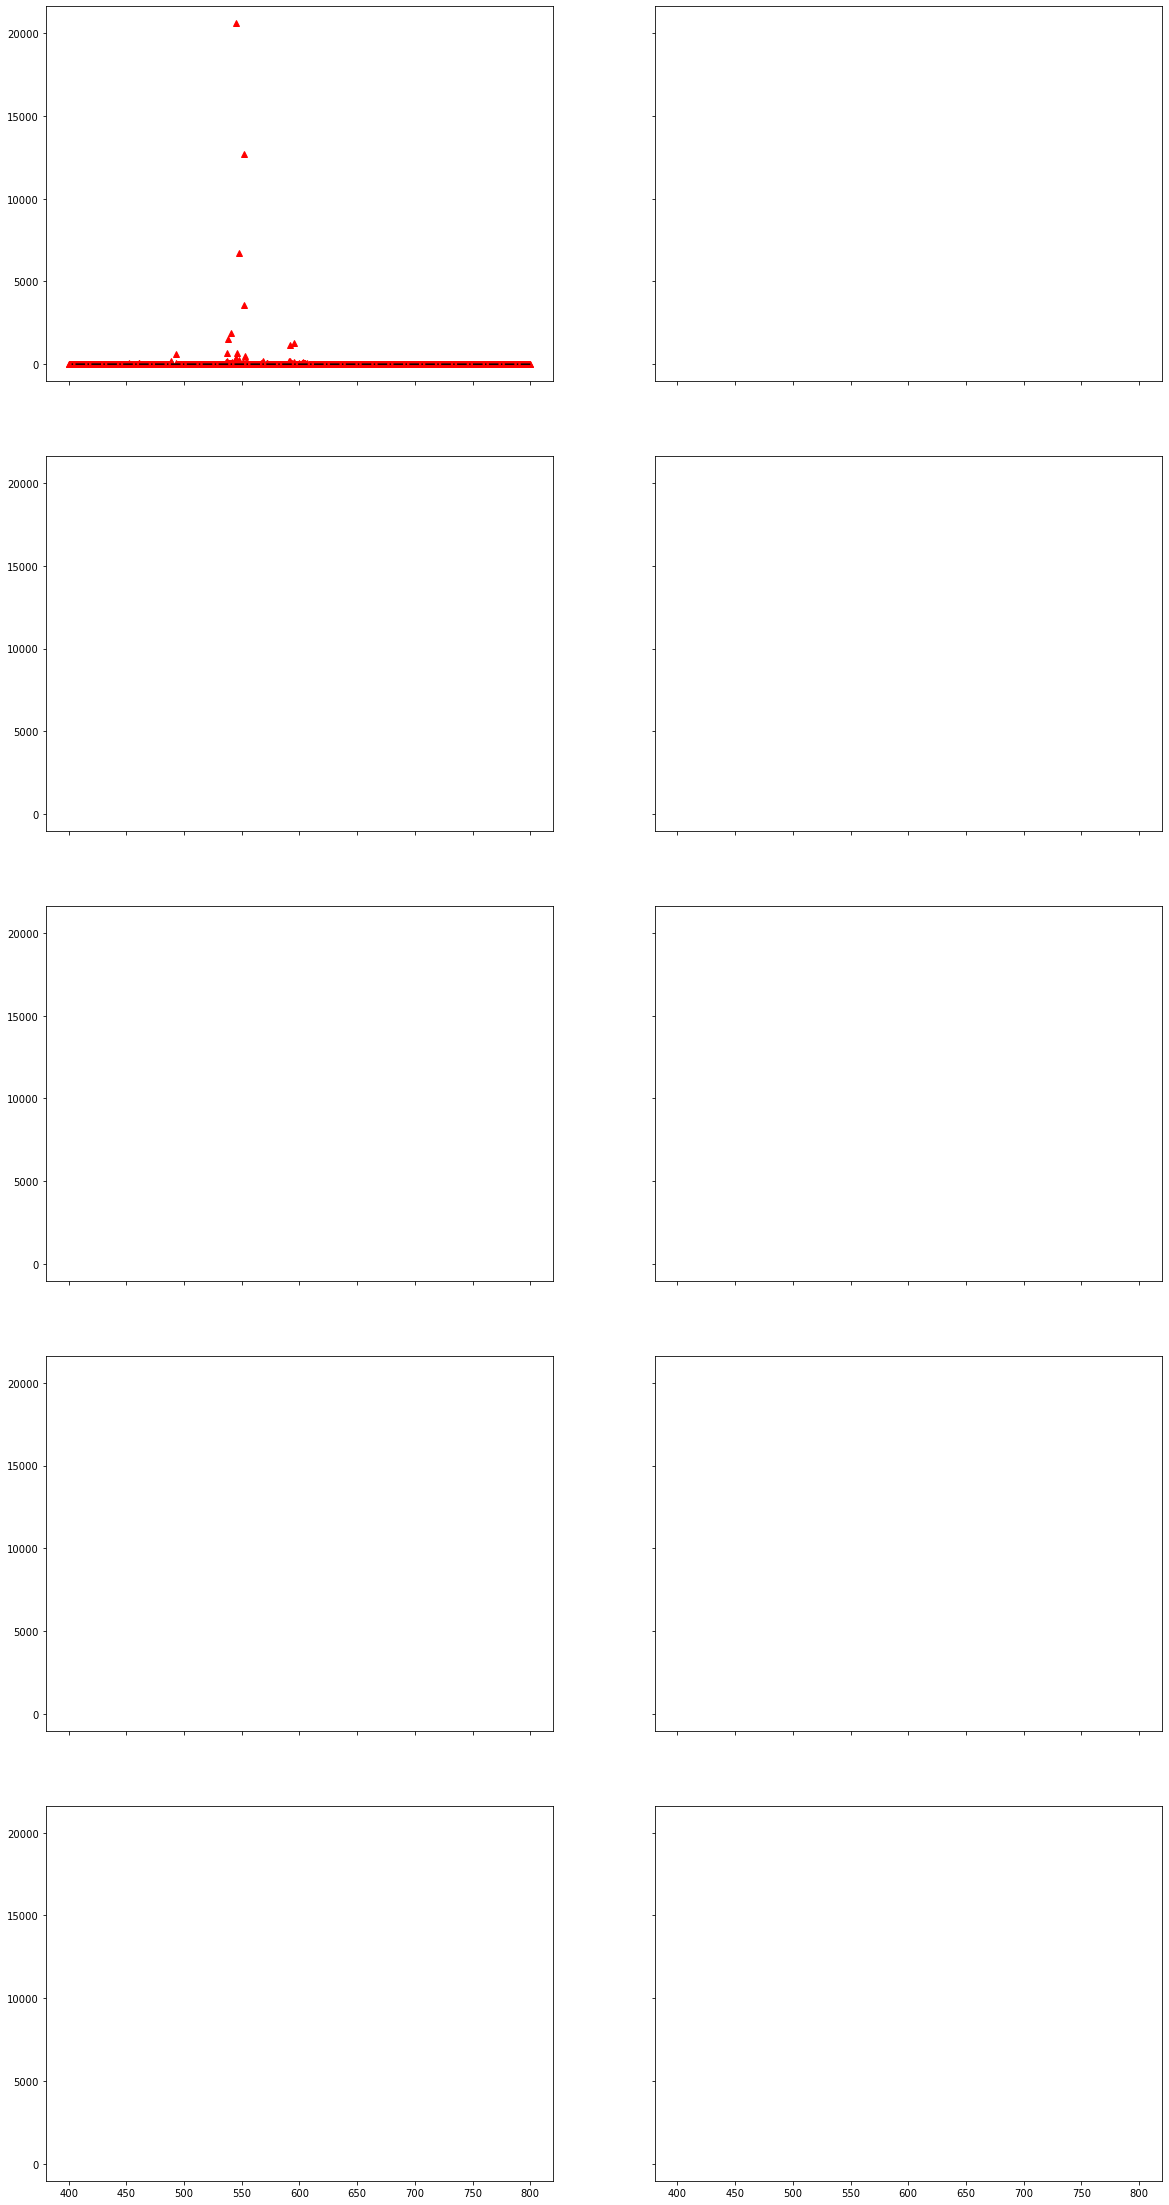

In [38]:
colorz=pu.cm_to_discrete(ccm, 16)
fig,axs = plt.subplots(5,2, sharex=True,sharey=True,figsize=(20,40))

for i,chind in enumerate(N_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][chind,good_freqs,2,0])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,chind,2,0]))
    yc = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][chind,good_freqs,2,0])))
    oc = convert_sig_to_FWHM((convert_to_angle(coadded_orig['G_popt'][chind,good_freqs,2,0])))
    axs[i,0].plot(freqs[good_freqs],ys,marker='o',linestyle='None',color='red',label='avg')
    #plt.plot(freqs[good_freqs],mcs,marker='+',linestyle='None',color='blue',label='emce')
    axs[i,0].plot(freqs[good_freqs],yc,marker='s',linestyle='None',color='green',label='coad-mask')
    axs[i,0].plot(freqs[good_freqs],oc,marker='s',linestyle='None',color='cyan',label='coad-orig')
    axs[i,0].plot(fwhm_pra['freq'],fwhm_pra['fwhm'][0,:],marker='^',linestyle='None',color='red',label='Pranav pol?')
    axs[i,0].plot(fwhm_pra['freq'],fwhm_pra['fwhm'][1,:],marker='^',linestyle='None',color='red',label='Pranav pol?')
    axs[i,0].plot(freqs,get_diffrac(freqs),linestyle='-.',color='black',label='1.02lam/D')
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,0].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,2])),
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,0].plot(fwhm_freq,fwhm_sim_h_phi90,marker='*',linestyle='None',color='black',ms=20,label='Sims Phi=90')
    axs[i,0].plot(fwhm_freq,fwhm_sim_h_phi0,marker='*',linestyle='None',color='brown',ms=20,label='Sims Phi=0')
    axs[i,0].legend(ncol=2)
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X-width')
    axs[i,0].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
    #plt.show()
    
for i,chind in enumerate(E_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][chind,good_freqs,2,0])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,chind,2,0]))
    yc = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][chind,good_freqs,2,0])))
    oc = convert_sig_to_FWHM((convert_to_angle(coadded_orig['G_popt'][chind,good_freqs,2,0])))
    axs[i,1].plot(freqs[good_freqs],ys,marker='o',linestyle='None',color='red',label='avg')
    #plt.plot(freqs[good_freqs],mcs,marker='+',linestyle='None',color='blue',label='emce')
    axs[i,1].plot(freqs[good_freqs],yc,marker='s',linestyle='None',color='green',label='coad-mask')
    axs[i,1].plot(freqs[good_freqs],oc,marker='s',linestyle='None',color='cyan',label='coad-orig')
    axs[i,1].plot(fwhm_pra['freq'],fwhm_pra['fwhm'][0,:],marker='^',linestyle='None',color='red',label='Pranav pol?')
    axs[i,1].plot(fwhm_pra['freq'],fwhm_pra['fwhm'][1,:],marker='^',linestyle='None',color='red',label='Pranav pol?')
    axs[i,1].plot(freqs,get_diffrac(freqs),linestyle='-.',color='black',label='1.02lam/D')
    for f,fly in enumerate(['620']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,1].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,2])),
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,1].plot(fwhm_freq,fwhm_sim_h_phi90,marker='*',linestyle='None',color='black',ms=20,label='Sims Phi=90')
    axs[i,1].plot(fwhm_freq,fwhm_sim_h_phi0,marker='*',linestyle='None',color='brown',ms=20,label='Sims Phi=0')
    axs[i,1].legend(ncol=2)
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('X-width')
    axs[i,1].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
plt.show()

# Now look at Y width, for fun
colorz=pu.cm_to_discrete(ccm, 16)
fig,axs = plt.subplots(5,2, sharex=True,sharey=True,figsize=(20,40))

for i,chind in enumerate(N_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][chind,good_freqs,4,0])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,chind,4,0]))
    yc = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][chind,good_freqs,4,0])))
    oc = convert_sig_to_FWHM((convert_to_angle(coadded_orig['G_popt'][chind,good_freqs,4,0])))
    axs[i,0].plot(freqs[good_freqs],ys,marker='o',linestyle='None',color='red',label='avg')
    #plt.plot(freqs[good_freqs],mcs,marker='+',linestyle='None',color='blue',label='emce')
    axs[i,0].plot(freqs[good_freqs],yc,marker='s',linestyle='None',color='green',label='coad-mask')
    axs[i,0].plot(freqs[good_freqs],oc,marker='s',linestyle='None',color='cyan',label='coad-orig')
    axs[i,0].plot(freqs,get_diffrac(freqs),linestyle='-.',color='black',label='1.02lam/D')
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,0].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,4])),
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,0].plot(fwhm_freq,fwhm_sim_h_phi90,marker='*',linestyle='None',color='black',ms=20,label='Sims Phi=90')
    axs[i,0].plot(fwhm_freq,fwhm_sim_h_phi0,marker='*',linestyle='None',color='brown',ms=20,label='Sims Phi=0')
    axs[i,0].legend(ncol=2)
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('Y-width')
    axs[i,0].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
    #plt.show()
    
for i,chind in enumerate(E_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][chind,good_freqs,4,0])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,chind,4,0]))
    yc = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][chind,good_freqs,4,0])))
    oc = convert_sig_to_FWHM((convert_to_angle(coadded_orig['G_popt'][chind,good_freqs,4,0])))
    axs[i,1].plot(freqs[good_freqs],ys,marker='o',linestyle='None',color='red',label='avg')
    #plt.plot(freqs[good_freqs],mcs,marker='+',linestyle='None',color='blue',label='emce')
    axs[i,1].plot(freqs[good_freqs],yc,marker='s',linestyle='None',color='green',label='coad-mask')
    axs[i,1].plot(freqs[good_freqs],oc,marker='s',linestyle='None',color='cyan',label='coad-orig')
    axs[i,1].plot(freqs,get_diffrac(freqs),linestyle='-.',color='black',label='1.02lam/D')
    for f,fly in enumerate(['620']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,1].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,4])),
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,1].plot(fwhm_freq,fwhm_sim_h_phi90,marker='*',linestyle='None',color='black',ms=20,label='Sims Phi=90')
    axs[i,1].plot(fwhm_freq,fwhm_sim_h_phi0,marker='*',linestyle='None',color='brown',ms=20,label='Sims Phi=0')
    axs[i,1].legend(ncol=2)
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('Y-width')
    axs[i,1].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
plt.show()

# Subtract the average and see which deviates most

In [ ]:
colorz=pu.cm_to_discrete(ccm, 16)
fig,axs = plt.subplots(5,2, sharex=True,sharey=True,figsize=(20,40))

for i,chind in enumerate(N_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][chind,good_freqs,2,0])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,chind,2,0]))
    yc = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][chind,good_freqs,2,0])))
    oc = convert_sig_to_FWHM((convert_to_angle(coadded_orig['G_popt'][chind,good_freqs,2,0])))
    #plt.plot(freqs[good_freqs],mcs,marker='+',linestyle='None',color='blue',label='emce')
    axs[i,0].plot(freqs[good_freqs],yc-ys,marker='s',linestyle='None',color='green',label='coad-mask')
    axs[i,0].plot(freqs[good_freqs],oc-ys,marker='s',linestyle='None',color='cyan',label='coad-orig')
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,0].plot(freqs[good_freqs],convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,good_freqs,2]))-ys,
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,0].legend()
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X-width - avg')
    axs[i,0].set_ylim(-0.5,0.5)
    axs[i,0].set_xlim(400,600)
    #plt.show()
    
for i,chind in enumerate(E_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][chind,good_freqs,2,0])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,chind,2,0]))
    yc = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][chind,good_freqs,2,0])))
    oc = convert_sig_to_FWHM((convert_to_angle(coadded_orig['G_popt'][chind,good_freqs,2,0])))
    #plt.plot(freqs[good_freqs],mcs,marker='+',linestyle='None',color='blue',label='emce')
    axs[i,1].plot(freqs[good_freqs],yc-ys,marker='s',linestyle='None',color='green',label='coad-mask')
    axs[i,1].plot(freqs[good_freqs],oc-ys,marker='s',linestyle='None',color='cyan',label='coad-orig')
    for f,fly in enumerate(['620']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,1].plot(freqs[good_freqs],convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,good_freqs,2]))-ys,
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,1].legend()
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('X-width - avg')
    axs[i,1].set_ylim(-0.5,0.5)
    axs[i,0].set_xlim(400,600)
plt.show()

In [ ]:
# BEGIN INVESTIGATING THE FWHM DIFFERENCES BETWEEN COAD AND FLIGHTS

# In order of 'offness':
# Input 9 (N)
# Input 1 (N)
# Input 0 (E)
# Input 14 (E)


# Could the offset be a problem? Fit with different offsets and see - use co-add to start because its easy
(Found it increased the FWHM by about 0.1 degrees)

In [ ]:

# Read in a coadded beam
find = 900
# set which pol:
copoldir = 'N'
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)
    
xx = 0.0
chind = N_pols[0]
colx = pu.get_slice(beam_coad.x_centers_grid[:,:,chind],beam_coad.y_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'v')
coly = pu.get_slice(beam_coad.x_centers_grid[:,:,chind],beam_coad.y_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'h')

In [ ]:
## Is the offset a problem? Initialize with mean around 80m

gg = np.where( (np.abs(beam_coad.x_centers_grid[:,:,chind]) > 75) & 
              (np.abs(beam_coad.y_centers_grid[:,:,chind]) > 75) ) 

for chind in N_pols[0:1]:
    print('input: ',chind)
    fig = plt.figure(figsize=(10,8))
    P = coadded['G_popt'][chind,find,:,0] # ch,fr,param
    print('initial widths: ',convert_sig_to_FWHM(convert_to_angle(P[2])),
                                                 convert_sig_to_FWHM(convert_to_angle(P[4])))
    
    c = np.nanmean(beam_coad.V_LC_operation[gg[0],gg[1],0,chind])
    
    mbx = beam_coad.x_centers_grid[:,:,chind].flatten()
    mby = beam_coad.y_centers_grid[:,:,chind].flatten()
    mbV = beam_coad.V_LC_operation[:,:,0,chind].flatten()

    gi = np.where((np.isfinite(mbV)))[0]
    #restr = 10
    #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
    input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
    pG = [1.0, 0.0, 5.0, 0.0, 5.0, c]
    
    print('found offset: ',c)
    Pnew = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
    print('new widths: ',convert_sig_to_FWHM(convert_to_angle(Pnew[2])),
                                                 convert_sig_to_FWHM(convert_to_angle(Pnew[4])))
    
    ########## vertical slices
    plt.subplot(2,1,1)
    
    ## get vertical slice
    xes_v = beam_coad.x_centers_grid[colx,:,chind]
    yes_v = beam_coad.y_centers_grid[colx,:,chind]
    zes_v = beam_coad.V_LC_operation[colx,:,0,chind] 
    print('vertical slice at x=',xes_v[0])
    
    # get data points from 2D coad fit
    Gausf_2D_coad = fu.Gauss_2d_LC_func(P,xes_v,yes_v)
    Gausf_2D_coad_new = fu.Gauss_2d_LC_func(Pnew,xes_v,yes_v) 

    plt.semilogy(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],
                 marker='o',linestyle='None',
                 label='Data',color='black')
    plt.semilogy(yes_v,Gausf_2D_coad,marker='^',linestyle='--',
             label='old 2D Gauss fit',color='green')
    plt.semilogy(yes_v,Gausf_2D_coad_new,marker='.',linestyle='--',
             label='fit with updated offset',color='red')
    plt.title('Input: '+str(chind))
    plt.xlabel('Y value (vert slice)')
    #plt.ylim(1E-2,1)
    #plt.xlim(-20,20)
    plt.legend(loc='lower center')
    
    ######### horizontal slices
    plt.subplot(2,1,2)
    
    ## get horizontal slice
    xes_h = beam_coad.x_centers_grid[:,coly,chind]
    yes_h = beam_coad.y_centers_grid[:,coly,chind]
    zes_h = beam_coad.V_LC_operation[:,coly,0,chind]
    print('horizontal slice at y=',yes_h[0])
    
    # get data points from 2D coad fit
    Gausf_2D_coad = fu.Gauss_2d_LC_func(P,xes_h,yes_h)
    Gausf_2D_coad_new = fu.Gauss_2d_LC_func(Pnew,xes_h,yes_h)
    
    # get mean fits from 2D coad fit
    p_mean = avg['averaged'][chind,find,:,0]
    P_mean = [P[0],P[1],p_mean[2],P[3],p_mean[4],P[5]] # a, x0, xsig,y0,ysig,off
    print(P_mean)
    Gausf_2D_mean = fu.Gauss_2d_LC_func(P_mean,xes_h,yes_h) 

    plt.semilogy(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],
                 marker='o',linestyle='None',
             label='Data',color='black')
    plt.semilogy(xes_h,Gausf_2D_coad,marker='^',linestyle='--',
             label='old 2D Gauss fit',color='green')
    plt.semilogy(xes_h,Gausf_2D_coad_new,marker='.',linestyle='--',
             label='fit with updated offset',color='red')
    #plt.ylim(1E-2,1)
    #plt.xlim(-20,20)
    plt.title('Input: '+str(chind))
    plt.xlabel('X value (hor slice)')
    plt.legend(loc='lower center')
    plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.show()


In [ ]:
# Linear space
colorz = colorz=pu.cm_to_discrete(ccm, 8)

for chind in N_pols[0:1]:
    print('input: ',chind)
    fig = plt.figure(figsize=(10,8))
    P = coadded['G_popt'][chind,find,:,0] # ch,fr,param
    print('initial widths: ',convert_sig_to_FWHM(convert_to_angle(P[2])),
                                                 convert_sig_to_FWHM(convert_to_angle(P[4])))
    
    c = np.nanmean(beam_coad.V_LC_operation[gg[0],gg[1],0,chind])
    
    mbx = beam_coad.x_centers_grid[:,:,chind].flatten()
    mby = beam_coad.y_centers_grid[:,:,chind].flatten()
    mbV = beam_coad.V_LC_operation[:,:,0,chind].flatten()

    gi = np.where((np.isfinite(mbV)))[0]
    #restr = 10
    #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
    input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
    pG = [1.0, 0.0, 5.0, 0.0, 5.0, c*100]
    
    print('found offset: ',c)
    Pnew = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
    print('Pnew in meters: ',Pnew[2],Pnew[4])
    print('new widths: ',convert_sig_to_FWHM(convert_to_angle(Pnew[2])),
                                                 convert_sig_to_FWHM(convert_to_angle(Pnew[4])))
    
    ########## vertical slices
    plt.subplot(2,1,1)
    
    ## get vertical slice
    xes_v = beam_coad.x_centers_grid[colx,:,chind]
    yes_v = beam_coad.y_centers_grid[colx,:,chind]
    zes_v = beam_coad.V_LC_operation[colx,:,0,chind] 
    print('vertical slice at x=',xes_v[0])
    
    # get data points from 2D coad fit
    Gausf_2D_coad = fu.Gauss_2d_LC_func(P,xes_v,yes_v)
    Gausf_2D_coad_new = fu.Gauss_2d_LC_func(Pnew,xes_v,yes_v) 

    plt.plot(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],
                 marker='o',linestyle='None',
                 label='Data',color='black')
    plt.plot(yes_v,Gausf_2D_coad,marker='^',linestyle='--',
             label='old 2D Gauss fit',color='green')
    plt.plot(yes_v,Gausf_2D_coad_new,marker='.',linestyle='--',
             label='updated with offset',color='red')
    for wi,w in enumerate(np.arange(8.5,10.5,0.25)):
        Ptry = [Pnew[0],Pnew[1],w,Pnew[3],w,Pnew[5]]
        Gtry = fu.Gauss_2d_LC_func(Ptry,xes_v,yes_v)
        plt.plot(yes_v,Gtry,marker='None',linestyle='-.',
             label=str(w),color=colorz[wi])
    plt.title('Input: '+str(chind))
    plt.xlabel('Y value (vert slice)')
    #plt.ylim(1E-2,1)
    plt.xlim(-25,25)
    plt.legend(loc='upper left',ncol=3)
    
    ######### horizontal slices
    plt.subplot(2,1,2)
    
    
    ## get horizontal slice
    xes_h = beam_coad.x_centers_grid[:,coly,chind]
    yes_h = beam_coad.y_centers_grid[:,coly,chind]
    zes_h = beam_coad.V_LC_operation[:,coly,0,chind]
    print('horizontal slice at y=',yes_h[0])
    
    # get data points from 2D coad fit
    Gausf_2D_coad = fu.Gauss_2d_LC_func(P,xes_h,yes_h)
    Gausf_2D_coad_new = fu.Gauss_2d_LC_func(Pnew,xes_h,yes_h)
    
    # get mean fits from 2D coad fit
    p_mean = avg['averaged'][chind,find,:,0]
    P_mean = [P[0],P[1],p_mean[2],P[3],p_mean[4],P[5]] # a, x0, xsig,y0,ysig,off
    print(P_mean)
    Gausf_2D_mean = fu.Gauss_2d_LC_func(P_mean,xes_h,yes_h) 

    plt.plot(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],
                 marker='o',linestyle='None',
             label='Data',color='black')
    plt.plot(xes_h,Gausf_2D_coad,marker='^',linestyle='--',
             label='old 2D Gauss fit',color='green')
    plt.plot(xes_h,Gausf_2D_coad_new,marker='.',linestyle='--',
             label='updated with offset',color='red')
    for wi,w in enumerate(np.arange(8.5,10.5,0.25)):
        Ptry = [Pnew[0],Pnew[1],w,Pnew[3],w,Pnew[5]]
        Gtry = fu.Gauss_2d_LC_func(Ptry,xes_v,yes_v)
        wangle = convert_sig_to_FWHM(convert_to_angle(w))
        plt.plot(yes_v,Gtry,marker='None',linestyle='-.',
             label=str(wangle),color=colorz[wi])
    #plt.ylim(1E-2,1)
    plt.xlim(-25,25)
    plt.title('Input: '+str(chind))
    plt.xlabel('X value (hor slice)')
    plt.legend(loc='lower center')
    plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.show()


In [ ]:
## What is my official error on the coadded fits?

## Is the offset a problem? Initialize with mean around 80m

gg = np.where( (np.abs(beam_coad.x_centers_grid[:,:,chind]) > 75) & 
              (np.abs(beam_coad.y_centers_grid[:,:,chind]) > 75) ) 

for chind in N_pols[0:1]:
    print('input: ',chind)
    P = coadded['G_popt'][chind,find,:,0] # ch,fr,param
    print('initial widths: ',convert_sig_to_FWHM(convert_to_angle(P[2])),
                                                 convert_sig_to_FWHM(convert_to_angle(P[4])))
    
    c = np.nanmean(beam_coad.V_LC_operation[gg[0],gg[1],0,chind])
    
    mbx = beam_coad.x_centers_grid[:,:,chind].flatten()
    mby = beam_coad.y_centers_grid[:,:,chind].flatten()
    mbV = beam_coad.V_LC_operation[:,:,0,chind].flatten()

    #gi = np.where((np.isfinite(mbV)))[0]
    restr = 15
    gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
    input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
    pG = [1.0, 0.0, 5.0, 0.0, 5.0, c]
    
    print('found offset: ',c)
    G_new_popt = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data)
    print('new widths: ',convert_sig_to_FWHM(convert_to_angle(Pnew[2])),
                                                 convert_sig_to_FWHM(convert_to_angle(Pnew[4])))
    
    Pnew = G_new_popt.x
    param_errors = np.sqrt(np.diag(G_new_popt.jac.T @G_new_popt.jac))
    print('Parameters: ',G_new_popt.x)
    print('Errors: ',param_errors)
    
    # from here: https://stackoverflow.com/questions/42388139/how-to-compute-standard-deviation-errors-with-scipy-optimize-least-squares
    J = G_new_popt.jac    
    std = np.sqrt(
        np.diagonal(
            np.linalg.inv(J.T @ J) * (G_new_popt.fun.T @ G_new_popt.fun / (G_new_popt.fun.size - G_new_popt.x.size))))
    print('?? who knows: ', std)
    errmat = np.linalg.inv(J.T @ J) * (G_new_popt.fun.T @ G_new_popt.fun / (G_new_popt.fun.size - G_new_popt.x.size))
    sigx = np.sqrt(np.sum(np.abs(errmat[2,:]) + np.abs(errmat[:,2])) - np.abs(errmat[2,2]))
    sigy = np.sqrt(np.sum(np.abs(errmat[4,:]) + np.abs(errmat[:,4]))-np.abs(errmat[4,4]))
    print('sigx maybe: ', sigx,sigy)
    
    

In [ ]:
## Uncareful version, take the fits and assume this error bar per value:

colorz=pu.cm_to_discrete(ccm, 16)
fig,axs = plt.subplots(5,2, sharex=True,sharey=True,figsize=(20,40))

for i,chind in enumerate(N_pols):
    ys = m_to_FWHM(avg['averaged'][chind,good_freqs,2,0])
    ys_err_val = m_to_FWHM(avg['averaged'][chind,good_freqs,2,0]+sigx) - (m_to_FWHM(avg['averaged'][chind,good_freqs,2,0]))
    yc = m_to_FWHM(coadded['G_popt'][chind,good_freqs,2,0])
    oc = m_to_FWHM(coadded_orig['G_popt'][chind,good_freqs,2,0])
    axs[i,0].plot(freqs[good_freqs],ys,marker='o',linestyle='None',color='red',label='avg')
    #plt.plot(freqs[good_freqs],mcs,marker='+',linestyle='None',color='blue',label='emce')
    axs[i,0].errorbar(freqs[good_freqs],yc,yerr=ys_err_val,marker='s',linestyle='None',color='green',label='coad-mask')
    axs[i,0].plot(freqs[good_freqs],oc,marker='s',linestyle='None',color='cyan',label='coad-orig')
    axs[i,0].plot(fwhm_pra['freq'],fwhm_pra['fwhm'][0,:],marker='^',linestyle='None',color='red',label='Pranav pol?')
    axs[i,0].plot(fwhm_pra['freq'],fwhm_pra['fwhm'][1,:],marker='^',linestyle='None',color='red',label='Pranav pol?')
    axs[i,0].plot(freqs,get_diffrac(freqs),linestyle='-.',color='black',label='1.02lam/D')
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,0].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,2])),
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,0].plot(fwhm_freq,fwhm_sim_h_phi90,marker='*',linestyle='None',color='black',ms=20,label='Sims Phi=90')
    axs[i,0].plot(fwhm_freq,fwhm_sim_h_phi0,marker='*',linestyle='None',color='brown',ms=20,label='Sims Phi=0')
    axs[i,0].legend(ncol=2)
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X-width')
    axs[i,0].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
    #plt.show()
    print('average error in angle',np.nanmean(ys_err_val))
    
for i,chind in enumerate(E_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][chind,good_freqs,2,0])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,chind,2,0]))
    yc = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][chind,good_freqs,2,0])))
    oc = convert_sig_to_FWHM((convert_to_angle(coadded_orig['G_popt'][chind,good_freqs,2,0])))
    axs[i,1].plot(freqs[good_freqs],ys,marker='o',linestyle='None',color='red',label='avg')
    #plt.plot(freqs[good_freqs],mcs,marker='+',linestyle='None',color='blue',label='emce')
    axs[i,1].plot(freqs[good_freqs],yc,marker='s',linestyle='None',color='green',label='coad-mask')
    axs[i,1].plot(freqs[good_freqs],oc,marker='s',linestyle='None',color='cyan',label='coad-orig')
    axs[i,1].plot(fwhm_pra['freq'],fwhm_pra['fwhm'][0,:],marker='^',linestyle='None',color='red',label='Pranav pol?')
    axs[i,1].plot(fwhm_pra['freq'],fwhm_pra['fwhm'][1,:],marker='^',linestyle='None',color='red',label='Pranav pol?')
    axs[i,1].plot(freqs,get_diffrac(freqs),linestyle='-.',color='black',label='1.02lam/D')
    for f,fly in enumerate(['620']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,1].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,2])),
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,1].plot(fwhm_freq,fwhm_sim_h_phi90,marker='*',linestyle='None',color='black',ms=20,label='Sims Phi=90')
    axs[i,1].plot(fwhm_freq,fwhm_sim_h_phi0,marker='*',linestyle='None',color='brown',ms=20,label='Sims Phi=0')
    axs[i,1].legend(ncol=2)
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('X-width')
    axs[i,1].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
plt.show()

# Now look at Y width, for fun
colorz=pu.cm_to_discrete(ccm, 16)
fig,axs = plt.subplots(5,2, sharex=True,sharey=True,figsize=(20,40))

for i,chind in enumerate(N_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][chind,good_freqs,4,0])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,chind,4,0]))
    yc = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][chind,good_freqs,4,0])))
    oc = convert_sig_to_FWHM((convert_to_angle(coadded_orig['G_popt'][chind,good_freqs,4,0])))
    axs[i,0].plot(freqs[good_freqs],ys,marker='o',linestyle='None',color='red',label='avg')
    #plt.plot(freqs[good_freqs],mcs,marker='+',linestyle='None',color='blue',label='emce')
    axs[i,0].plot(freqs[good_freqs],yc,marker='s',linestyle='None',color='green',label='coad-mask')
    axs[i,0].plot(freqs[good_freqs],oc,marker='s',linestyle='None',color='cyan',label='coad-orig')
    axs[i,0].plot(freqs,get_diffrac(freqs),linestyle='-.',color='black',label='1.02lam/D')
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,0].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,4])),
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,0].plot(fwhm_freq,fwhm_sim_h_phi90,marker='*',linestyle='None',color='black',ms=20,label='Sims Phi=90')
    axs[i,0].plot(fwhm_freq,fwhm_sim_h_phi0,marker='*',linestyle='None',color='brown',ms=20,label='Sims Phi=0')
    axs[i,0].legend(ncol=2)
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('Y-width')
    axs[i,0].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
    #plt.show()
    
for i,chind in enumerate(E_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][chind,good_freqs,4,0])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,chind,4,0]))
    yc = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][chind,good_freqs,4,0])))
    oc = convert_sig_to_FWHM((convert_to_angle(coadded_orig['G_popt'][chind,good_freqs,4,0])))
    axs[i,1].plot(freqs[good_freqs],ys,marker='o',linestyle='None',color='red',label='avg')
    #plt.plot(freqs[good_freqs],mcs,marker='+',linestyle='None',color='blue',label='emce')
    axs[i,1].plot(freqs[good_freqs],yc,marker='s',linestyle='None',color='green',label='coad-mask')
    axs[i,1].plot(freqs[good_freqs],oc,marker='s',linestyle='None',color='cyan',label='coad-orig')
    axs[i,1].plot(freqs,get_diffrac(freqs),linestyle='-.',color='black',label='1.02lam/D')
    for f,fly in enumerate(['620']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,1].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,4])),
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,1].plot(fwhm_freq,fwhm_sim_h_phi90,marker='*',linestyle='None',color='black',ms=20,label='Sims Phi=90')
    axs[i,1].plot(fwhm_freq,fwhm_sim_h_phi0,marker='*',linestyle='None',color='brown',ms=20,label='Sims Phi=0')
    axs[i,1].legend(ncol=2)
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('Y-width')
    axs[i,1].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
plt.show()

In [ ]:
# 1D fits

def Gauss_1d_LC_opt(P,x,V):
    Gauss_eval = Gauss_1d_LC_func(P,x)
    return Gauss_eval-V

def Gauss_1d_LC_func(P,x):
    amp,x0,xsig,c=P
    xx = ((x-x0)**2)/(2*(xsig**2))
    return amp*np.exp(-1.0*xx)+c

def convert_to_meters(theta):
    h = 177.0 # meters
    return h*np.tan(theta)

In [ ]:
# Overplot the fit and the slice in log space




# overplot Gaussian fit from coadd values


for chind in N_pols:

    fig = plt.figure(figsize=(10,8))
    P = coadded['G_popt'][chind,find,:,0] # ch,fr,param
    
    
    ########## vertical slices
    plt.subplot(2,1,1)
    
    ## get vertical slice
    xes_v = beam_coad.x_centers_grid[colx,:,chind]
    yes_v = beam_coad.y_centers_grid[colx,:,chind]
    zes_v = beam_coad.V_LC_operation[colx,:,0,chind]
    print('vertical slice at x=',xes_v[0])
    
    # get data points from 2D coad fit
    Gausf_2D_coad = fu.Gauss_2d_LC_func(P,xes_v,yes_v) 
    
    # get mean fits from 2D coad fit
    p_mean = avg['averaged'][chind,900,:,0]
    P_mean = [P[0],P[1],p_mean[2],P[3],p_mean[4],P[5]] # a, x0, xsig,y0,ysig,off
    print(P_mean)
    Gausf_2D_mean = fu.Gauss_2d_LC_func(P_mean,xes_v,yes_v) 
    
    # plot
    #plt.plot(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],'o',
    #         label='Data',color='black')
    plt.semilogy(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],
                 marker='o',linestyle='None',
                 label='Data',color='black')
    plt.semilogy(yes_v,Gausf_2D_coad,marker='^',linestyle='--',
             label='2D Gauss fit',color='green')
    plt.semilogy(yes_v,Gausf_2D_mean,marker='.',linestyle='--',
             label='2D mean fit',color='red')
    plt.title('Input: '+str(chind))
    plt.xlabel('Y value (vert slice)')
    #plt.ylim(1E-2,1)
    #plt.xlim(-40,40)
    plt.legend(loc='lower center')
    
    ######### horizontal slices
    plt.subplot(2,1,2)
    
    ## get horizontal slice
    xes_h = beam_coad.x_centers_grid[:,coly,chind]
    yes_h = beam_coad.y_centers_grid[:,coly,chind]
    zes_h = beam_coad.V_LC_operation[:,coly,0,chind]
    print('horizontal slice at y=',yes_h[0])
    
    # get data points from 2D coad fit
    Gausf_2D_coad = fu.Gauss_2d_LC_func(P,xes_h,yes_h)
    
    # get mean fits from 2D coad fit
    p_mean = avg['averaged'][chind,find,:,0]
    P_mean = [P[0],P[1],p_mean[2],P[3],p_mean[4],P[5]] # a, x0, xsig,y0,ysig,off
    print(P_mean)
    Gausf_2D_mean = fu.Gauss_2d_LC_func(P_mean,xes_h,yes_h) 
    
    
    # plot
    #plt.plot(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],'o',
    #         label='Data',color='black')
    plt.semilogy(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],
                 marker='o',linestyle='None',
             label='Data',color='black')
    plt.semilogy(xes_h,Gausf_2D_coad,marker='^',linestyle='--',
             label='Gauss fit',color='green')
    plt.semilogy(xes_h,Gausf_2D_mean,marker='.',linestyle='--',
             label='2D mean fit',color='red')
    #plt.ylim(1E-2,1)
    #plt.xlim(-40,40)
    plt.title('Input: '+str(chind))
    plt.xlabel('X value (hor slice)')
    plt.legend(loc='lower center')
    plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.show()

In [ ]:
# Offset was not the problem


# Let's compare flight 618 and the co-add directly

fly = '536'
chind = 9
find = 900

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    pdat=pickle.load(pfile)
t_cut=pdat.inds_on    

# plot scatter plot and beam map
plt.scatter(pdat.drone_xyz_per_dish_interp[chind,t_cut,0],
                     pdat.drone_xyz_per_dish_interp[chind,t_cut,1],
                     c=pdat.V_bgsub[t_cut,find,chind],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

In [ ]:
print(pdat.G_popt[chind,find,:])
print(convert_sig_to_FWHM(convert_to_angle(pdat.G_popt[chind,find,2])))
print(convert_sig_to_FWHM(convert_to_angle(pdat.G_popt[chind,find,4])))
print(pdat.drone_xyz_per_dish_interp[chind,t_cut,2])

In [ ]:
def get_slice(X,Y,Z,val, tol,sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something

    if sliceOrientation=='h': #keeping the y value constant and changing the x value 
        sliceIndex = np.where((Y < (val + tol)) & (Y > (val-tol)))[0]
        n = np.count_nonzero(np.isfinite(sliceIndex)) #count number of 'good' data

    if sliceOrientation=='v': #keeping the x value constant and changing the y value 
        sliceIndex = np.where((X < (val+tol)) & (X > (val-tol)))[0]
        n = np.count_nonzero(np.isfinite(sliceIndex)) #count number of 'good' data
    return sliceIndex



In [ ]:
for chind in N_pols:
    gd = get_slice(pdat.drone_xyz_per_dish_interp[chind,t_cut,0],
          pdat.drone_xyz_per_dish_interp[chind,t_cut,1],
          pdat.V_bgsub[t_cut,find,chind],0.0, 5.0,sliceOrientation='v')
    plt.plot(pdat.drone_xyz_per_dish_interp[chind,np.array(t_cut)[gd],1],
             pdat.V_bgsub[np.array(t_cut)[gd],find,chind],marker='.',linestyle='None',label=str(chind))
plt.legend()
plt.xlim(-25,25)
plt.show()

for chind in N_pols:
    gd = get_slice(pdat.drone_xyz_per_dish_interp[chind,t_cut,0],
          pdat.drone_xyz_per_dish_interp[chind,t_cut,1],
          pdat.V_bgsub[t_cut,find,chind],0.0, 2.0,sliceOrientation='h')
    plt.plot(pdat.drone_xyz_per_dish_interp[chind,np.array(t_cut)[gd],0],
             pdat.V_bgsub[np.array(t_cut)[gd],find,chind],marker='.',linestyle='None',label=str(chind))
plt.legend()
plt.show()

In [ ]:
find = 900
copoldir='N'
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)
    

xx = 0.0
chind = pols[0]
colx = pu.get_slice(beam_coad.x_centers_grid[:,:,chind],beam_coad.y_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'v')
coly = pu.get_slice(beam_coad.x_centers_grid[:,:,chind],beam_coad.y_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'h')

# overplot Gaussian fit from coadd values


for chind in N_pols[0:2]:

    fig = plt.figure(figsize=(10,8))
    P = coadded['G_popt'][chind,find,:,0] # ch,fr,param
    
    
    ########## vertical slices
    plt.subplot(2,1,1)
    
    ## get vertical slice
    xes_v = beam_coad.x_centers_grid[colx,:,chind]
    yes_v = beam_coad.y_centers_grid[colx,:,chind]
    zes_v = beam_coad.V_LC_operation[colx,:,0,chind]
    print('vertical slice at x=',xes_v[0])
    
    # get data points from 2D coad fit
    Gausf_2D_coad = fu.Gauss_2d_LC_func(P,xes_v,yes_v) 
    
    # get mean fits from 2D coad fit
    p_mean = avg['averaged'][chind,900,:,0]
    P_mean = [P[0],P[1],p_mean[2],P[3],p_mean[4],P[5]] # a, x0, xsig,y0,ysig,off
    print(P_mean)
    Gausf_2D_mean = fu.Gauss_2d_LC_func(P_mean,xes_v,yes_v) 
    
    # get new fit in 1D
    gi = np.where( (np.isfinite(zes_v)) & (np.isfinite(yes_v)))[0]
    g1d = least_squares(Gauss_1d_LC_opt,x0=[1.0, 0.0, 8.0, 0.0],method='trf',args=np.array([yes_v[gi],zes_v[gi]])).x
    Gausf_1D_coad = Gauss_1d_LC_func(g1d,yes_v[gi])
    
    # plot
    #plt.plot(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],'o',
    #         label='Data',color='black')
    plt.errorbar(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],
                 yerr=beam_coad.V_LC_operation_err[colx,:,0,chind],marker='o',linestyle='None',
                 label='Data',color='black')
    plt.plot(yes_v,Gausf_2D_coad,marker='^',linestyle='--',
             label='2D Gauss fit',color='green')
    #plt.plot(yes_v[gi],Gausf_1D_coad,'v',
    #         label='1D Gauss fit',color='blue')
    plt.plot(yes_v,Gausf_2D_mean,marker='.',linestyle='--',
             label='2D mean fit',color='red')
    plt.title('Input: '+str(chind))
    plt.xlabel('Y value (vert slice)')
    plt.ylim(1E-2,1)
    plt.xlim(-40,40)
    plt.legend(loc='lower center')
    
    ######### horizontal slices
    plt.subplot(2,1,2)
    
    ## get horizontal slice
    xes_h = beam_coad.x_centers_grid[:,coly,chind]
    yes_h = beam_coad.y_centers_grid[:,coly,chind]
    zes_h = beam_coad.V_LC_operation[:,coly,0,chind]
    print('horizontal slice at y=',yes_h[0])
    
    # get new fit in 1D
    gi = np.where( (np.isfinite(zes_h)) & (np.isfinite(xes_h)))[0]
    g1d = least_squares(Gauss_1d_LC_opt,x0=[1.0, 0.0, 8.0, 0.0],method='trf',args=np.array([xes_h[gi],zes_h[gi]])).x
    Gausf_1D_coad = Gauss_1d_LC_func(g1d,xes_h[gi])
    
    # get data points from 2D coad fit
    Gausf_2D_coad = fu.Gauss_2d_LC_func(P,xes_h,yes_h)
    
    # get mean fits from 2D coad fit
    p_mean = avg['averaged'][chind,find,:,0]
    P_mean = [P[0],P[1],p_mean[2],P[3],p_mean[4],P[5]] # a, x0, xsig,y0,ysig,off
    print(P_mean)
    Gausf_2D_mean = fu.Gauss_2d_LC_func(P_mean,xes_h,yes_h) 
    
    # get fit line from Pranav's FWHMS, assume the rest is true
    P_pran = [P[0],P[1],convert_to_meters(np.radians(fwhm_pra['fwhm'][1,846])/2.355),P[3],p_mean[4],P[5]] # a, x0, xsig,y0,ysig,off
    #P_pran = [P[0],P[1],fwhm_pra['fwhm'][1,846]/2.355,P[3],p_mean[4],P[5]] # a, x0, xsig,y0,ysig,off
    Gausf_pran = fu.Gauss_2d_LC_func(P_pran,xes_h,yes_h)
    
    # plot
    #plt.plot(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],'o',
    #         label='Data',color='black')
    plt.errorbar(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],
                 yerr=beam_coad.V_LC_operation_err[:,coly,0,chind],marker='o',linestyle='None',
             label='Data',color='black')
    plt.plot(xes_h,Gausf_2D_coad,marker='^',linestyle='--',
             label='Gauss fit',color='green')
    #plt.plot(xes_h[gi],Gausf_1D_coad,'v',
    #         label='1D Gauss fit',color='blue')
    plt.plot(xes_h,Gausf_2D_mean,marker='.',linestyle='--',
             label='2D mean fit',color='red')
    plt.plot(xes_h,Gausf_pran,marker='.',linestyle='--',
             label='Pranav fit',color='cyan')
    plt.ylim(1E-2,1)
    plt.xlim(-40,40)
    plt.title('Input: '+str(chind))
    plt.xlabel('X value (hor slice)')
    plt.legend(loc='lower center')
    plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.show()

In [ ]:
find = 900
copoldir='E'
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)

xx = 0
chind = E_pols[0]
colx = pu.get_slice(beam_coad.x_centers_grid[:,:,chind],beam_coad.y_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'v')
coly = pu.get_slice(beam_coad.x_centers_grid[:,:,chind],beam_coad.y_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'h')

# overplot Gaussian fit from coadd values


for chind in E_pols:

    fig = plt.figure(figsize=(10,8))
    P = coadded['G_popt'][chind,find,:,0] # ch,fr,param
    
    
    ########## vertical slices
    plt.subplot(2,1,1)
    
    ## get vertical slice
    xes_v = beam_coad.x_centers_grid[colx,:,chind]
    yes_v = beam_coad.y_centers_grid[colx,:,chind]
    zes_v = beam_coad.V_LC_operation[colx,:,0,chind]
    
    # get data points from 2D coad fit
    Gausf_2D_coad = fu.Gauss_2d_LC_func(P,xes_v,yes_v) 
    
    # get mean fits from 2D coad fit
    p_mean = avg['averaged'][chind,find,:,0]
    P_mean = [P[0],P[1],p_mean[2],P[3],p_mean[4],P[5]] # a, x0, xsig,y0,ysig,off
    print(P_mean)
    Gausf_2D_mean = fu.Gauss_2d_LC_func(P_mean,xes_v,yes_v) 
    
    # get new fit in 1D
    gi = np.where( (np.isfinite(zes_v)) & (np.isfinite(yes_v)))[0]
    g1d = least_squares(Gauss_1d_LC_opt,x0=[1.0, 0.0, 8.0, 0.0],method='trf',args=np.array([yes_v[gi],zes_v[gi]])).x
    Gausf_1D_coad = Gauss_1d_LC_func(g1d,yes_v[gi])
    
    # plot
    plt.errorbar(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],
                 yerr=beam_coad.V_LC_operation_err[colx,:,0,chind],marker='o',linestyle='None',
             label='Data',color='black')
    plt.plot(yes_v,Gausf_2D_coad,marker='^',linestyle='--',
             label='2D Gauss fit',color='green')
    #plt.semilogy(yes_v[gi],Gausf_1D_coad,'v',
    #         label='1D Gauss fit',color='blue')
    plt.plot(yes_v,Gausf_2D_mean,marker='.',linestyle='--',
             label='2D mean fit',color='red')
    plt.title('Input: '+str(chind))
    plt.xlabel('Y value (vert slice)')
    plt.ylim(1E-2,1)
    plt.xlim(-40,40)
    plt.legend(loc='lower center')
    
    ######### horizontal slices
    plt.subplot(2,1,2)
    
    ## get horizontal slice
    xes_h = beam_coad.x_centers_grid[:,coly,chind]
    yes_h = beam_coad.y_centers_grid[:,coly,chind]
    zes_h = beam_coad.V_LC_operation[:,coly,0,chind]
    
    # get new fit in 1D
    gi = np.where( (np.isfinite(zes_h)) & (np.isfinite(xes_h)))[0]
    g1d = least_squares(Gauss_1d_LC_opt,x0=[1.0, 0.0, 8.0, 0.0],method='trf',args=np.array([xes_h[gi],zes_h[gi]])).x
    Gausf_1D_coad = Gauss_1d_LC_func(g1d,xes_h[gi])
    
    # get data points from 2D coad fit
    Gausf_2D_coad = fu.Gauss_2d_LC_func(P,xes_h,yes_h)
    
    # get mean fits from 2D coad fit
    p_mean = avg['averaged'][chind,find,:,0]
    P_mean = [P[0],P[1],p_mean[2],P[3],p_mean[4],P[5]] # a, x0, xsig,y0,ysig,off
    print(P_mean)
    Gausf_2D_mean = fu.Gauss_2d_LC_func(P_mean,xes_h,yes_h) 
    
    # plot
    plt.errorbar(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],
                 yerr=beam_coad.V_LC_operation_err[:,coly,0,chind],marker='o',linestyle='None',
             label='Data',color='black')
    plt.plot(xes_h,Gausf_2D_coad,marker='^',linestyle='--',
             label='Gauss fit',color='green')
    #plt.semilogy(xes_h[gi],Gausf_1D_coad,'v',
    #         label='1D Gauss fit',color='blue')
    plt.plot(xes_h,Gausf_2D_mean,marker='.',linestyle='--',
             label='2D mean fit',color='red')
    plt.ylim(1E-2,1)
    plt.xlim(-40,40)
    plt.title('Input: '+str(chind))
    plt.xlabel('X value (hor slice)')
    plt.legend(loc='lower center')
    plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.show()

In [ ]:
# 

In [ ]:
simf = [400,450,500,550,600]
simx = [7.7,6.9,6.2,5.8,5.3]
simy = [9.0,8.0,6.7,6.0,5.5 ]
Pranscale = [7.8,6.7,5.6,4.9,5.3]
alf = 0.6

## Plot just the gaussian fit values and std across the main beam flights ##
fig,axes = plt.subplots(2, 1, sharex=True,sharey=True,figsize=(15,10),squeeze=True)
for i in np.arange(0,16):
    if i in N_pols:
        ys = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][i,good_freqs,2,0])))
        axes[0].plot(freqs[good_freqs],ys,marker='o',linestyle='None',
                 color=colorz[i],alpha = alf,label='Input '+str(i))
    if i in E_pols:
        ys = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][i,good_freqs,2,0])))
        axes[0].plot(freqs[good_freqs],ys,marker='x',linestyle='None',
                     color=colorz[i],alpha = alf,label='Input '+str(i))
        #axes[0].plot(freqs[good_freqs],get_diffrac(freqs[good_freqs]),color='black')
        axes[0].plot(simf,simx,marker='*',color='black',ms=10)
        axes[0].plot(simf,simy,marker='*',color='black',ms=10)
        axes[0].plot(simf,Pranscale,marker='v',color='black',ms=10)

axes[0].set_ylabel ('X FWHM [deg]', fontsize=20)
axes[0].set_ylim(5,8.5)
axes[0].set_xlim(400,600)
axes[0].legend(fontsize = 14, ncol=5, markerscale=1,loc='lower left')
    
for i in np.arange(0,16):
    if i in N_pols:
        ys = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][i,good_freqs,4,0])))
        axes[1].errorbar(freqs[good_freqs],ys,marker='o',linestyle='None',
                 color=colorz[i],alpha = alf,label='Input '+str(i))
    if i in E_pols:
        ys = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][i,good_freqs,4,0])))
        axes[1].plot(freqs[good_freqs],ys,marker='x',linestyle='None',
                     color=colorz[i],alpha = alf,label='Input '+str(i))
        #axes[1].plot(freqs[good_freqs],get_diffrac(freqs[good_freqs]),color='black')
        axes[1].plot(simf,simx,marker='*',color='black',ms=10)
        axes[1].plot(simf,simy,marker='*',color='black',ms=10)
        axes[1].plot(simf,Pranscale,marker='v',color='black',ms=10)
                     
axes[1].set_xlabel('Frequency [MHz]', fontsize=20)
axes[1].set_ylabel ('Y FWHM [deg]', fontsize=20)
axes[1].set_ylim(5,8.5)
axes[1].set_xlim(400,600)
axes[1].legend(fontsize = 14, ncol=5, markerscale=1,loc='lower left')
plt.show()


In [ ]:
simf = [400,450,500,550,600]
simx = [7.7,6.9,6.2,5.8,5.3]
simy = [9.0,8.0,6.7,6.0,5.5 ]
alf = 1.0
colorz=pu.cm_to_discrete(ccm, 8)
## Plot just the gaussian fit values and std across the main beam flights ##
fig,axes = plt.subplots(2, 2, sharex=True,sharey=True,figsize=(15,10),squeeze=True)
for i in np.arange(0,16):
    if i in N_pols:
        ys = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][i,good_freqs,2,0])))
        axes[0,0].plot(freqs[good_freqs],ys,marker='o',linestyle='None',
                 color=colorz[int(np.floor(i/2))],alpha = alf,label='Input '+str(i))
    if i in E_pols:
        ys = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][i,good_freqs,2,0])))
        axes[0,1].plot(freqs[good_freqs],ys,marker='o',linestyle='None',
                     color=colorz[int(i/2)],alpha = alf,label='Input '+str(i))
        
axes[0,0].plot(freqs[good_freqs],get_diffrac(freqs[good_freqs]),
               color='black',linestyle='--')
axes[0,1].plot(freqs[good_freqs],get_diffrac(freqs[good_freqs]),
               color='black',linestyle='--')
axes[0,0].set_ylabel ('X FWHM [deg]', fontsize=20)
axes[0,1].set_ylabel ('X FWHM [deg]', fontsize=20)
axes[0,0].set_ylim(5,8.5)
axes[0,0].set_xlim(400,600)
axes[0,0].legend(fontsize = 14, ncol=1, markerscale=1,loc='lower left')
axes[0,1].legend(fontsize = 14, ncol=1, markerscale=1,loc='lower left')
axes[0,0].grid()
axes[0,1].grid()
axes[0,1].plot(simf,simx,marker='*',color='black',ms=10)
axes[0,1].plot(simf,simy,marker='*',color='black',ms=10)
axes[0,0].plot(simf,simx,marker='*',color='black',ms=10)
axes[0,0].plot(simf,simy,marker='*',color='black',ms=10)
    
for i in np.arange(0,16):
    if i in N_pols:
        ys = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][i,good_freqs,4,0])))
        axes[1,0].errorbar(freqs[good_freqs],ys,marker='o',linestyle='None',
                 color=colorz[int(np.floor(i/2))],alpha = alf,label='Input '+str(i))
    if i in E_pols:
        ys = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][i,good_freqs,4,0])))
        axes[1,1].plot(freqs[good_freqs],ys,marker='o',linestyle='None',
                     color=colorz[int(i/2)],alpha = alf,label='Input '+str(i))
        #axes[1].plot(freqs[good_freqs],get_diffrac(freqs[good_freqs]),color='black')
        
                     
axes[1,0].plot(freqs[good_freqs],get_diffrac(freqs[good_freqs]),
               color='black',linestyle='--')
axes[1,1].plot(freqs[good_freqs],get_diffrac(freqs[good_freqs]),
               color='black',linestyle='--')
axes[1,0].set_xlabel('Frequency [MHz]', fontsize=20)
axes[1,0].set_ylabel ('Y FWHM [deg]', fontsize=20)
axes[1,1].set_xlabel('Frequency [MHz]', fontsize=20)
axes[1,1].set_ylabel ('Y FWHM [deg]', fontsize=20)
axes[1,0].set_ylim(5,8.5)
axes[1,0].set_xlim(400,600)
axes[1,0].legend(fontsize = 14, ncol=1, markerscale=1,loc='lower left')
axes[1,1].legend(fontsize = 14, ncol=1, markerscale=1,loc='lower left')
axes[1,0].plot(simf,simx,marker='*',color='black',ms=10)
axes[1,0].plot(simf,simy,marker='*',color='black',ms=10)
axes[1,1].plot(simf,simx,marker='*',color='black',ms=10)
axes[1,1].plot(simf,simy,marker='*',color='black',ms=10)
axes[1,0].grid()
axes[1,1].grid()
plt.show()


In [ ]:
ccm = cm.magma
fsz = 12


# Compare fit values between least squares and emcee fits

## FWHMS for Coadded beam maps, with comparison to Gaussian fit averages ####
        
colorz=pu.cm_to_discrete(ccm, 16)

## Plot just the gaussian fit values and std across the main beam flights ##
fig,axes = plt.subplots(2, 1, sharex=True,sharey=True,figsize=(15,10),squeeze=True)
for i in np.arange(0,16):
    if i in N_pols:
        ys = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,2,0])))
        yerrs = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][i,good_freqs,2,1])))
        axes[0].errorbar(freqs[good_freqs],ys,yerr = yerrs,
                 fmt='None',elinewidth=4,ecolor=colorz[i],alpha = 0.3,label='Input '+str(i))
    if i in E_pols:
        ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][i,good_freqs,2,0])))
        axes[0].plot(freqs[good_freqs],ys,marker='o',linestyle='None',
                     color=colorz[i],alpha = 0.3,label='Input '+str(i))

axes[0].set_ylabel ('X FWHM [deg]', fontsize=20)
axes[0].set_ylim(5,8.5)
axes[0].set_xlim(400,600)
axes[0].legend(fontsize = 14, ncol=5, markerscale=1,loc='lower left')
    
for i in np.arange(0,16):
    if i in N_pols:
        ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][i,good_freqs,4,0])))
        yerrs = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][i,good_freqs,4,1])))
        axes[1].errorbar(freqs[good_freqs],ys,yerr = yerrs,
                 fmt='None',ecolor=colorz[i],alpha = 0.3,label='Input '+str(i))
    if i in E_pols:
        ys = convert_sig_to_FWHM((convert_to_angle(avg['averaged'][i,good_freqs,4,0])))
        axes[1].plot(freqs[good_freqs],ys,marker='o',linestyle='None',color=colorz[i],alpha = 0.3,label='Input '+str(i))

axes[1].set_xlabel('Frequency [MHz]', fontsize=20)
axes[1].set_ylabel ('Y FWHM [deg]', fontsize=20)
axes[1].set_ylim(5,8.5)
axes[1].set_xlim(400,600)
axes[1].legend(fontsize = 14, ncol=5, markerscale=1,loc='lower left')
plt.show()




In [ ]:
fig,axes = plt.subplots(4, 1, sharex=True,figsize=(15,12),gridspec_kw={'height_ratios': [2,1,2,1]})
for i in np.arange(0,16):
    ys = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,2,0])))
    yerrs = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,2,1])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,2,0]))
    mcerr = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,2,1]))
    axes[0].errorbar(freqs[good_freqs],mcs,yerr=mcerr,
                elinewidth=3,ecolor=colorz[i],
                linestyle='None',alpha = 0.4,label='Input '+str(i))
    axes[1].errorbar(freqs[good_freqs],mcs-ys,yerr = yerrs,fmt='None',
                ecolor=colorz[i],alpha = 0.3,label='Input '+str(i))
 
axes[0].set_ylabel('[deg]', fontsize=fsz)
axes[0].text(402,8,'E/W FWHM [deg]', fontsize=fsz)
axes[0].set_ylim(5,8.5)
axes[0].set_xlim(400,600)
axes[0].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[1].set_ylabel('[deg]', fontsize=fsz)
#axes[1].set_ylim(-3,3)
axes[1].text(402,0.6,'Residuals',fontsize=fsz-2)

    
for i in np.arange(0,16):
        ys = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,4,0])))
        yerrs = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,4,1])))
        mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,4,0]))
        mcerr = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,4,1]))
        axes[2].errorbar(freqs[good_freqs],mcs,yerr=mcerr,
                        elinewidth=3,ecolor=colorz[i],
                        linestyle='None',alpha = 0.4,label='Input '+str(i))
        axes[3].errorbar(freqs[good_freqs],ys-mcs,yerr = mcerr,
                 fmt='None',ecolor=colorz[i],alpha = 0.3,label='Input '+str(i))
axes[2].set_ylabel('[deg]', fontsize=fsz)
axes[2].text(402,8,'N/S FWHM [deg]', fontsize=fsz)
axes[2].set_ylim(5,8.5)
axes[3].set_ylabel('[deg]', fontsize=fsz)
axes[3].set_xlabel('Frequency [MHz]', fontsize=fsz)
#axes[3].set_ylim(-3,3)
axes[3].set_xlim(400,600)
axes[3].text(402,0.6,'Residuals',fontsize=fsz-2)
plt.show()




In [ ]:
fig,axes = plt.subplots(2, 1, sharex=True,figsize=(15,12))

for i in np.arange(16):
    ys = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,2,0])))
    yerrs = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,2,1])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,2,0]))
    mcerr = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,2,1]))
    axes[0].errorbar(freqs[good_freqs],mcs,yerr=mcerr,
                elinewidth=4,ecolor=colorz[i],
                linestyle='None',alpha = 0.4,label='Input '+str(i))
 
axes[0].set_ylabel('E/W FWHM [deg]', fontsize=fsz)
#axes[0].text(402,8,'E/W FWHM [deg]', fontsize=fsz)
axes[0].set_ylim(5,8.5)
axes[0].set_xlim(400,600)
axes[0].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')

    
for i in np.arange(16):
        ys = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,4,0])))
        yerrs = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,4,1])))
        mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,4,0]))
        mcerr = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,4,1]))
        axes[1].errorbar(freqs[good_freqs],mcs,yerr=mcerr,
                        elinewidth=4,ecolor=colorz[i],
                        linestyle='None',alpha = 0.4,label='Input '+str(i))
axes[1].set_ylabel('N/S FWHM [deg]', fontsize=fsz)
#axes[1].text(402,8,'N/S FWHM [deg]', fontsize=fsz)
axes[1].set_ylim(5,8.5)
axes[1].set_xlim(400,600)
axes[1].set_xlabel('Frequency [MHz]',fontsize=fsz)
plt.show()



In [ ]:
colorz=pu.cm_to_discrete(ccm, 5)
fig,axes = plt.subplots(4, 1, sharex=True,sharey=True,figsize=(15,12))
diffs = []
ms = 0

for p, i in enumerate(N_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,2,0])))
    yerrs = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,2,1])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,2,0]))
    mcerr = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,2,1]))
    axes[0].errorbar(freqs[good_freqs],mcs,yerr=mcerr,
                elinewidth=3,ecolor=colorz[p],
                linestyle='None',alpha = 0.4,label='Input '+str(i))
    diffs.append(np.nanmedian(np.abs(mcs-ys)))
    ms+=1
for p,i in enumerate(E_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,2,0])))
    yerrs = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,2,1])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,2,0]))
    mcerr = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,2,1]))
    axes[1].errorbar(freqs[good_freqs],mcs,yerr=mcerr,
                elinewidth=3,ecolor=colorz[p],
                linestyle='None',alpha = 0.4,label='Input '+str(i))
    
    diffs.append(np.nanmedian(np.abs(mcs-ys)))
    ms+=1
axes[0].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[0].text(402,8,'E/W (N pols)', fontsize=fsz)
axes[0].set_ylim(5,8.5)
axes[0].set_xlim(400,600)
axes[0].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[1].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[1].text(402,8,'E/W (E pols)',fontsize=fsz)
axes[1].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')

    
for p,i in enumerate(N_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,4,0])))
    yerrs = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,4,1])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,4,0]))
    mcerr = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,4,1])) 
    axes[2].errorbar(freqs[good_freqs],mcs,yerr=mcerr,
                    elinewidth=3,ecolor=colorz[p],
                    linestyle='None',alpha = 0.4,label='Input '+str(i))
    diffs.append(np.nanmedian(np.abs(mcs-ys)))
    ms+=1
for p,i in enumerate(E_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,4,0])))
    yerrs = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,4,1])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,4,0]))
    mcerr = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,4,1])) 
    axes[3].errorbar(freqs[good_freqs],mcs,yerr=mcerr,
                    elinewidth=3,ecolor=colorz[p],
                    linestyle='None',alpha = 0.4,label='Input '+str(i))
    diffs.append(np.nanmedian(np.abs(mcs-ys)))
    ms+=1
axes[2].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[2].text(402,8,'N/S (N pols)', fontsize=fsz)
axes[3].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[3].set_xlabel('Frequency [MHz]', fontsize=fsz)
axes[3].text(402,8,'N/S (E pols)',fontsize=fsz)
axes[2].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[3].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
plt.show()
 
print('Average Consistency between Gaussian fits and EMCEE coadded fits: ', np.sum(diffs)/ms)





In [ ]:
fig,axes = plt.subplots(4, 1, sharex=True,sharey=True,figsize=(15,12))
for p, i in enumerate(N_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,2,0])))
    yerrs = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,2,1])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,2,0]))
    mcerr = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,2,1]))
    axes[0].plot(freqs[good_freqs],mcs,color=colorz[p],
                linestyle='None',marker='o',alpha = 0.3,label='Input '+str(i))
for p,i in enumerate(E_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,2,0])))
    yerrs = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,2,1])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,2,0]))
    mcerr = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,2,1]))
    axes[2].plot(freqs[good_freqs],mcs,color=colorz[p],
                linestyle='None',marker='o',alpha = 0.3,label='Input '+str(i))
    
axes[0].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[0].text(402,8,'E/W (N pols)', fontsize=fsz)
axes[0].set_ylim(4.5,8.5)
axes[0].set_xlim(400,600)
axes[0].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[2].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[2].text(402,8,'E/W (E pols)',fontsize=fsz)
axes[2].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')

    
for p,i in enumerate(N_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,4,0])))
    yerrs = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,4,1])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,4,0]))
    mcerr = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,4,1])) 
    axes[1].plot(freqs[good_freqs],mcs,color=colorz[p],
                    linestyle='None',marker='o',alpha = 0.3,label='Input '+str(i))
for p,i in enumerate(E_pols):
    ys = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,4,0])))
    yerrs = convert_sig_to_FWHM((convert_to_angle(coadded['averaged'][i,good_freqs,4,1])))
    mcs = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,4,0]))
    mcerr = convert_sig_to_FWHM(convert_to_angle(emcfile[good_freqs,i,4,1])) 
    axes[3].plot(freqs[good_freqs],mcs,color=colorz[p],
                    linestyle='None',marker='o',alpha = 0.3,label='Input '+str(i))
axes[1].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[1].text(402,8,'N/S (N pols)', fontsize=fsz)
axes[3].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[3].set_xlabel('Frequency [MHz]', fontsize=fsz)
axes[3].text(402,8,'N/S (E pols)',fontsize=fsz)
axes[1].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[3].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
plt.show()








# POLAR - Read in a single co-added beam pickle and plot maps, slices

In [ ]:
# Plot slice of beams - two rows, first row is N pol, second row is E pol 
def cm_to_discrete(cmap, number):
    # this takes in a colormap and a number of colors you want from it, and returns
    # hex codes associated with a discrete colormap, as a vector    
    hex_codes=[]
    
    for i in range(number):
        n = int(i * cmap.N / number)
        rgba = cmap(n)
        # rgb2hex accepts rgb or rgba
        hex_code=matplotlib.colors.rgb2hex(rgba)
        hex_codes.append(hex_code)
    
    return hex_codes

colorz = cm_to_discrete(cm.magma, 5)

# set which frequency
find = good_freqs[-1]

# set which pol:
copoldir = 'N'
pols = N_pols
chind = pols[0]


picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

chind = pols[0]
col1,col2 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],0.0)

col1_90,col2_90 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],np.pi/2.)


fig,axs = plt.subplots(2, 2, sharex=True,sharey=True,figsize=(10,8))
for i,chind in enumerate(N_pols):  
    axs[0,0].errorbar(np.degrees(ptest.d1_centers_grid[col1,:,chind]),
                    ptest.V_LC_operation[col1,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1,:,0,chind],marker='o',
             color=colorz[i],label='Input :'+str(chind))
    axs[0,0].errorbar(-1.0*np.degrees(ptest.d1_centers_grid[col2,:,chind]),
                    ptest.V_LC_operation[col2,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1,:,0,chind],marker='o',
             color=colorz[i])
    axs[0,1].errorbar(np.degrees(ptest.d1_centers_grid[col1_90,:,chind]),
                    ptest.V_LC_operation[col1_90,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1_90,:,0,chind],marker='o',
             color=colorz[i],label='Input :'+str(chind))
    axs[0,1].errorbar(-1.0*np.degrees(ptest.d1_centers_grid[col2_90,:,chind]),
                    ptest.V_LC_operation[col2_90,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1_90,:,0,chind],marker='o',
             color=colorz[i])
    

copoldir = 'E'
pols = E_pols
chind = pols[0]
picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
for i,chind in enumerate(E_pols):
    axs[1,0].errorbar(np.degrees(ptest.d1_centers_grid[col1,:,chind]),
                    ptest.V_LC_operation[col1,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1,:,0,chind], marker='o',
                    color=colorz[i],label='Input :'+str(chind))
    axs[1,0].errorbar(-1.0*np.degrees(ptest.d1_centers_grid[col2,:,chind]),
                    ptest.V_LC_operation[col2,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1,:,0,chind],marker='o',
                     color=colorz[i])
    axs[1,1].errorbar(np.degrees(ptest.d1_centers_grid[col1_90,:,chind]),
                    ptest.V_LC_operation[col1_90,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1_90,:,0,chind],marker='o',
                    color=colorz[i],label='Input :'+str(chind))
    axs[1,1].errorbar(-1.0*np.degrees(ptest.d1_centers_grid[col2_90,:,chind]),
                    ptest.V_LC_operation[col2_90,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1_90,:,0,chind],marker='o',
                     color=colorz[i])
    
axs[1,0].set_xlabel('Angle [degrees]')
axs[1,1].set_xlabel('Angle [degrees]')
axs[0,0].set_ylabel('Amplitude')
axs[1,0].set_ylabel('Amplitude')
axs[0,0].legend(loc='lower center')
axs[1,0].legend(loc='lower center')
axs[0,1].legend(loc='lower center')
axs[1,1].legend(loc='lower center')
axs[0,0].text(-25,0.5,'theta=0',fontsize=14)
axs[0,1].text(-25,0.5,'theta=0',fontsize=14)
axs[1,0].text(-25,0.5,'theta=90',fontsize=14)
axs[1,1].text(-25,0.5,'theta=90',fontsize=14)
axs[0,0].set_xlim(-30,30)
axs[0,0].set_ylim(1E-4,1)
plt.show()



# set which pol:
copoldir = 'N'
pols = N_pols
chind = pols[0]

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

chind = pols[0]
col1,col2 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],0.0)

col1_90,col2_90 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],np.pi/2.)


fig,axs = plt.subplots(2, 2, sharex=True,sharey=True,figsize=(10,8))
for i,chind in enumerate(N_pols):  
    axs[0,0].errorbar(np.degrees(ptest.d1_centers_grid[col1,:,chind]),
                    ptest.V_LC_operation[col1,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1,:,0,chind],marker='o',
             color=colorz[i],label='Input :'+str(chind))
    axs[0,0].errorbar(-1.0*np.degrees(ptest.d1_centers_grid[col2,:,chind]),
                    ptest.V_LC_operation[col2,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1,:,0,chind],marker='o',
             color=colorz[i])
    axs[0,1].errorbar(np.degrees(ptest.d1_centers_grid[col1_90,:,chind]),
                    ptest.V_LC_operation[col1_90,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1_90,:,0,chind],marker='o',
             color=colorz[i],label='Input :'+str(chind))
    axs[0,1].errorbar(-1.0*np.degrees(ptest.d1_centers_grid[col2_90,:,chind]),
                    ptest.V_LC_operation[col2_90,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1_90,:,0,chind],marker='o',
             color=colorz[i])
    

copoldir = 'E'
pols = E_pols
chind = pols[0]
picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
for i,chind in enumerate(E_pols):
    axs[1,0].errorbar(np.degrees(ptest.d1_centers_grid[col1,:,chind]),
                    ptest.V_LC_operation[col1,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1,:,0,chind], marker='o',
                    color=colorz[i],label='Input :'+str(chind))
    axs[1,0].errorbar(-1.0*np.degrees(ptest.d1_centers_grid[col2,:,chind]),
                    ptest.V_LC_operation[col2,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1,:,0,chind],marker='o',
                     color=colorz[i])
    axs[1,1].errorbar(np.degrees(ptest.d1_centers_grid[col1_90,:,chind]),
                    ptest.V_LC_operation[col1_90,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1_90,:,0,chind],marker='o',
                    color=colorz[i],label='Input :'+str(chind))
    axs[1,1].errorbar(-1.0*np.degrees(ptest.d1_centers_grid[col2_90,:,chind]),
                    ptest.V_LC_operation[col2_90,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1_90,:,0,chind],marker='o',
                     color=colorz[i])
    
axs[1,0].set_xlabel('Angle [degrees]')
axs[1,1].set_xlabel('Angle [degrees]')
axs[0,0].set_ylabel('Amplitude')
axs[1,0].set_ylabel('Amplitude')
axs[0,0].legend(loc='lower center')
axs[1,0].legend(loc='lower center')
axs[0,1].legend(loc='lower center')
axs[1,1].legend(loc='lower center')
axs[0,0].text(-25,0.5,'theta=0',fontsize=14)
axs[0,1].text(-25,0.5,'theta=0',fontsize=14)
axs[1,0].text(-25,0.5,'theta=90',fontsize=14)
axs[1,1].text(-25,0.5,'theta=90',fontsize=14)
axs[0,0].set_yscale('log')
axs[0,0].set_xlim(-30,30)
axs[0,0].set_ylim(1E-4,1)
plt.show()

In [ ]:
# plot slice through the co-added beams above

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)
    

ppicklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(ppicklefile, 'rb') as inp:
    pptest = pickle.load(inp)

bpicklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar_bgonly.pkl'
with open(ppicklefile, 'rb') as inp:
    bptest = pickle.load(inp)
    
col1,col2 = get_polar_slice(pptest.d0_centers_grid[:,:,chind],
                          pptest.d1_centers_grid[:,:,chind],0.0)


for chind in pols:
    fig = plt.figure(figsize=(15,8))    

    #plt.semilogy(pptest.d1_centers_grid[col1,:,chind],pptest.V_LC_operation[col1,:,0,chind],'o',
    #         color='black',label='Coadd theta :'+str(np.degrees(pptest.d0_centers_grid[col1,0,chind]))+' [deg]')
    #plt.semilogy(-1.0*pptest.d1_centers_grid[col2,:,chind],pptest.V_LC_operation[col2,:,0,chind],'o',
    #         color='black',label='Coadd theta :'+str(np.degrees(pptest.d0_centers_grid[col2,0,chind]))+' [deg]')
    plt.semilogy(bptest.d1_centers_grid[col1,:,chind],bptest.V_LC_operation[col1,:,0,chind],'o',
             color='red',label='Coadd theta :'+str(np.degrees(bptest.d0_centers_grid[col1,0,chind]))+' [deg]')
    plt.semilogy(-1.0*bptest.d1_centers_grid[col2,:,chind],bptest.V_LC_operation[col2,:,0,chind],'o',
             color='red',label='Coadd theta :'+str(np.degrees(bptest.d0_centers_grid[col2,0,chind]))+' [deg]')
    #plt.ylim(0.0001,1)
    #plt.xlim(-1*sz,sz)
    plt.legend(loc='lower center')
    plt.title('Input: '+str(chind)+ ' Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.show()
    

    

In [ ]:
# plot slice through the co-added beams above

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)
    
xx = 0
chind = pols[0]
colx = get_slice(beam_coad.x_centers_grid[:,:,chind],beam_coad.y_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'v')
coly = get_slice(beam_coad.x_centers_grid[:,:,chind],beam_coad.y_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'h')



ppicklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(ppicklefile, 'rb') as inp:
    pptest = pickle.load(inp)


col1,col2 = get_polar_slice(pptest.d0_centers_grid[:,:,chind],
                          pptest.d1_centers_grid[:,:,chind],0.0)


for chind in pols:
    fig = plt.figure(figsize=(15,8))
    
    plt.semilogy(convert_to_angle(beam_coad.x_centers_grid[:,coly,0]),beam_coad.V_LC_operation[:,coly,0,chind],'o',
             label='Coadd  y :'+str(beam_coad.y_centers_grid[0,coly,0]),color='black')
    plt.ylim(0.0001,1)
    plt.xlabel('meter [m]')
    plt.title('Input: '+str(chind))
    #plt.legend(loc='lower center')
    plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))

    plt.semilogy(np.degrees(pptest.d1_centers_grid[col1,:,chind]),pptest.V_LC_operation[col1,:,0,chind],'o',
             color='red',label='Coadd theta :'+str(np.degrees(pptest.d0_centers_grid[col1,0,chind]))+' [deg]')
    plt.semilogy(-1.0*np.degrees(pptest.d1_centers_grid[col2,:,chind]),pptest.V_LC_operation[col2,:,0,chind],'o',
             color='red',label='Coadd theta :'+str(np.degrees(pptest.d0_centers_grid[col2,0,chind]))+' [deg]')
    plt.ylim(0.0001,1)
    plt.xlim(-1*45,45)
    plt.legend(loc='lower center')
    plt.title('Input: '+str(chind)+ ' Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.show()
    

    

In [ ]:
print(good_freqs)

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1, projection='polar')
    #plt.scatter(ptest.d0_centers_grid[:,:,chind],ptest.d1_centers_grid[:,:,chind],
    #           c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                   ptest.V_LC_operation[:,:,0,chind],cmap=cm.magma,norm=LogNorm())
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                   ptest.V_LC_operation_err[:,:,0,chind],cmap=cm.magma)
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

In [ ]:
# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0
chind = pols[1]

fig = plt.figure(figsize=(10,8))
for find in good_freqs:
    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
    f = freqs[find]
    plt.scatter(np.degrees(ptest.d1_centers_grid[col1,:,chind]),f*np.ones(len(ptest.d1_centers_grid[col1,:,chind])),
                c=10*np.log10(abs(ptest.V_LC_operation[col1,:,0,chind])),vmin=-40,vmax=0)
    plt.scatter(np.degrees(-1.0*ptest.d1_centers_grid[col2,:,chind]),f*np.ones(len(ptest.d1_centers_grid[col1,:,chind])),
                c=10*np.log10(abs(ptest.V_LC_operation[col2,:,0,chind])),vmin=-40,vmax=0)
plt.ylabel('Frequency [MHz]')
plt.xlabel('Phi @ theta=45.0 [degrees]')
plt.colorbar()
plt.show()


In [ ]:
# set which pol:
copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1, projection='polar')
    #plt.scatter(ptest.d0_centers_grid[:,:,chind],ptest.d1_centers_grid[:,:,chind],
    #           c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                   ptest.V_LC_operation[:,:,0,chind],cmap=cm.magma,norm=LogNorm())
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                   ptest.V_LC_operation_err[:,:,0,chind],cmap=cm.magma)
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

In [ ]:
def get_polar_slice(theta,phi,amps,sliceval, slicedir='v'):   
    # this gradually increases the tolerance until it finds something
    tol = abs(phi[0,1] - phi[0,0])/1.5
    N = len(beam.x_centers_grid[:,0,0]) #figure out the importance of this 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            sliceIndex = np.where((beam.y_centers_grid[0,:,0] < (val + tol)) & (beam.y_centers_grid[0,:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v':#keeping the x value constant and changing the y value 
            sliceIndex = np.where((beam.x_centers_grid[:,0,0] < (val+tol)) & (beam.x_centers_grid[:,0,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex[0]

# plot slice through the co-added beams above

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)
    
xx = 0
chind = pols[0]
colx = get_slice(beam_coad,beam_coad.V_LC_operation[:,:,0,chind],xx,'v')
coly = get_slice(beam_coad,beam_coad.V_LC_operation[:,:,0,chind],xx,'h')

fig = plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.semilogy(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],'o',
             label='Coadd x :'+str(beam_coad.x_centers_grid[colx,0,0]),color='black')
plt.title('Input: '+str(chind))
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
#plt.legend(loc='lower center')
plt.subplot(2,1,2)
plt.semilogy(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],'o',
             label='Coadd  y :'+str(beam_coad.y_centers_grid[0,coly,0]),color='black')
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
plt.title('Input: '+str(chind))
#plt.legend(loc='lower center')
plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))



# CARTESIAN - Read in a single co-added beam pickle and plot maps, slices

In [ ]:
fig = plt.figure(figsize=(20,7))
plt.subplot(2,5,1)


copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
print(freqs[900])
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    plt.subplot(2,5,1+i)
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,vmin=1E-4,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    
    
# set which pol:
copoldir = 'N'
pols = N_pols

picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    plt.subplot(2,5,5+i+1)
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,vmin=1E-4,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    

plt.show()

    
    



In [ ]:
print(good_freqs)

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               ptest.V_LC_operation_err[:,:,0,chind],cmap=cm.inferno)#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()
    
copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               ptest.V_LC_operation_err[:,:,0,chind],cmap=cm.inferno)#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()
    
    



In [ ]:



# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
z=177.
for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    x = ptest.x_centers_grid[:,:,chind]
    y = ptest.y_centers_grid[:,:,chind]
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.sign(y)*np.arccos(x / np.sqrt(x**2 + y**2))
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.scatter(phi,theta,
               c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()
    
copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    x = ptest.x_centers_grid[:,:,chind]
    y = ptest.y_centers_grid[:,:,chind]
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.sign(y)*np.arccos(x / np.sqrt(x**2 + y**2))
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.scatter(phi,theta,
               c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

In [ ]:
# plot slice through the co-added beams above

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)
    
xx = 0
chind = pols[0]
colx = get_slice(beam_coad.x_centers_grid[:,:,chind],beam_coad.y_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'v')
coly = get_slice(beam_coad.x_centers_grid[:,:,chind],beam_coad.y_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'h')



for chind in pols:
    fig = plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    plt.semilogy(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],'o',
             label='Coadd x :'+str(beam_coad.x_centers_grid[colx,0,0]),color='black')
    plt.title('Input: '+str(chind))
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
    #plt.legend(loc='lower center')
    plt.subplot(2,1,2)
    plt.semilogy(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],'o',
             label='Coadd  y :'+str(beam_coad.y_centers_grid[0,coly,0]),color='black')
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    #plt.legend(loc='lower center')
    plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.show()

In [ ]:
# plot slice through the co-added beams above

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)
    
xx = 0
chind = pols[0]
colx = get_slice(beam_coad.x_centers_grid[:,:,chind],
                 beam_coad.y_centers_grid[:,:,chind],beam_coad.V_LC_operation[:,:,0,chind],xx,'v')
coly = get_slice(beam_coad.x_centers_grid[:,:,chind],
                 beam_coad.y_centers_grid[:,:,chind],beam_coad.V_LC_operation[:,:,0,chind],xx,'h')

fig = plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.semilogy(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],'o',
             label='Coadd x :'+str(beam_coad.x_centers_grid[colx,0,0]),color='black')
plt.title('Input: '+str(chind))
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
#plt.legend(loc='lower center')
plt.subplot(2,1,2)
plt.semilogy(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],'o',
             label='Coadd  y :'+str(beam_coad.y_centers_grid[0,coly,0]),color='black')
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
plt.title('Input: '+str(chind))
#plt.legend(loc='lower center')
plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))



In [ ]:
fig = plt.figure(figsize=(16,8))

# Npol flights
chind = pols[0]
for p,pp in enumerate(Npolflights):
    plt.subplot(2,6,p+1)
    plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],
               np.abs(flightarr[:,:,chind,p]),cmap=cm.magma,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-100,100)
    plt.ylim(-100,100)
    plt.text(-90,85,'Flight '+str(pp))
    plt.xlabel('[m]')
    plt.ylabel('[m]')

plt.show()

In [ ]:
colors=pu.cm_to_discrete('viridis', len(pflights))

xx = 0
chind = pols[0]
colx = get_slice(beam,beam.V_LC_mean[:,:,0,chind,0],xx,'v')
coly = get_slice(beam,beam.V_LC_mean[:,:,0,chind,0],xx,'h')
fig = plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
for i,p in enumerate(pflights):
    plt.plot(beam.y_centers_grid[colx,:,0],10*np.log10(abs(flightarr[colx,:,chind,i])),'o',
             color=colors[i],label='Flight '+str(p))
    plt.title('Input: '+str(chind))
plt.plot(beam_coad.y_centers_grid[colx,:,chind],10*np.log10(np.abs(beam_coad.V_LC_operation[colx,:,0,chind])),
             label='Co-add',color='black')
plt.ylim(-40,1)
plt.xlim(-1*sz,sz)
plt.xlabel('Vertical slice through origin, distance [m]')
plt.ylabel('Beam power [dB from peak]')
plt.legend(loc='lower center')

plt.subplot(2,1,2)
for i,p in enumerate(pflights):
    plt.plot(beam.x_centers_grid[:,coly,0],10*np.log10(abs(flightarr[:,coly,chind,i])),'o',
             color=colors[i],label='Flight '+str(p))
    plt.ylim(-40,0)
    plt.xlim(-1*sz,sz)
plt.plot(beam_coad.x_centers_grid[:,coly,0],10*np.log10(abs(beam_coad.V_LC_operation[:,coly,0,chind])),
             label='Co-add',color='black')
plt.xlabel('Horizontal slice through origin, distance [m]')
plt.ylabel('Beam power [dB from peak]')
plt.legend(loc='lower center')
plt.suptitle('Frequency '+str(freqs[find])+' MHz')

In [ ]:
pflights=Epolflights
find=900

flightarr = np.zeros([64,64,16,len(pflights)]) # pixel, pixel, freq, dish, Nflights
normarr = np.zeros([64,64,16,len(pflights)])

for i, fly in enumerate(Epolflights):
    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)
    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
    print(concytest[fi])

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on

    beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find,find+1,1],f_index=find,vplot=False)

    if fly == '618':
        normarr[:,:,:,i] = 1.0
    elif fly == '620':
        normarr[:,:,:,i] = 1.0
    elif fly in Npolflights[1::]:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    elif fly in Epolflights[1::]:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    flightarr[:,:,:,i] = beam.V_LC_mean[:,:,0,:,0]*normarr[:,:,:,i]





In [ ]:
fig = plt.figure(figsize=(16,8))
pols=E_pols

# Epol flights
chind = pols[0]
for p,pp in enumerate(Epolflights):
    plt.subplot(2,6,p+1)
    plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],
               np.abs(flightarr[:,:,chind,p]),cmap=cm.magma,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-100,100)
    plt.ylim(-100,100)
    plt.text(-90,85,'Flight '+str(pp))
    plt.xlabel('[m]')
    plt.ylabel('[m]')
plt.colorbar()
plt.show()

# Gaussian fit the co-added maps above

In [ ]:
#### LEAST SQUARES FITTING #####


#restr = 18
# read in all N pol co-adds

print(good_freqs)
G_popt = np.zeros([16,1024,6])
pG=np.array([1.0,0.0,8.0,0.0,8.0,1E-8])

# set which pol:
copoldir = 'N'
pols = N_pols

for f,find in enumerate(good_freqs):

    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)

    for j, chind in enumerate(pols): 
        mbx = ptest.x_centers_grid[:,:,chind].flatten()
        mby = ptest.y_centers_grid[:,:,chind].flatten()
        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()

        #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
        gi = np.where(np.isfinite(mbV))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        G_popt[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x

copoldir = 'E'
pols = E_pols

for f,find in enumerate(good_freqs):

    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)

    for j, chind in enumerate(pols): 
        mbx = ptest.x_centers_grid[:,:,chind].flatten()
        mby = ptest.y_centers_grid[:,:,chind].flatten()
        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()

        #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
        gi = np.where(np.isfinite(mbV))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        G_popt[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x


In [ ]:
pols = N_pols
fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,2],marker='.',linestyle='None',label=str(pp))
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,4],marker='.',linestyle='None',label=str(pp))
plt.ylabel('Y width')
plt.legend()
plt.show()

pols = E_pols
fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,2],marker='.',linestyle='None',label=str(pp))
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,4],marker='.',linestyle='None',label=str(pp))
plt.ylabel('Y width')
plt.legend()
plt.show()